# A. Fonctions globales de support pour l'analyse
>**Source des données :** https://www.kaggle.com/datasets/moussasacko/rakuten-france-multimodal-product-classification?resource=download

## A1.1 All imports

In [1]:
#////////////////////////////////////////////////////////////////
# # ALL imports
#////////////////////////////////////////////////////////////////

import os
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


from sklearn import ensemble
from sklearn import svm
from sklearn import neighbors

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, f_regression, mutual_info_regression, RFE, RFECV
from sklearn.metrics import classification_report 
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix  
import scikitplot as skplt
from scikitplot.metrics import plot_cumulative_gain 
    

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score 
from sklearn.metrics import roc_curve, auc 
from sklearn.metrics import precision_recall_fscore_support as score
        

from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer
#from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
#from spacy.lang.en.stop_words import STOP_WORDS as en_stop
from wordcloud import STOPWORDS
import nltk
from nltk.corpus import stopwords

from PIL import Image

from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer
#from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
#from spacy.lang.en.stop_words import STOP_WORDS as en_stop
from wordcloud import STOPWORDS
import nltk
from nltk.corpus import stopwords
import string




%matplotlib inline

## A1.2 Commmon helper functions

In [2]:


# local
data_root_folder = "../data"
data_images_root_folder = "../data/images"

"""
# replaced by kaggle paths
data_root_folder = "/kaggle/input/rakuten-france-multimodal-product-classification"
data_images_root_folder = "/kaggle/input/rakuten-france-multimodal-product-classification/images/images"
"""

#/kaggle/input/rakuten-france-multimodal-product-classification/images
#/kaggle/input/rakuten-france-multimodal-product-classification/images/images/image_train


def get_df_missed_unique_values(df):
    if isinstance(df, pd.DataFrame):
        ret = {}
        for col in df.columns:
            n = df[col].isna().sum()
            n1 = df[col].unique()
            ret[col] = {
                    'manquantes': n,
                    'manquantes (%)': 100*n/df.shape[0],
                    'uniques': n1,
                    'unique (nombre)': len(n1),
                    'uniques (%)': 100*len(n1)/df.shape[0]
                    }
            
        return ret
    return {}


def get_df_basic_elements(df, infos_types= ['shape', 'head', 'tail', 'info', 'describe'], actions= ['return', 'print']):
    ret = { 'shape': '', 'head': '', 'tail': '',  'info': '', 'describe': '' }
    if isinstance(df, pd.DataFrame):
        if 'shape' in infos_types:
            df_shape = df.shape
            if 'print' in  actions: 
                print("shape------------------------------------------------------")
                print(df_shape)
            if 'return' in actions:
                ret['shape'] = str(df_shape)
        if 'head' in infos_types:
            df_head = df.head()
            if 'print' in  actions: 
                print("head------------------------------------------------------")
                display(df_head)
            if 'return' in actions:
                ret['head'] = str(df_head)
        if 'tail' in infos_types:
            df_tail = df.tail()
            if 'print' in  actions: 
                print("tail------------------------------------------------------")
                display(df_tail)
            if 'return' in actions:
                ret['tail'] = str(df_tail)
        if 'info' in infos_types:
            df_info = df.info()
            if 'print' in  actions: 
                print("info------------------------------------------------------")
                display(df_info)
            if 'return' in actions:
                ret['info'] = str(df_info)
        if 'describe' in infos_types:
            df_describe = df.describe()
            if 'print' in  actions: 
                print("describe------------------------------------------------------")
                display(df_describe)
            if 'return' in actions:
                ret['describe'] = str(df_describe)
        
        if 'return' in actions:
            return {'data': ret}
    return {'data': ret}              
                
def get_excluded_words(file_path):
    data = pd.read_csv(file_path, sep='\s+' , header = None)
    return data
  

<>:77: SyntaxWarning: invalid escape sequence '\s'
<>:77: SyntaxWarning: invalid escape sequence '\s'
C:\Users\abdel\AppData\Local\Temp\ipykernel_27388\3849812715.py:77: SyntaxWarning: invalid escape sequence '\s'
  data = pd.read_csv(file_path, sep='\s+' , header = None)


## A1.3 Data exploration & preprocessing

>merge X_train with Y_train into base dataset data 

In [3]:

X_train=pd.read_csv(f'{data_root_folder}/X_train_update.csv', index_col=0)
#X_test=pd.read_csv(f'{data_root_folder}/X_test_update.csv', index_col=0)
Y_train=pd.read_csv(f'{data_root_folder}/Y_train_CVw08PX.csv', index_col=0)
data=pd.concat([X_train,Y_train], axis=1 )
display(get_df_basic_elements(df=data, infos_types=['shape', 'head', 'tail', 'info'], actions=['print'] ))

shape------------------------------------------------------
(84916, 5)
head------------------------------------------------------


designation  \
0  Olivia: Personalisiertes Notizbuch / 150 Seite...   
1  Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...   
2  Grand Stylet Ergonomique Bleu Gamepad Nintendo...   
3  Peluche Donald - Europe - Disneyland 2000 (Mar...   
4                               La Guerre Des Tuques   

                                         description   productid     imageid  \
0                                                NaN  3804725264  1263597046   
1                                                NaN   436067568  1008141237   
2  PILOT STYLE Touch Pen de marque Speedlink est ...   201115110   938777978   
3                                                NaN    50418756   457047496   
4  Luc a des id&eacute;es de grandeur. Il veut or...   278535884  1077757786   

   prdtypecode  
0           10  
1         2280  
2           50  
3         1280  
4         2705

tail------------------------------------------------------


designation  \
84911                        The Sims [ Import Anglais ]   
84912  Kit piscine acier NEVADA déco pierre Ø 3.50m x...   
84913  Journal Officiel De La Republique Francaise N°...   
84914  Table Basse Bois De Récupération Massif Base B...   
84915  Gomme De Collection 2 Gommes Pinguin Glace Ver...   

                                             description   productid  \
84911                                                NaN   206719094   
84912  <b>Description complète :</b><br />Kit piscine...  3065095706   
84913                                                NaN   440707564   
84914  <p>Cette table basse a un design unique et con...  3942400296   
84915                                                NaN    57203227   

          imageid  prdtypecode  
84911   941495734           40  
84912  1188462883         2583  
84913  1009325617         2280  
84914  1267353403         1560  
84915   684671297         2522

<class 'pandas.core.frame.DataFrame'>
Index: 84916 entries, 0 to 84915
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   designation  84916 non-null  object
 1   description  55116 non-null  object
 2   productid    84916 non-null  int64 
 3   imageid      84916 non-null  int64 
 4   prdtypecode  84916 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 3.9+ MB
info------------------------------------------------------


None

{'data': {'shape': '', 'head': '', 'tail': '', 'info': '', 'describe': ''}}

* Columns types are relevant
* Data size is relevant for Machine Learning
* For the suggested X_test, Y_test is missing, the test data will be generated from the train data 

## A1.4 Missing & duplicated

35% of 'description' column values are missing & 60% of 'description' are distinct

### A1.4.1 Missing images ?

In [4]:
notfound=False
for index, row in data.iterrows():
    imgid = row['imageid']
    prdid = row['productid']
    try:
        mpimg.imread(f'{data_images_root_folder}/image_train/image_{imgid}_product_{prdid}.jpg')
    except FileNotFoundError as error:  
       notfound=True
       print('Image not found', error)  
if not notfound:
    print('No image is missing')
    

KeyboardInterrupt: 

### A1.4.2 Valeurs dupliquées

#### A1.4.2.1 Dans la colonne **description**

In [5]:
def old_get_duplicated_description(data):
    data_descnotna=data[-data.description.isna()]
    data_desc_dup=data_descnotna[data_descnotna.duplicated(['description'])].groupby('description').agg(count=('prdtypecode', 'size'),prdtypecodes=('prdtypecode',lambda x: str(x.unique()))).sort_values(by=['count'], ascending=False).query('count>30')
    return pd.DataFrame (data_desc_dup)
    

def get_duplicated_description(data, threshold):
    data_descnotna=data[-data.description.isna()]
    data_desc_dup=data_descnotna[data_descnotna.duplicated(['description'])].groupby('description').agg(count=('prdtypecode', 'size'),prdtypecodes=('prdtypecode',lambda x: list(x.unique())), 
                                                                                                        designations=('designation',lambda x: list(x.unique())),
                                                                                                        designations_count=('designation', lambda x: len(list(x.unique())))).sort_values(by=['count'], ascending=False).query('count>' + str(threshold))
    return data_desc_dup


dup_desc = get_duplicated_description(data, 30)
display( dup_desc )
print ("data.shape!", data.shape)


count        prdtypecodes  \
description                                                                     
<br>Attention !!! Ce produit est un import  si ...    251                [40]   
Taille: En format A5 (144 cm x 21 cm) Caractéis...    231              [2522]   
Taille: En format A5 (144 cm x 21 cm) Caracteri...    188              [2522]   
Taille: En format A5 (144 cm x 21 cm) Caract?is...    161              [2522]   
Taille: En format A5 (144 cm x 21 cm) Caractéri...     88              [2522]   
<br />                                                 80  [1940, 2522, 1301]   
Piscine hors-sol en acier ronde Fidji de la mar...     56              [2583]   
Kit de piscine hors-sol ronde en acier Bora Bor...     38              [2583]   
Faites de la place dans le jardin à la piscine ...     37              [2583]   
Piscine hors-sol ovale en acier blanc Wet de la...     36              [2583]   
Kit complet piscine ronde en acier Wet de la ma...     36              [2583]   
Piscine hors-sol ovale en acier blanc Fidji de ...     35              [2583]   
Piscine hors-sol acier blanc Haïti ovale de la ...     34              [2583]   
La gamme de piscines hors sols Fusion de la mar...     33              [2583]   
Lampe 3D - 7 couleurs interchangeable au choix ...     31              [2060]   

                                                                                         designations  \
description                                                                                             
<br>Attention !!! Ce produit est un import  si ...  [Zumba Fitness : Rush (Jeu Kinect) [Import All...   
Taille: En format A5 (144 cm x 21 cm) Caractéis...  [Carnet De Notes Bloc-Notes Cahier Bleu Nature...   
Taille: En format A5 (144 cm x 21 cm) Caracteri...  [Carnet De Notes Bloc-Notes Cahier Que Mon Clu...   
Taille: En format A5 (144 cm x 21 cm) Caract?is...  [Carnet De Notes Bloc-Notes Cahierla Musique T...   
Taille: En format A5 (144 cm x 21 cm) Caractéri...  [Carnet De Notes Bloc-Notes Cahier Avoine Swee...   
<br />                                              [Mini Quatre-Quarts Pur Beurre Louis Le Goff 3...   
Piscine hors-sol en acier ronde Fidji de la mar...  [Kit piscine acier blanc Gré Fidji ronde 260 x...   
Kit de piscine hors-sol ronde en acier Bora Bor...  [Piscine acier blanc Bora Bora ronde 320 x 122...   
Faites de la place dans le jardin à la piscine ...  [Kit piscine acier aspect bois Gré Sicilia ron...   
Piscine hors-sol ovale en acier blanc Wet de la...  [Kit piscine acier blanc Gré Wet ovale 527 x 3...   
Kit complet piscine ronde en acier Wet de la ma...  [Kit piscine acier blanc Gré Wet ronde 320 x 1...   
Piscine hors-sol ovale en acier blanc Fidji de ...  [Kit piscine acier blanc Gré Fidji ovale 527 x...   
Piscine hors-sol acier blanc Haïti ovale de la ...  [Kit piscine acier blanc Gré Haïti ovale 744 x...   
La gamme de piscines hors sols Fusion de la mar...  [Kit piscine acier et résine Gré Fusion ovale ...   
Lampe 3D - 7 couleurs interchangeable au choix ...  [3d Coloré Illusion Alphabet Lettre Z Usb Tact...   

                                                    designations_count  
description                                                             
<br>Attention !!! Ce produit est un import  si ...                 250  
Taille: En format A5 (144 cm x 21 cm) Caractéis...                 230  
Taille: En format A5 (144 cm x 21 cm) Caracteri...                 169  
Taille: En format A5 (144 cm x 21 cm) Caract?is...                 161  
Taille: En format A5 (144 cm x 21 cm) Caractéri...                  88  
<br />                                                              80  
Piscine hors-sol en acier ronde Fidji de la mar...                  56  
Kit de piscine hors-sol ronde en acier Bora Bor...                  38  
Faites de la place dans le jardin à la piscine ...                  37  
Piscine hors-sol ovale en acier blanc Wet de la...                  35  
Kit complet 

data.shape! (84916, 5)


#### A4.2.2 Traitement des duplications dans 'description'

- Most of duplicated values are related to one type, which sets a corrolation between that could be useful in predicting the label
- The duplicated value '\<br />' can be deleted as it doesn't bring any semantic
- The duplicated value '...Attention !!! Ce produit est un import si les informations 'langues' et 'sous-titres'...' can be deleted as well.
- The product category code **2583** has 8 duplicated descriptins ranging from 33 to 56, which may explain in a graphics below why it has the **most duplicated desciption field**

In [6]:
# replace all '...Attention !!' with empty string
exp = "<br>Attention !!! Ce produit est un import"
data['description'] = data['description'].apply(lambda x: '' if (exp in str(x)) else x)
exp = "<br />"
data['description'] = data['description'].apply(lambda x: '' if (str(x)==exp) else x)
  
display( get_duplicated_description(data, 30) )

# Other duplicates (to decide later ?)
exp_list_2583 = ['Piscine hors-sol en acier ronde Fidji de la marque Gré Indispensable pour passer des vacances entre amis dans la fraîcheur de l&#39;eau cette piscine en acier ronde Fidji vous offre un espace de nage et de jeux d&#39;eau pour tous les goûts.',
            'Kit de piscine hors-sol ronde en acier Bora Bora de la marque Gré Installez une piscine hors-sol dans le jardin et faites vous plaisir avec la fraîcheur de l&#39;eau pour des moments de détente avec vos proches.',
            'Faites de la place dans le jardin à la piscine hors-sol Sicilia de GréLe kit de piscine hors sol en acier Sicilia ronde de la marque Gré vous plongera dans l&#39;ambiance de l&#39;été et du farniente avec son bel espace de nage.',
            'Kit complet piscine ronde en acier Wet de la marque GréSautez dans l&#39;eau pour vous rafraîchir ! Avec ce kit complet pour piscine hors-sol en acier vous pourrez passer de longues heures à vous baigner.',
            'Piscine hors-sol ovale en acier blanc Wet de la marque Gré.Cette gamme de piscines ovales est idéale pour avoir un grand espace de nage à domicile pour rafraîchir toute la famille cet été !La piscine en acier ovale Wet c&#39;est :? Une structure en acier galvanisé d&#39;une épaisseur de 45/100 de couleur blanc.',
            'Piscine hors-sol ovale en acier blanc Fidji de la marque Gré.La piscine en acier ovale Fidji c&#39;est :? Une structure en acier galvanisé d&#39;une épaisseur de 45/100 de couleur blanc.',
            'Piscine hors-sol acier blanc Haïti ovale de la marque Gré.Cette gamme de piscines ovales en acier vous offrira un grand espace de nage et s&#39;intégrera harmonieusement dans votre jardin avec son coloris blanc. La piscine en acier ovale Haïti c&#39;est :? Une structure en acier galvanisé d&#39;une épaisseur de 45/100 de couleur blanc.',
            'La gamme de piscines hors sols Fusion de la marque Gré offre un design unique et de généreuses dimensions. Cette gamme de piscines ovales est idéale pour avoir un grand espace de nage à domicile pour rafraîchir toute la famille cet été !La piscine en acier ovale Fusion c&#39;est :?',
            'Lampe 3D - 7 couleurs interchangeable au choix Avec Télécommande inclus. Figurine Lampe. Lampe de chevet -Lampe d&#39;ambiance Figurines - Lampe enfants - Lampe Noêl - Veilleuse'
            ]

# suppression de toutes les ligne dupliquées en ne gardant qu'1 pour chaque designation
# data = data.drop_duplicates(subset=['description'], keep='first')

print ("data.shape!", data.shape)

count  \
description                                                 
                                                      332   
Taille: En format A5 (144 cm x 21 cm) Caractéis...    231   
Taille: En format A5 (144 cm x 21 cm) Caracteri...    188   
Taille: En format A5 (144 cm x 21 cm) Caract?is...    161   
Taille: En format A5 (144 cm x 21 cm) Caractéri...     88   
Piscine hors-sol en acier ronde Fidji de la mar...     56   
Kit de piscine hors-sol ronde en acier Bora Bor...     38   
Faites de la place dans le jardin à la piscine ...     37   
Piscine hors-sol ovale en acier blanc Wet de la...     36   
Kit complet piscine ronde en acier Wet de la ma...     36   
Piscine hors-sol ovale en acier blanc Fidji de ...     35   
Piscine hors-sol acier blanc Haïti ovale de la ...     34   
La gamme de piscines hors sols Fusion de la mar...     33   
Lampe 3D - 7 couleurs interchangeable au choix ...     31   

                                                              prdtypecodes  \
description                                                                  
                                                    [40, 1940, 2522, 1301]   
Taille: En format A5 (144 cm x 21 cm) Caractéis...                  [2522]   
Taille: En format A5 (144 cm x 21 cm) Caracteri...                  [2522]   
Taille: En format A5 (144 cm x 21 cm) Caract?is...                  [2522]   
Taille: En format A5 (144 cm x 21 cm) Caractéri...                  [2522]   
Piscine hors-sol en acier ronde Fidji de la mar...                  [2583]   
Kit de piscine hors-sol ronde en acier Bora Bor...                  [2583]   
Faites de la place dans le jardin à la piscine ...                  [2583]   
Piscine hors-sol ovale en acier blanc Wet de la...                  [2583]   
Kit complet piscine ronde en acier Wet de la ma...                  [2583]   
Piscine hors-sol ovale en acier blanc Fidji de ...                  [2583]   
Piscine hors-sol acier blanc Haïti ovale de la ...                  [2583]   
La gamme de piscines hors sols Fusion de la mar...                  [2583]   
Lampe 3D - 7 couleurs interchangeable au choix ...                  [2060]   

                                                                                         designations  \
description                                                                                             
                                                    [Zumba Fitness : Rush (Jeu Kinect) [Import All...   
Taille: En format A5 (144 cm x 21 cm) Caractéis...  [Carnet De Notes Bloc-Notes Cahier Bleu Nature...   
Taille: En format A5 (144 cm x 21 cm) Caracteri...  [Carnet De Notes Bloc-Notes Cahier Que Mon Clu...   
Taille: En format A5 (144 cm x 21 cm) Caract?is...  [Carnet De Notes Bloc-Notes Cahierla Musique T...   
Taille: En format A5 (144 cm x 21 cm) Caractéri...  [Carnet De Notes Bloc-Notes Cahier Avoine Swee...   
Piscine hors-sol en acier ronde Fidji de la mar...  [Kit piscine acier blanc Gré Fidji ronde 260 x...   
Kit de piscine hors-sol ronde en acier Bora Bor...  [Piscine acier blanc Bora Bora ronde 320 x 122...   
Faites de la place dans le jardin à la piscine ...  [Kit piscine acier aspect bois Gré Sicilia ron...   
Piscine hors-sol ovale en acier blanc Wet de la...  [Kit piscine acier blanc Gré Wet ovale 527 x 3...   
Kit complet piscine ronde en acier Wet de la ma...  [Kit piscine acier blanc Gré Wet ronde 320 x 1...   
Piscine hors-sol ovale en acier blanc Fidji de ...  [Kit piscine acier blanc Gré Fidji ovale 527 x...   
Piscine hors-sol acier blanc Haïti ovale de la ...  [Kit piscine acier blanc Gré Haïti ovale 744 x...   
La gamme de piscines hors sols Fusion de la mar...  [Kit piscine acier et résine Gré Fusion ovale ...   
Lampe 3D - 7 couleurs interchangeable au choix ...  [3d Coloré Illusion Alphabet Lettre Z Usb Tact...   

                                                    designations_count  
description                                                             

data.shape! (84916, 5)


### A1.4.3 Dans la colonne 'designation'

#### A1.4.3.1 Traitement des duplicates dans la colonne **desigation**

>- 1422 lignes possèdent au moins une diplication de la colonne **designation**, elles doivent être réduite à une seule
>- Les duplications vont de 1 jusqu'à **75** pour le code **2060**

In [7]:
def get_duplicated_designation(data):
    data_descnotna=data[-data.designation.isna()]
    data_desig_dup=data_descnotna[data_descnotna.duplicated(['designation'])].groupby('designation').agg(count=('prdtypecode', 'size'),
                    prdtypecodes=('prdtypecode',lambda x: list(x.unique())), prdtypecodes_count = ('prdtypecode',lambda x: len(x.unique()))).sort_values(by=['count'], ascending=False).query('count>0')
    return pd.DataFrame (data_desig_dup)

dupl_desig = get_duplicated_designation(data=data)
display(dupl_desig)
print("Nbre de duplications tout prdtypecodes compris :")
print(dupl_desig['count'] * dupl_desig['prdtypecodes_count'])


print("///////////////////////////////////////////////////////////")


# suppression de toutes les ligne dupliquées en ne gardant qu'1 pour chaque designation
data = data.drop_duplicates(subset=['designation'], keep='first')

display(get_duplicated_designation(data=data))
print(data.shape)
    

count  prdtypecodes  \
designation                                                               
5d Broderie Peintures Strass Diamant Bricolage ...     75        [2060]   
Simple Linen Creative Belle Oreiller Taie D'ore...     27        [1920]   
Cotton Linen Place Décoratifs Pour La Maison Co...     24  [1920, 1560]   
Imprimer Taie Polyester Canapé Coussin Car Cove...     21        [1920]   
Joyeuse Saint-Valentin Jetez Taie D'oreiller Sw...     20        [1920]   
...                                                   ...           ...   
Etui De Protection Absorption Des Chocs Envelop...      1          [50]   
Exquis Squishies Cartoon Sheep Parfumé Lente Ha...      1        [1302]   
Extra Long 30m 300led Étoilées De Lumières Blan...      1        [2060]   
Extracteur Cheville Sit Up Mat Pull Corde Pédal...      1        [1302]   
Été Bébés filles Chaussettes maille dentelle co...      1        [1301]   

                                                    prdtypecodes_count  
designation                                                             
5d Broderie Peintures Strass Diamant Bricolage ...                   1  
Simple Linen Creative Belle Oreiller Taie D'ore...                   1  
Cotton Linen Place Décoratifs Pour La Maison Co...                   2  
Imprimer Taie Polyester Canapé Coussin Car Cove...                   1  
Joyeuse Saint-Valentin Jetez Taie D'oreiller Sw...                   1  
...                                                                ...  
Etui De Protection Absorption Des Chocs Envelop...                   1  
Exquis Squishies Cartoon Sheep Parfumé Lente Ha...                   1  
Extra Long 30m 300led Étoilées De Lumières Blan...                   1  
Extracteur Cheville Sit Up Mat Pull Corde Pédal...                   1  
Été Bébés filles Chaussettes maille dentelle co...                   1  

[1422 rows x 3 columns]

Nbre de duplications tout prdtypecodes compris :
designation
5d Broderie Peintures Strass Diamant Bricolage Pasted Peinture Point De Croix                       75
Simple Linen Creative Belle Oreiller Taie D'oreiller Taie D'oreiller Car Cover                      27
Cotton Linen Place Décoratifs Pour La Maison Coussin Case Canapé Taille Coussin                     48
Imprimer Taie Polyester Canapé Coussin Car Cover Home Decor                                         21
Joyeuse Saint-Valentin Jetez Taie D'oreiller Sweet Love Coussin Carré Couverture                    20
                                                                                                    ..
Etui De Protection Absorption Des Chocs Enveloppe En Silicone Souple Pour N-Switch                   1
Exquis Squishies Cartoon Sheep Parfumé Lente Hausse Balle Anti-Stress Toy                            1
Extra Long 30m 300led Étoilées De Lumières Blanc Chaud Sur Un Fil De Cuivre Flexible                 1
Extracteur C

Empty DataFrame
Columns: [count, prdtypecodes, prdtypecodes_count]
Index: []

(82265, 5)


# B. Text data preprocessing

### B1. Distributions

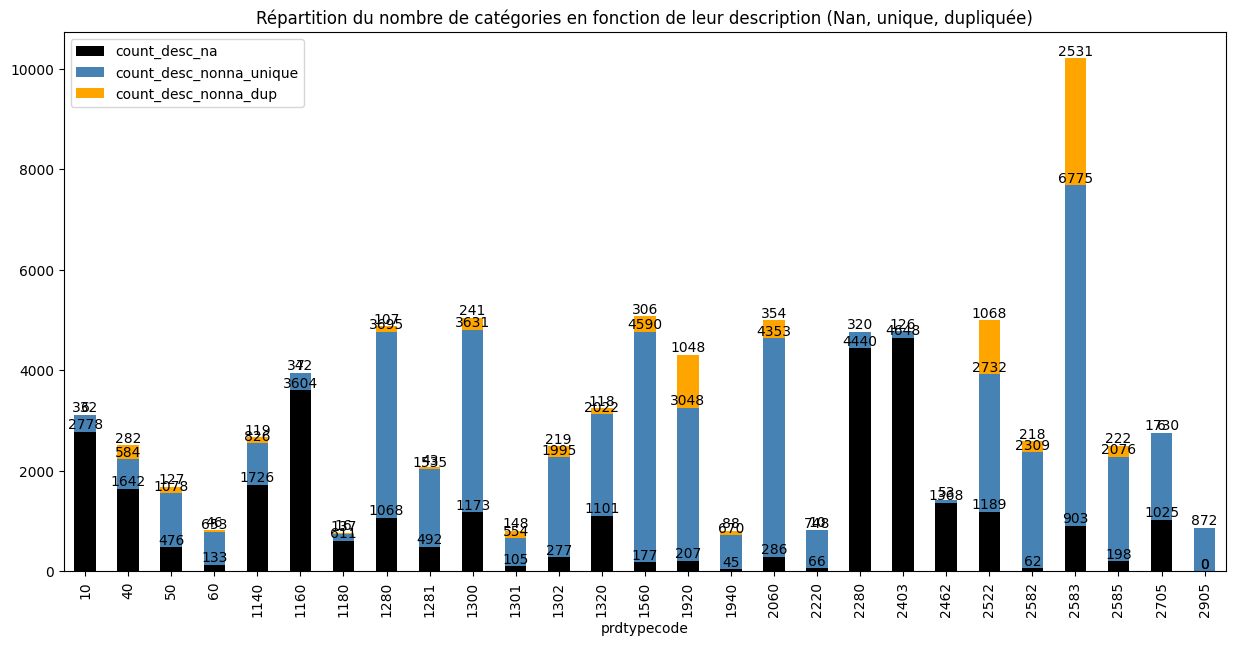

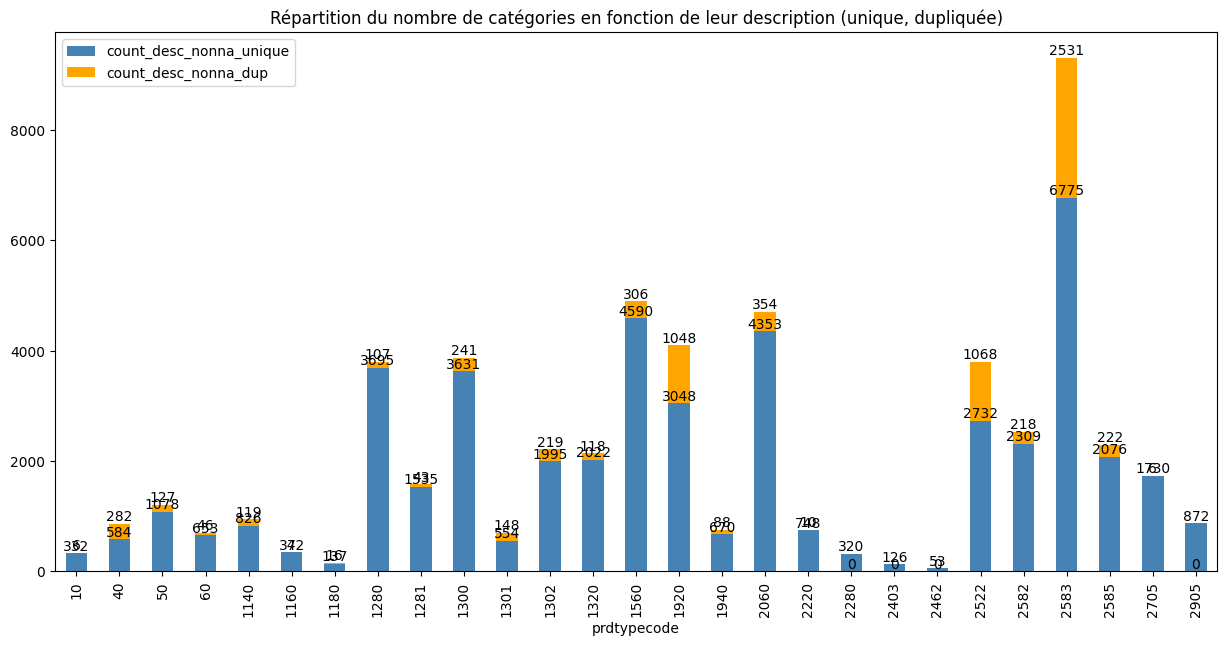

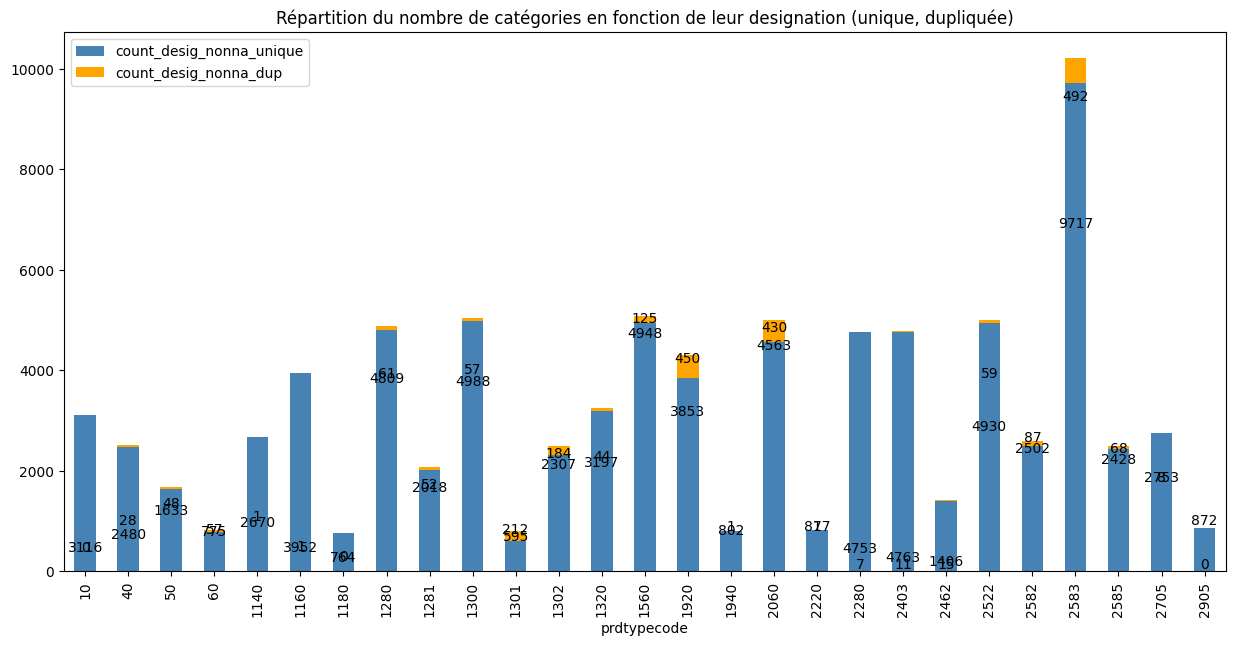

In [8]:

data_byprdtype_na=data.groupby('prdtypecode', group_keys=True).agg(
    count_desc_na=('description',lambda x: x.isna().sum()), 
    count_desc_nonna_unique=('description',lambda x: (x[x.notna()].unique()).size), 
    count_desc_nonna_dup=('description',lambda x: x[x.notna()].duplicated().sum()))

#display(data_byprdtype_na) 

ax1=data_byprdtype_na.plot.bar(stacked=True, color=['black', 'steelblue', 'orange'], figsize=(15, 7))
ax1.bar_label(ax1.containers[0], labels=data_byprdtype_na['count_desc_na'])
ax1.bar_label(ax1.containers[1], labels=data_byprdtype_na['count_desc_nonna_unique'])
ax1.bar_label(ax1.containers[2], labels=data_byprdtype_na['count_desc_nonna_dup'])
plt.title("Répartition du nombre de catégories en fonction de leur description (Nan, unique, dupliquée)")
plt.show();

data_byprdtype_na_1=data.groupby('prdtypecode', group_keys=True).agg(
    count_desc_nonna_unique=('description',lambda x: (x[x.notna()].unique()).size), 
    count_desc_nonna_dup=('description',lambda x: x[x.notna()].duplicated().sum()))

ax2=data_byprdtype_na_1.plot.bar(stacked=True, color=['steelblue', 'orange'], figsize=(15, 7))
ax2.bar_label(ax2.containers[0], labels=data_byprdtype_na_1['count_desc_nonna_unique'])
ax2.bar_label(ax2.containers[1], labels=data_byprdtype_na_1['count_desc_nonna_dup'])
plt.title("Répartition du nombre de catégories en fonction de leur description (unique, dupliquée)")
plt.show();


data_byprdtype_na_2=data.groupby('prdtypecode', group_keys=True).agg(
    count_desig_nonna_unique=('designation',lambda x: (x[x.notna()].unique()).size), 
    count_desig_nonna_dup=('designation',lambda x: x[x.notna()].duplicated().sum()))

ax3=data_byprdtype_na_2.plot.bar(stacked=True, color=['steelblue', 'orange'], figsize=(15, 7))
ax3.bar_label(ax2.containers[0], labels=data_byprdtype_na_2['count_desig_nonna_unique'])
ax3.bar_label(ax2.containers[1], labels=data_byprdtype_na_2['count_desig_nonna_dup'])
plt.title("Répartition du nombre de catégories en fonction de leur designation (unique, dupliquée)")

plt.show();




- **Aucun doublon dans designation; elles ont été toutes réduites à 1 seule designation**
- Product types are not evenly distributed, 2583 is an outlier 
- Need to rebalance the data, by : 
    * For types with highest counts, deleting rows with description = NA values & replacing duplicates
    * Some product types have small amount of relevant 'description', for those a strategy might be relying on the 'designation'
    * Then rebalance the rest following guidelines [here](https://medium.com/@dlikhitha99/all-methods-for-balancing-imbalanced-data-decfe1f4048d)




### B2 Exploration des colonnes par code produit

In [8]:


def generate_max_words_by_code(df=data_cleaned):
    if not isinstance(df, pd.DataFrame):
        return
    
    bytypecode = df.groupby('prdtypecode')
        
    to_ignore = set(get_excluded_words(f'{data_root_folder}/config/excluded_words.txt')[0])  
    my_stopwords = set(STOPWORDS).union(to_ignore).union(stopwords.words('french')).union(stopwords.words('english')).union(stopwords.words('german'))
    final_stopwords_list =  list(my_stopwords)  ### list(fr_stop) + list(en_stop) + list(my_stopwords)

    # Définir les instances vevtorizer (ajouter un preprocessor pour enlever tout ce qui est numérique)
    coun_vect1 = CountVectorizer(lowercase=True, stop_words=final_stopwords_list, max_features=max_features, preprocessor=preprocessor_func)
    coun_vect2 = CountVectorizer(lowercase=True, stop_words=final_stopwords_list, max_features=max_features, preprocessor=preprocessor_func)
    # used only for 'description'
    coun_vect3 = CountVectorizer(lowercase=True, stop_words=final_stopwords_list, max_features=max_features, preprocessor=preprocessor_func) 


    # define add to a list of DataFrames for code_words_count
    code_words_count_dataframes = []
        

    for code, frame in bytypecode:
        if len(cols) > 0:
            for col in cols:
                n_lines = df[col].value_counts()
    
    
    return

NameError: name 'data_cleaned' is not defined

#### B2.1 helper functions

In [10]:

def get_data_to_ignore():
    return set(get_excluded_words(f'{data_root_folder}/config/excluded_words.txt')[0])


def preprocessor_func(text):
    """preprocess words in CountVectorizer call
        takeoff all digits and underscore
    """
    text = text.lower()
    # text = re.sub(r"\d_", '', text)
    text = re.sub(r"[\d_]", '', text)
    return text


def camel_split(s):
    if s=='' :return s
    result = [s[0]] 
    for char in s[1:]:
        if char.isupper():
            result.extend([' ', char])
        else:
            result.append(char)
    return ''.join(result)

def clean_text_1(c):
    to_ignore = get_data_to_ignore()
    c= re.sub(r'.*Attention !!! Ce produit est un import.*', '', c)
    c= re.sub(re.compile(r'\[Import Allemand\]'), '', c)
    c= re.sub(r'<.*?>', ' ', c)
    #c = camel_split(c)
    c = c.lower()
    # c= re.sub(re.compile(r'\b(?:{})\b'.format('|'.join(map(re.escape, nlpfr.Defaults.stop_words)))), '', c)
    c= re.sub(re.compile(r'\b(?:{})\b'.format('|'.join(map(re.escape, stopwords.words('french'))))), '', c)
    c= re.sub('[%s]' % re.escape(string.punctuation), '', c)
    c= re.sub(re.compile(r'\b(?:{})\b'.format('|'.join(map(re.escape, to_ignore)))), '', c)
    c= re.sub(r'\d', '', c)
    c=' '.join([word for word in c.split() if len(word) >=3])
    #ignored as takes time consuming
    #c=' '.join([token.lemma_ for token in list(nlpfr(c)) if (token.is_stop==False)])
    return c

def clean_data(data, cleaner=clean_text_1):
    data_cleaned = data[['designation','description','prdtypecode']].fillna('')
    txt_data_origin=data_cleaned["designation"].str.cat(data_cleaned["description"], sep = " ")
    data['desi_desc'] = txt_data_origin.apply(lambda x:cleaner(x))
    return data
    #return data_cleaned.drop(['designation','description'], axis=1)
    

The goal of following routine is to : 

* Identifiy to what extent the 'designation' & 'description' content are capable to relate to a product type
* What kind of data cleaning should be carried out to make text data the most relevant
* Determine the semantic behind the product type code by displaying random pictues and top keywords for each product type code, it would help in better human interpretation of results during the model experimentation.


#### B2.2 Clean data

In [11]:
# retun cleaned data
data_cleaned = clean_data(data=data)

print(type(data_cleaned))
print(data_cleaned.shape)
display(data_cleaned)


<class 'pandas.core.frame.DataFrame'>
(82265, 6)


designation  \
0      Olivia: Personalisiertes Notizbuch / 150 Seite...   
1      Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...   
2      Grand Stylet Ergonomique Bleu Gamepad Nintendo...   
3      Peluche Donald - Europe - Disneyland 2000 (Mar...   
4                                   La Guerre Des Tuques   
...                                                  ...   
84911                        The Sims [ Import Anglais ]   
84912  Kit piscine acier NEVADA déco pierre Ø 3.50m x...   
84913  Journal Officiel De La Republique Francaise N°...   
84914  Table Basse Bois De Récupération Massif Base B...   
84915  Gomme De Collection 2 Gommes Pinguin Glace Ver...   

                                             description   productid  \
0                                                    NaN  3804725264   
1                                                    NaN   436067568   
2      PILOT STYLE Touch Pen de marque Speedlink est ...   201115110   
3                                                    NaN    50418756   
4      Luc a des id&eacute;es de grandeur. Il veut or...   278535884   
...                                                  ...         ...   
84911                                                NaN   206719094   
84912  <b>Description complète :</b><br />Kit piscine...  3065095706   
84913                                                NaN   440707564   
84914  <p>Cette table basse a un design unique et con...  3942400296   
84915                                                NaN    57203227   

          imageid  prdtypecode  \
0      1263597046           10   
1      1008141237         2280   
2       938777978           50   
3       457047496         1280   
4      1077757786         2705   
...           ...          ...   
84911   941495734           40   
84912  1188462883         2583   
84913  1009325617         2280   
84914  1267353403         1560   
84915   684671297         2522   

                                               desi_desc  
0      olivia personalisiertes notizbuch seiten punkt...  
1      journal arts art marche salon art asiatique ba...  
2      stylet ergonomique gamepad nintendo wii speedl...  
3      peluche donald europe disneyland marionnette d...  
4      guerre tuques luc ideacute grandeur veut organ...  
...                                                  ...  
84911                                           the sims  
84912  kit piscine acier nevada déco pierre kit pisci...  
84913  journal officiel republique changement adresse...  
84914  table basse bois récupération massif base blan...  
84915                  gomme gommes pinguin glace orange  

[82265 rows x 6 columns]

# C. Vectorize and generate words matrices by code category

## C1. Vectorize and analyse text and images helper functions

>helper function

In [12]:

def analyse_text_images(df, nsamples=20, max_features=20, plot_images=False ):
  """Cette fonction parcourt tout le dataset fourni afin de faire une analyse des colonnes 'designation', 'description' 
  et affichier les images associées pour chaque designation

  Args:
      df (DataFrame) : DataFrame correspondant au dataset already cleaned before
      nsamples (int, optional): Nombre de lignes à sélectionner pour l'extraction des mots/images. Defaults to 20.
      max_features (int, optional): Nombre de mots max à extraire. Defaults to 20.
      plot_images (bool, optional): Afficher ou non les images (par défaut non). Defaults to False.
  Returns:
    code_words_count_dataframes : matrix words counts by code as dataframe
    all_feaures : all feature as dataframe limited to max words max_features specified
    summary_df : summary of founded words and comparaison
  """

  if not isinstance(df, pd.DataFrame):
    return


  bytypecode = df.groupby('prdtypecode')
  
  nsamples=nsamples   # first samples number taken for each category code
  max_features=max_features  # max features (words) choosen for each category code
  # N of images rows/cols to plot
  n_images_cols =  5 # N per row
  n_images_rows= 1 + (nsamples // n_images_cols) # max n_images_cols (4) images per row


  print("---N of samples for each code:", str(nsamples), "---Max extracted features (words): ", str(max_features) , "---")
  print("-----------------------------------------------------------------------------------------------------")

    
  to_ignore = set(get_excluded_words(f'{data_root_folder}/config/excluded_words.txt')[0])
  # print('to_ignore=', to_ignore)    
  my_stopwords = set(STOPWORDS).union(to_ignore).union(stopwords.words('french')).union(stopwords.words('english')).union(stopwords.words('german'))
  final_stopwords_list =  list(my_stopwords)  ### list(fr_stop) + list(en_stop) + list(my_stopwords)

  # ajouter un preprocessor pour enlever tout ce qui est numérique
  coun_vect1 = CountVectorizer(lowercase=True, stop_words=final_stopwords_list, max_features=max_features, preprocessor=preprocessor_func)
  coun_vect2 = CountVectorizer(lowercase=True, stop_words=final_stopwords_list, max_features=max_features, preprocessor=preprocessor_func)
  # used only for 'description'
  coun_vect3 = CountVectorizer(lowercase=True, stop_words=final_stopwords_list, max_features=max_features, preprocessor=preprocessor_func) 

  all_feaures = pd.DataFrame({'category_code': 0, 'words': '', 'words_count': 0 }, index=[0])
  summary_df =  pd.DataFrame( { 'set_designation': [],  'n_designation': [],  
                    'set_description': [],  'n_description': [], 
                      'set_designation_description': [], 'n_designation_description': [], 
                      'set_intersection': [], 'n_set_intersection': [],
                        'set_intersection_1': [], 'n_set_intersection_1': [],
                              'set_intersection_2': [], 'n_set_intersection_2': []}
                            )
  # define add to a list of DataFrames for code_words_count
  code_words_count_dataframes = []
      

  for code, frame in bytypecode:
      print(f"First {nsamples} entries for type {code!r}")  
      frame_samples=frame.head(nsamples)
      display(frame_samples[['designation', 'description', 'prdtypecode']])

      if plot_images==True:
        fig = plt.figure(figsize=(50, 10*(nsamples // 20))) 
        #fig, axs = plt.subplots(1, nsamples, figsize=(50, 30))
        for i, (index, row) in zip(range(1, 1+nsamples), frame_samples.iterrows()):
            imgid = row['imageid']
            prdid = row['productid']
            
            #img = mpimg.imread(f'{data_images_root_folder}/image_train/image_{imgid}_product_{prdid}.jpg')
            img = Image.open(f'{data_images_root_folder}/image_train/image_{imgid}_product_{prdid}.jpg')
            
            # Adds a subplot at the 1st positio 
            ax = fig.add_subplot(n_images_rows, n_images_cols, i) 
            #ax.margins(4, 4) 
            ax.imshow(img)
            ax.axis('off')
        plt.show()

      # Text count vectorizer on the product type data frame
      print('Before cleaning: Vectorization...')
      count_matrix_desi = coun_vect1.fit_transform(frame['designation'])
      count_matrix_desi_desc = coun_vect2.fit_transform(frame['desi_desc'].fillna(''))
      count_matrix_desc = coun_vect3.fit_transform(frame['description'].fillna(''))
      
      print(f'Top {max_features} features when designation', coun_vect1.get_feature_names_out())
      print(f'Top {max_features} features when description', coun_vect3.get_feature_names_out())
      print(f'Top {max_features} features when desi_desc', coun_vect2.get_feature_names_out())
      
      set_1 = set(coun_vect1.get_feature_names_out())
      print(f'Top {max_features} features when designation', set_1)
      set_2 = set(coun_vect3.get_feature_names_out())
      print(f'Top {max_features} features when description', set_2)
      set_3 = set(coun_vect2.get_feature_names_out())
      print(f'Top {max_features} features when designation+description', set_3)
    
      # generate np.array for set_3 and write output to csv file (one by code)
      code_words_count = pd.DataFrame(data=count_matrix_desi_desc.toarray(),  columns=coun_vect2.get_feature_names_out())
      # add code column, leter we should add category description
      code_words_count['category_code'] = code
      # write to appropriate csv file
      code_words_count.to_csv(f'{data_root_folder}/vectorizations/code_' + str(code) +'_words_count.csv')
      # append code_words_count code_words_count_dataframes list
      code_words_count_dataframes.append(code_words_count)
      
    
      # add new words list to all_feaures dataframe
      all_feaures.loc[len(all_feaures)] = [code, ', '.join(set_3), len(set_3)]
      
      
      print('======================================================================================================')
      n_designation = len(set_1)
      n_description = len(set_2)
      n_designation_description = len(set_3)
      
      set_intersection =  ( set(set_1) - set(set_2) )
      n_set_intersection = len(set_intersection)
      print("words found in 'designation' NOT in 'description':", n_set_intersection)
      display(set_intersection)
      
      if set_2 != []:
          set_intersection_1 =  ( set(set_2) - set(set_1) )
      else:
          set_intersection_1 =   set(set_1) 
      n_set_intersection_1 = len(set_intersection_1)
      print("words found in 'description' NOT in 'designation':", n_set_intersection_1)
      display(set_intersection_1)
      
      set_intersection_2 = set(set_1).intersection(set(set_2))
      n_set_intersection_2 = len(set_intersection_2)
      print("words found in both 'description' AND 'designation':", n_set_intersection_2)
      display(set_intersection_2)
      
      
      # add on row to summary DF summary_df
      summary_df.loc[len(summary_df)] = [str(set_1), str(n_designation), 
                                        str(set_2), str(n_designation),
                                        str(set_3), str(n_designation_description), 
                                        str(set_intersection),str(n_set_intersection),
                                        str(set_intersection_1), str(n_set_intersection_1),
                                        str(set_intersection_2), str(n_set_intersection_2)]    
      
  with pd.option_context('display.max_rows', None, 'display.max_columns', None):
      print('Sammary of differences:\n=================================') 
      print('all words by code:\n=================================') 
      print("n_designation : N of words in designation")
      print("n_description : N of words in description")
      print("n_designation_description : N of words in designation+description")
      print("set_intersection : Words in designation NOT in description")
      print("set_intersection : N of words in designation NOT in description")
      print("set_intersection_1 : Words in description NOT in designation")
      print("set_intersection_1 : N of words in description NOT in designation")
      print("set_intersection_2 : Words found in both 'description' AND 'designation")
      print("set_intersection_2 : N of words in both 'description' AND 'designation")
      
      display(summary_df)
      display(all_feaures)
      all_feaures.to_csv(f'{data_root_folder}/vectorizations/all_feaures.csv')

  print("Finished !-----------------------------------------------------------------------")
  
  return code_words_count_dataframes, all_feaures, summary_df



## C2. Generate words matrix

>Appel de la fonction précédente pour extraire le texte et les images : passer le dataset **data**, **nombre de samples à traiter** et **le nombre MAX des features à extraire** (mots)

In [13]:
print(type(data_cleaned))
print(data_cleaned.shape)

<class 'pandas.core.frame.DataFrame'>
(82265, 6)


In [14]:

#code_words_count_dataframes, all_feaures, summary_df = analyse_text_images(data, nsamples=9000, max_features=50, plot_images=False)
code_words_count_dataframes, all_feaures, summary_df = analyse_text_images(data_cleaned, nsamples=9000, max_features=300, plot_images=False)

---N of samples for each code: 9000 ---Max extracted features (words):  300 ---
-----------------------------------------------------------------------------------------------------
First 9000 entries for type 10


designation description  \
0      Olivia: Personalisiertes Notizbuch / 150 Seite...         NaN   
6             Christof E: Bildungsprozessen Auf Der Spur         NaN   
46     Vassivière -En-Limousin.  Le Jardin Art Et Lie...         NaN   
131      Dr. Mercurius' Heilsame Reise Zum Planeten Erde         NaN   
188                                 La Promenade Au Parc         NaN   
...                                                  ...         ...   
84742  Arrêt Du Conseil D'etat Portant Nouveau Règlem...         NaN   
84774  Pages Choisies De Grands Écrivains : J.J. Rous...         NaN   
84809  Galileo Galilei : Sa Vie Son Procès Et Ses Con...         NaN   
84896                           Elder Law For Paralegals         NaN   
84900                         Mi Libro De Cortar Y Pegar         NaN   

       prdtypecode  
0               10  
6               10  
46              10  
131             10  
188             10  
...            ...  
84742           10  
84774           10  
84809           10  
84896           10  
84900           10  

[3114 rows x 3 columns]

Before cleaning: Vectorization...
Top 300 features when designation ['actes' 'action' 'advances' 'adventures' 'afrique' 'age' 'album'
 'america' 'american' 'amour' 'amérique' 'analyse' 'analysis' 'ancient'
 'annee' 'applications' 'apprendre' 'architecture' 'arrêt' 'art' 'arts'
 'association' 'atlas' 'audio' 'autour' 'aventures' 'best' 'bible'
 'bibliotheque' 'bordeaux' 'bretagne' 'building' 'bulletin' 'business'
 'cahiers' 'canada' 'catalogue' 'cd' 'century' 'chambre' 'chant' 'charles'
 'chemin' 'chemins' 'child' 'children' 'chroniques' 'ciel' 'city' 'civil'
 'coeur' 'college' 'communication' 'composition' 'conseil' 'contes'
 'control' 'cookbook' 'corps' 'country' 'cour' 'cours' 'cuisine' 'cycle'
 'dame' 'days' 'death' 'del' 'design' 'deuxième' 'development' 'diary'
 'dictionary' 'dictionnaire' 'dieu' 'discours' 'dix' 'dr' 'droit' 'ecole'
 'economie' 'education' 'el' 'eme' 'empire' 'enfance' 'enfants'
 'engineering' 'english' 'enseignement' 'entretiens' 'esprit' 'etat'
 'europe' 'europ

d:\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['xlx'] not in stop_words.
  warnings.warn(


words found in 'designation' NOT in 'description': 223


{'actes',
 'action',
 'advances',
 'adventures',
 'afrique',
 'age',
 'album',
 'america',
 'american',
 'amérique',
 'analyse',
 'analysis',
 'ancient',
 'annee',
 'apprendre',
 'architecture',
 'arrêt',
 'arts',
 'atlas',
 'audio',
 'autour',
 'aventures',
 'best',
 'bible',
 'bibliotheque',
 'bretagne',
 'building',
 'bulletin',
 'business',
 'cahiers',
 'catalogue',
 'cd',
 'century',
 'chambre',
 'chant',
 'chemin',
 'chemins',
 'child',
 'chroniques',
 'ciel',
 'city',
 'civil',
 'coeur',
 'college',
 'communication',
 'conseil',
 'contes',
 'control',
 'cookbook',
 'corps',
 'country',
 'cuisine',
 'cycle',
 'dame',
 'days',
 'del',
 'design',
 'deuxième',
 'development',
 'diary',
 'dictionary',
 'dictionnaire',
 'dieu',
 'discours',
 'dix',
 'ecole',
 'economie',
 'el',
 'eme',
 'enfance',
 'enfants',
 'engineering',
 'english',
 'entretiens',
 'esprit',
 'europe',
 'european',
 'exercices',
 'fa',
 'family',
 'feu',
 'fiction',
 'fils',
 'fin',
 'format',
 'francais',
 'gener

words found in 'description' NOT in 'designation': 223


{'achats',
 'advice',
 'aimed',
 'allemand',
 'amis',
 'ammareal',
 'américain',
 'ancien',
 'août',
 'approach',
 'arbres',
 'arnaud',
 'article',
 'bernard',
 'bibliothèque',
 'bibliothèques',
 'body',
 'bop',
 'boîtes',
 'brasileira',
 'caritatives',
 'cartonnage',
 'charlie',
 'château',
 'civière',
 'claude',
 'coins',
 'collectif',
 'colonie',
 'commentaire',
 'compagnons',
 'compris',
 'concile',
 'concours',
 'conseils',
 'conte',
 'contents',
 'contrats',
 'contribution',
 'contrôle',
 'copyright',
 'couverture',
 'currently',
 'différente',
 'dimension',
 'direction',
 'discrimination',
 'donnent',
 'dos',
 'duhamel',
 'découvrir',
 'département',
 'déserts',
 'editeur',
 'em',
 'ensemble',
 'envoi',
 'essai',
 'estuaire',
 'etude',
 'every',
 'exemplaire',
 'extrait',
 'faits',
 'famille',
 'fashion',
 'femmes',
 'fera',
 'fil',
 'find',
 'food',
 'fournis',
 'frais',
 'genre',
 'george',
 'georges',
 'gouffre',
 'hall',
 'help',
 'henri',
 'hours',
 'human',
 'ideal',
 'ill

words found in both 'description' AND 'designation': 77


{'amour',
 'applications',
 'art',
 'association',
 'bordeaux',
 'canada',
 'charles',
 'children',
 'composition',
 'cour',
 'cours',
 'death',
 'dr',
 'droit',
 'education',
 'empire',
 'enseignement',
 'etat',
 'exposition',
 'face',
 'first',
 'février',
 'guerre',
 'guide',
 'histoire',
 'homme',
 'hommes',
 'humaine',
 'ii',
 'international',
 'jean',
 'law',
 'lettres',
 'livre',
 'livres',
 'louis',
 'love',
 'magazine',
 'maladies',
 'management',
 'marie',
 'monde',
 'mort',
 'nationale',
 'notes',
 'nouvelles',
 'oeuvre',
 'one',
 'pages',
 'paix',
 'piano',
 'pierre',
 'politique',
 'pratiques',
 'provence',
 'revue',
 'roman',
 'saint',
 'science',
 'sciences',
 'second',
 'secrets',
 'siecle',
 'siècle',
 'société',
 'street',
 'suite',
 'série',
 'techniques',
 'textes',
 'tome',
 'traduit',
 'vol',
 'voyage',
 'young',
 'école',
 'édition'}

First 9000 entries for type 40


designation  \
31                                   X-Men 3 - The Movie   
34                                 The Lord Or Thé Rings   
47          Shin Masoukishin Panzer Warfare (Import Jap)   
50                                Jeu Pc Cd-Rom : Azteca   
101         Innercity Burnout [Import Allemand] [Jeu Pc]   
...                                                  ...   
84817  Men In Black Alien Crisis - Ensemble Complet -...   
84833               Gundam Battle Online (Version Japon)   
84841                     Timesplitters - Future Perfect   
84865  Câble Audio Jack Steréo 3.5 Mm Rca Mâle Access...   
84911                        The Sims [ Import Anglais ]   

                                             description  prdtypecode  
31                                                   NaN           40  
34                                                   NaN           40  
47                                                   NaN           40  
50                                                   NaN           40  
101                                                                40  
...                                                  ...          ...  
84817                                                NaN           40  
84833                                                NaN           40  
84841                                                NaN           40  
84865  <p><b>La description:</b></p><br /><p> Jack 35...           40  
84911                                                NaN           40  

[2478 rows x 3 columns]

Before cleaning: Vectorization...
Top 300 features when designation ['accessoire' 'accessoires' 'action' 'adaptateur' 'add' 'advance'
 'adventure' 'age' 'air' 'alimentation' 'alive' 'allemand' 'alone'
 'aluminium' 'amplificateur' 'américain' 'analogique' 'android'
 'anniversary' 'antenne' 'arcade' 'art' 'assassin' 'atari' 'atelier'
 'audio' 'auto' 'aventure' 'aventures' 'ball' 'baseball' 'batman' 'battle'
 'best' 'bluetooth' 'bouton' 'boutons' 'boîte' 'broches' 'caméra'
 'capteur' 'capuchon' 'carte' 'cartouche' 'case' 'cd' 'championship'
 'charge' 'chocs' 'city' 'clancy' 'classics' 'classique' 'club' 'code'
 'coffret' 'collector' 'color' 'combat' 'commutateur' 'connecteur'
 'console' 'controller' 'contrôleur' 'convertisseur' 'coque' 'couvercle'
 'couverture' 'creed' 'cry' 'câble' 'dance' 'dark' 'day' 'dead' 'deluxe'
 'disney' 'double' 'dragon' 'ds' 'dvd' 'ea' 'elder' 'ensemble'
 'essentials' 'etui' 'evil' 'extension' 'fallout' 'famicom' 'fantasy'
 'femelle' 'fifa' 'fighter' 'fil' 'film

{'accessoire',
 'add',
 'advance',
 'adventure',
 'age',
 'air',
 'alive',
 'allemand',
 'alone',
 'amplificateur',
 'américain',
 'anniversary',
 'art',
 'assassin',
 'atari',
 'atelier',
 'auto',
 'aventure',
 'aventures',
 'baseball',
 'batman',
 'battle',
 'best',
 'caméra',
 'capuchon',
 'cartouche',
 'championship',
 'city',
 'clancy',
 'classics',
 'classique',
 'club',
 'code',
 'coffret',
 'collector',
 'color',
 'combat',
 'creed',
 'cry',
 'dance',
 'dark',
 'day',
 'dead',
 'deluxe',
 'disney',
 'ea',
 'elder',
 'essentials',
 'etui',
 'evil',
 'fallout',
 'famicom',
 'fantasy',
 'fifa',
 'fighter',
 'final',
 'fire',
 'football',
 'force',
 'games',
 'gaming',
 'gear',
 'generation',
 'ghost',
 'gold',
 'golf',
 'halo',
 'hero',
 'heroes',
 'high',
 'hits',
 'honor',
 'hunter',
 'ii',
 'iii',
 'island',
 'italien',
 'iv',
 'japonaise',
 'king',
 'kingdom',
 'kol',
 'league',
 'legend',
 'legends',
 'lego',
 'limited',
 'limitée',
 'mac',
 'magic',
 'magideal',
 'mario',
 '

words found in 'description' NOT in 'designation': 192


{'abs',
 'adapté',
 'adhérence',
 'affichage',
 'agrave',
 'alliage',
 'appareil',
 'appareils',
 'approx',
 'article',
 'base',
 'batterie',
 'boîtier',
 'caoutchouc',
 'capacité',
 'cartes',
 'casque',
 'chaussures',
 'clair',
 'clavier',
 'clés',
 'commande',
 'commandes',
 'compact',
 'compatible',
 'conception',
 'conducteur',
 'confortable',
 'connecter',
 'connecteurs',
 'connectez',
 'contenu',
 'contrôle',
 'contrôleurs',
 'convient',
 'conçu',
 'corps',
 'courant',
 'cuivre',
 'câbles',
 'design',
 'devez',
 'différent',
 'différente',
 'différents',
 'directement',
 'distance',
 'dommages',
 'données',
 'droit',
 'durée',
 'démonter',
 'efficacement',
 'endommagé',
 'enfants',
 'entrée',
 'ergonomique',
 'eva',
 'expérience',
 'fabriqué',
 'facilement',
 'femme',
 'fiche',
 'figure',
 'fit',
 'fonctionne',
 'fonctionnement',
 'forfait',
 'forme',
 'fréquence',
 'fusible',
 'gamecube',
 'hz',
 'hôte',
 'image',
 'installation',
 'installer',
 'interface',
 'interrupteur',
 'i

words found in both 'description' AND 'designation': 108


{'accessoires',
 'action',
 'adaptateur',
 'alimentation',
 'aluminium',
 'analogique',
 'android',
 'antenne',
 'arcade',
 'audio',
 'ball',
 'bluetooth',
 'bouton',
 'boutons',
 'boîte',
 'broches',
 'capteur',
 'carte',
 'case',
 'cd',
 'charge',
 'chocs',
 'commutateur',
 'connecteur',
 'console',
 'controller',
 'contrôleur',
 'convertisseur',
 'coque',
 'couvercle',
 'couverture',
 'câble',
 'double',
 'dragon',
 'ds',
 'dvd',
 'ensemble',
 'extension',
 'femelle',
 'fil',
 'film',
 'game',
 'gamepad',
 'go',
 'hd',
 'hdmi',
 'housse',
 'intégré',
 'jack',
 'jeu',
 'jeux',
 'joystick',
 'kit',
 'lite',
 'manette',
 'microsoft',
 'mini',
 'mobile',
 'monde',
 'mâle',
 'nintendo',
 'ns',
 'one',
 'outils',
 'pad',
 'pal',
 'parleur',
 'pc',
 'pcs',
 'peau',
 'pièce',
 'pièces',
 'plastique',
 'playstation',
 'poignée',
 'portable',
 'prise',
 'pro',
 'protection',
 'ps',
 'radio',
 'rca',
 'refroidissement',
 'sac',
 'set',
 'silicone',
 'slim',
 'sony',
 'stéréo',
 'support',
 'sw

First 9000 entries for type 50


designation  \
2      Grand Stylet Ergonomique Bleu Gamepad Nintendo...   
80     Contrôleur De Jeu Mobile Tir Sensible Et But J...   
163        Fauteuil De Bureau Gaming Swift Noir Et Rouge   
165    Sony Dualshock 4 V2 - Gamepad - Sans Fil - Blu...   
207    Manette Filaire Ps3 / Pc Shockpad Ghx5ef Shock...   
...                                                  ...   
84620  Élément De Jeu - Notice De Remplacement - Inde...   
84628  Insten® Housse Coque Étui De Protection En Sil...   
84665                    Cable Rvl-009 Pour Wii Officiel   
84815  Sn30 Pro Contrôleur De Jeu Sans Fil Pour Windo...   
84832  Batterie Rechargeable 3900mah Pour Manette Pad...   

                                             description  prdtypecode  
2      PILOT STYLE Touch Pen de marque Speedlink est ...           50  
80     Contrôleur de jeu mobile Tir sensible et But J...           50  
163                                                  NaN           50  
165                                                  NaN           50  
207    Manette filaire compatible PS3 / PC ShockPad r...           50  
...                                                  ...          ...  
84620                                                NaN           50  
84628  <b>Compatible avec:</b><ul><li>Sony PlayStatio...           50  
84665                                                NaN           50  
84815  SN30 Game Controller Pro Wireless pour Windows...           50  
84832  <b>Compatible avec:</b><ul><li>Microsoft Xbox ...           50  

[1633 rows x 3 columns]

Before cleaning: Vectorization...
Top 300 features when designation ['ac' 'accessoires' 'accueil' 'ach' 'acier' 'adaptateur' 'advance' 'air'
 'airpods' 'alimentation' 'allume' 'aluminium' 'amiibo' 'android'
 'appareil' 'apple' 'arcade' 'argent' 'audio' 'autocollant' 'autocollants'
 'ball' 'batterie' 'bc' 'bigben' 'bloc' 'bluetooth' 'boitier' 'bouton'
 'boutons' 'box' 'boîte' 'bracelet' 'bureau' 'cable' 'cache' 'cadeau'
 'cam' 'camouflage' 'caméra' 'caoutchouc' 'carte' 'case' 'casque' 'chaise'
 'charge' 'chargement' 'charger' 'chargeur' 'charging' 'choc' 'cigare'
 'clair' 'classique' 'clavier' 'cle' 'collector' 'commande' 'commutateur'
 'commutateurhoeroie' 'compatible' 'connecteur' 'console' 'contr'
 'control' 'controller' 'contrôle' 'contrôleur' 'convertisseur' 'coque'
 'couverture' 'cristal' 'cuir' 'câble' 'design' 'disc' 'disney' 'disque'
 'dock' 'double' 'dragon' 'dragonne' 'ds' 'dsi' 'dual' 'dualshock' 'dur'
 'décalque' 'ecran' 'enfants' 'ergonomique' 'etui' 'eva' 'evoli'
 'extens

{'ac',
 'accueil',
 'ach',
 'acier',
 'advance',
 'air',
 'airpods',
 'allume',
 'aluminium',
 'amiibo',
 'arcade',
 'argent',
 'bc',
 'bigben',
 'bloc',
 'boitier',
 'box',
 'bureau',
 'cache',
 'cadeau',
 'cam',
 'camouflage',
 'caméra',
 'case',
 'chaise',
 'charging',
 'choc',
 'cigare',
 'clair',
 'cle',
 'collector',
 'commutateurhoeroie',
 'contr',
 'control',
 'convertisseur',
 'cristal',
 'disc',
 'disney',
 'disque',
 'dragon',
 'dragonne',
 'dsi',
 'dual',
 'dualshock',
 'décalque',
 'ecran',
 'enfants',
 'evoli',
 'extension',
 'fauteuil',
 'fc',
 'figurine',
 'fitbit',
 'force',
 'full',
 'gameboy',
 'gamecube',
 'gamer',
 'games',
 'ghz',
 'giants',
 'gold',
 'goverie',
 'guide',
 'hard',
 'hori',
 'htc',
 'infinity',
 'inoxydable',
 'insten',
 'intra',
 'ipad',
 'joypad',
 'kart',
 'lcd',
 'legendary',
 'lentille',
 'link',
 'logitech',
 'lr',
 'mario',
 'megadrive',
 'metal',
 'microsoft',
 'motion',
 'mètres',
 'mémoire',
 'nin',
 'nintend',
 'numérique',
 'optique',
 

words found in 'description' NOT in 'designation': 162


{'abs',
 'affichage',
 'amovible',
 'angle',
 'appareils',
 'appuyez',
 'bande',
 'base',
 'batteries',
 'bo',
 'brillante',
 'capacité',
 'capteur',
 'caract',
 'cartes',
 'chocs',
 'classiques',
 'clé',
 'clés',
 'collant',
 'commutateurs',
 'conception',
 'confort',
 'confortable',
 'connecter',
 'connecté',
 'consoles',
 'contenu',
 'continu',
 'contrôleurs',
 'convient',
 'conçu',
 'cool',
 'coupe',
 'courant',
 'cran',
 'descriptions',
 'differents',
 'differer',
 'directement',
 'distance',
 'données',
 'durée',
 'eau',
 'ecart',
 'effet',
 'element',
 'entrée',
 'expérience',
 'facilement',
 'faders',
 'finition',
 'fonctionne',
 'fonctionnement',
 'fonctionner',
 'fonctions',
 'forfait',
 'format',
 'forme',
 'hz',
 'hôte',
 'illustration',
 'image',
 'imprimé',
 'imprimée',
 'installation',
 'installer',
 'interface',
 'interrupteur',
 'interrupteurs',
 'intégrée',
 'intégrés',
 'intérieur',
 'ion',
 'joueurs',
 'laisser',
 'lecture',
 'ligne',
 'liste',
 'lithium',
 'longue'

words found in both 'description' AND 'designation': 138


{'accessoires',
 'adaptateur',
 'alimentation',
 'android',
 'appareil',
 'apple',
 'audio',
 'autocollant',
 'autocollants',
 'ball',
 'batterie',
 'bluetooth',
 'bouton',
 'boutons',
 'boîte',
 'bracelet',
 'cable',
 'caoutchouc',
 'carte',
 'casque',
 'charge',
 'chargement',
 'charger',
 'chargeur',
 'classique',
 'clavier',
 'commande',
 'commutateur',
 'compatible',
 'connecteur',
 'console',
 'controller',
 'contrôle',
 'contrôleur',
 'coque',
 'couverture',
 'cuir',
 'câble',
 'design',
 'dock',
 'double',
 'ds',
 'dur',
 'ergonomique',
 'etui',
 'eva',
 'feu',
 'fil',
 'filaire',
 'film',
 'game',
 'gamepad',
 'gaming',
 'go',
 'grip',
 'hd',
 'hdmi',
 'housse',
 'intégré',
 'ios',
 'iphone',
 'jeu',
 'jeux',
 'joy',
 'joystick',
 'kit',
 'lecteur',
 'led',
 'lite',
 'manette',
 'manettes',
 'max',
 'micro',
 'microphone',
 'mince',
 'mini',
 'mobile',
 'mode',
 'montre',
 'nintendo',
 'ns',
 'one',
 'ordinateur',
 'pack',
 'pad',
 'pc',
 'pcs',
 'peau',
 'phone',
 'playstatio

First 9000 entries for type 60


designation  \
40     Mini Console De Jeux Double Joueurs 8 Bits Con...   
180    Nouvelle Console De Jeu Vidéo Portable Rétro 1...   
270    5.1 Pouces Hd Écran Double Joystick Lecteur De...   
299    Lecteur Nostalgique Mini Lecteurs De Jeux Vidé...   
375    4.3 ''multi-Fonction Portable Jeu Console De J...   
...                                                  ...   
83962  Console Xbox 360 4go + Kinect + Kinect Adventures   
84044  Console De Jeu Vidéo 8 Bits Rétro Mini Poche L...   
84403  Q9 3000 Jeux Rétro Console De Jeu Portable 60h...   
84437                               Game & Watch Manhole   
84460  Microsoft Xbox One S 1tb + Playerunknowns Batt...   

                                             description  prdtypecode  
40     Nom de la marque:NoEnName_Null<br />Affichage ...           60  
180    Affichage de couleur:Oui<br />Paquet:Oui<br />...           60  
270    Numéro du modèle:model 310<br />Taille de l&#3...           60  
299    Affichage de couleur:Oui<br />Paquet:Oui<br />...           60  
375    Affichage de couleur:Oui<br />Nom de la marque...           60  
...                                                  ...          ...  
83962  1 console de jeu vidéo Xbox 360 noir mat<br />...           60  
84044  Nom de la marque:MEIJYSH<br />Affichage de cou...           60  
84403  Nom de la marque:POWKIDDY<br />Affichage de co...           60  
84437  Game & Watch Manhole New Wide Screen date sort...           60  
84460  <b>Laissez-vous surprendre.</b><br /> Bienvenu...           60  

[774 rows x 3 columns]

Before cleaning: Vectorization...
Top 300 features when designation ['abs' 'accessoires' 'adventures' 'affichage' 'alloyseed' 'android'
 'animal' 'animaux' 'arcade' 'archives' 'atari' 'ball' 'bascule' 'basic'
 'batterie' 'battlefront' 'bianco' 'blanche' 'bleue' 'bluetooth' 'box'
 'boîte' 'bricolage' 'bulit' 'bundle' 'cadeau' 'cadeaux' 'caméra' 'carte'
 'cartes' 'charge' 'chargeur' 'clank' 'classique' 'classiques' 'clavier'
 'clés' 'coloré' 'combiné' 'commutateur' 'compagnie' 'compatible' 'conso'
 'consola' 'console' 'consoles' 'construire' 'construit' 'controller'
 'contrôle' 'contrôleur' 'contrôleurs' 'cp' 'cps' 'câble' 'data'
 'différents' 'directe' 'domicile' 'double' 'doubles' 'drive' 'driveclub'
 'drone' 'ds' 'dsi' 'définition' 'elite' 'enfance' 'enfant' 'enfants'
 'externe' 'familiale' 'famille' 'fantasy' 'fc' 'fi' 'fifa' 'fil' 'film'
 'final' 'fm' 'format' 'fortnite' 'forza' 'frog' 'fréquence' 'game'
 'gameboy' 'gamecube' 'gamepad' 'gamepads' 'gameta' 'gane' 'gba' 'gbc'
 'gc' 'g

{'accessoires',
 'adventures',
 'android',
 'animal',
 'animaux',
 'archives',
 'atari',
 'ball',
 'bascule',
 'basic',
 'batterie',
 'battlefront',
 'bianco',
 'bleue',
 'boîte',
 'bricolage',
 'bulit',
 'bundle',
 'cadeau',
 'cadeaux',
 'chargeur',
 'clank',
 'classique',
 'classiques',
 'clavier',
 'clés',
 'coloré',
 'combiné',
 'compagnie',
 'conso',
 'construire',
 'construit',
 'contrôle',
 'contrôleur',
 'contrôleurs',
 'cps',
 'différents',
 'directe',
 'domicile',
 'doubles',
 'drive',
 'driveclub',
 'drone',
 'dsi',
 'définition',
 'elite',
 'enfance',
 'enfant',
 'enfants',
 'externe',
 'familiale',
 'famille',
 'fantasy',
 'film',
 'final',
 'fm',
 'fortnite',
 'forza',
 'fréquence',
 'gameboy',
 'gamecube',
 'gamepads',
 'gane',
 'gbc',
 'genesis',
 'geo',
 'gratuit',
 'gratuite',
 'gratuits',
 'gros',
 'home',
 'horizon',
 'hot',
 'hyrule',
 'hz',
 'iii',
 'inazuma',
 'interaction',
 'interrupteur',
 'intégrée',
 'intégrés',
 'ips',
 'japonaise',
 'jaune',
 'jouet',
 'jo

words found in 'description' NOT in 'designation': 191


{'aaa',
 'ac',
 'acirc',
 'action',
 'adaptateur',
 'age',
 'agrave',
 'alimentation',
 'amily',
 'amis',
 'applicable',
 'audio',
 'aventure',
 'avi',
 'bank',
 'base',
 'battery',
 'blu',
 'blue',
 'boutique',
 'boyhom',
 'brand',
 'cable',
 'camera',
 'capacity',
 'card',
 'charging',
 'children',
 'clientes',
 'code',
 'color',
 'colour',
 'communication',
 'compatibles',
 'compris',
 'computer',
 'connection',
 'consommation',
 'control',
 'course',
 'courses',
 'cr',
 'design',
 'di',
 'display',
 'disque',
 'données',
 'download',
 'drop',
 'dual',
 'dualshock',
 'dur',
 'dvd',
 'eastvita',
 'ecirc',
 'ecran',
 'ect',
 'egrave',
 'electronic',
 'english',
 'entrée',
 'ethernet',
 'expérience',
 'family',
 'features',
 'fghgf',
 'films',
 'fkissme',
 'football',
 'formats',
 'forme',
 'function',
 'funtion',
 'games',
 'gaming',
 'gddr',
 'gif',
 'gold',
 'grandes',
 'graphique',
 'greatlizard',
 'green',
 'hand',
 'handeld',
 'haolonggcp',
 'hdr',
 'held',
 'heynow',
 'high',
 '

words found in both 'description' AND 'designation': 109


{'abs',
 'affichage',
 'alloyseed',
 'arcade',
 'blanche',
 'bluetooth',
 'box',
 'caméra',
 'carte',
 'cartes',
 'charge',
 'commutateur',
 'compatible',
 'consola',
 'console',
 'consoles',
 'controller',
 'cp',
 'câble',
 'data',
 'double',
 'ds',
 'fc',
 'fi',
 'fifa',
 'fil',
 'format',
 'frog',
 'game',
 'gamepad',
 'gameta',
 'gba',
 'gc',
 'go',
 'handheld',
 'hd',
 'hdmi',
 'hobbylane',
 'ii',
 'interface',
 'intégré',
 'jeu',
 'jeux',
 'joueur',
 'joueurs',
 'kart',
 'kiii',
 'last',
 'lcd',
 'ldk',
 'lecteur',
 'lego',
 'linux',
 'machine',
 'main',
 'manette',
 'mario',
 'meilleur',
 'mini',
 'mode',
 'mp',
 'multi',
 'mémoire',
 'nintendo',
 'ntsc',
 'one',
 'pack',
 'pal',
 'pap',
 'pc',
 'play',
 'playstation',
 'plug',
 'port',
 'portable',
 'powkiddy',
 'prise',
 'ps',
 'psp',
 'pvp',
 'pxp',
 'rechargeable',
 'retro',
 'rs',
 'screen',
 'sg',
 'slim',
 'sony',
 'sortie',
 'station',
 'street',
 'support',
 'switch',
 'system',
 'système',
 'tactile',
 'transparent',
 

First 9000 entries for type 1140


designation  \
18     Power Rangers Rouge Force Mystic Figurine Tran...   
23                             Véhicule Star Wars A-Ast5   
66                                Magnet Europe Paris 44   
72              Lampe Star Wars - Lampe Neon Sabre Laser   
98     It - Bobble Head Pop N° 539 - Beverly With Key...   
...                                                  ...   
84580                           Doctor Who Mug Dalek Pop   
84604   Vintage Tenue Action Man - Red Devil Parachutist   
84857  Figurine Wintouc - Série Pocahontas Miniature ...   
84901  Figurine "Bip / Viacom" - Dora L'exploratrice ...   
84906                            Buste Dark Vador Disney   

                                             description  prdtypecode  
18                                                   NaN         1140  
23       véhicule vintage de la saga star wars le A-AST5         1140  
66                                                   NaN         1140  
72     Lampe néon taille env. 22 x 28 cm avec base d¿...         1140  
98                                                   NaN         1140  
...                                                  ...          ...  
84580                                                NaN         1140  
84604                                                NaN         1140  
84857  Figurine Wintouc (35 cm) Nestlé 1996 version m...         1140  
84901  figurines "Viacom" (surprises Daniel Roche) co...         1140  
84906                reproduction du buste de Dark Vador         1140  

[2670 rows x 3 columns]

Before cleaning: Vectorization...
Top 300 features when designation ['action' 'adventure' 'age' 'aladdin' 'alien' 'america' 'animaux'
 'anneaux' 'anniversary' 'articulée' 'arts' 'assassin' 'asterix' 'astérix'
 'atlas' 'avengers' 'back' 'ball' 'bandai' 'banpresto' 'batman' 'battle'
 'bb' 'ben' 'biz' 'blade' 'blanche' 'blue' 'bob' 'bobble' 'boite' 'box'
 'bunny' 'buste' 'captain' 'carte' 'cercle' 'chase' 'chat' 'chevalier'
 'chopper' 'cles' 'cloth' 'clé' 'clés' 'cobra' 'collector' 'color'
 'comics' 'creed' 'dark' 'darth' 'dbz' 'dead' 'death' 'deluxe' 'destiny'
 'disney' 'doctor' 'donald' 'dr' 'dragon' 'dragonball' 'dx' 'eaglemoss'
 'episode' 'europe' 'evangelion' 'exclu' 'exclusive' 'fantasy' 'fate'
 'femme' 'fer' 'fighter' 'figma' 'figuarts' 'figure' 'figures' 'figurine'
 'figurines' 'final' 'first' 'flash' 'foot' 'force' 'funko' 'ga' 'galaxy'
 'game' 'gashapon' 'gear' 'girl' 'girls' 'god' 'goku' 'gormiti' 'grade'
 'green' 'grey' 'guardians' 'gundam' 'gunpla' 'hama' 'happy' 'harry'
 'ha

{'adventure',
 'aladdin',
 'alien',
 'america',
 'animaux',
 'anneaux',
 'anniversary',
 'asterix',
 'astérix',
 'atlas',
 'avengers',
 'back',
 'bandai',
 'battle',
 'bb',
 'ben',
 'biz',
 'blade',
 'blanche',
 'blue',
 'bob',
 'bunny',
 'captain',
 'cercle',
 'chase',
 'chat',
 'chevalier',
 'chopper',
 'cles',
 'cloth',
 'cobra',
 'color',
 'darth',
 'dbz',
 'dead',
 'death',
 'destiny',
 'doctor',
 'donald',
 'dr',
 'dragonball',
 'dx',
 'eaglemoss',
 'episode',
 'europe',
 'evangelion',
 'fantasy',
 'fate',
 'femme',
 'fer',
 'fighter',
 'figma',
 'figuarts',
 'figures',
 'final',
 'first',
 'flash',
 'foot',
 'force',
 'ga',
 'galaxy',
 'gashapon',
 'gear',
 'girl',
 'girls',
 'god',
 'goku',
 'gormiti',
 'grade',
 'green',
 'grey',
 'guardians',
 'gundam',
 'gunpla',
 'hama',
 'happy',
 'harry',
 'hasbro',
 'head',
 'hello',
 'hero',
 'heroclix',
 'heroes',
 'hg',
 'high',
 'hot',
 'hulk',
 'hunter',
 'idolmaster',
 'ii',
 'ikki',
 'infinity',
 'iron',
 'iv',
 'jedi',
 'joker',


words found in 'description' NOT in 'designation': 214


{'abystyle',
 'accessoires',
 'adultes',
 'agrave',
 'ajouter',
 'ample',
 'amusant',
 'animation',
 'animé',
 'anniversaire',
 'applicable',
 'article',
 'articul',
 'articulation',
 'assortiment',
 'attention',
 'balle',
 'baseball',
 'bioworld',
 'blister',
 'boue',
 'boules',
 'boîte',
 'bureau',
 'cadeau',
 'cadeaux',
 'cartes',
 'certificat',
 'charge',
 'choisir',
 'cl',
 'clay',
 'cms',
 'cmtype',
 'col',
 'collectionner',
 'collections',
 'company',
 'contenance',
 'convient',
 'corps',
 'costume',
 'coton',
 'cotoninformations',
 'cou',
 'coupe',
 'cr',
 'cristal',
 'céramique',
 'date',
 'db',
 'decoration',
 'design',
 'di',
 'dimension',
 'disponible',
 'disponibles',
 'doll',
 'dos',
 'double',
 'décor',
 'décoration',
 'délai',
 'détaillé',
 'détails',
 'eau',
 'editeur',
 'editions',
 'egrave',
 'em',
 'enfants',
 'environnement',
 'européen',
 'excellent',
 'exemplaires',
 'fabricant',
 'fabriqué',
 'family',
 'fascicule',
 'fenêtre',
 'figurineediteur',
 'film',
 'fin

words found in both 'description' AND 'designation': 86


{'action',
 'age',
 'articulée',
 'arts',
 'assassin',
 'ball',
 'banpresto',
 'batman',
 'bobble',
 'boite',
 'box',
 'buste',
 'carte',
 'clé',
 'clés',
 'collector',
 'comics',
 'creed',
 'dark',
 'deluxe',
 'disney',
 'dragon',
 'exclu',
 'exclusive',
 'figure',
 'figurine',
 'figurines',
 'funko',
 'game',
 'homme',
 'héros',
 'jack',
 'jaune',
 'jeu',
 'jouet',
 'jouets',
 'kai',
 'logo',
 'magic',
 'magnet',
 'marvel',
 'micro',
 'mini',
 'miniature',
 'model',
 'mug',
 'métal',
 'naruto',
 'nendoroid',
 'nfl',
 'officielle',
 'one',
 'original',
 'pack',
 'piece',
 'pièce',
 'plastique',
 'play',
 'plomb',
 'pocket',
 'pop',
 'porte',
 'pvc',
 'reine',
 'résine',
 'sac',
 'sd',
 'seigneur',
 'seiya',
 'serie',
 'set',
 'shirt',
 'socle',
 'spider',
 'star',
 'statue',
 'statuette',
 'stress',
 'série',
 'th',
 'tirelire',
 'univers',
 'verre',
 'version',
 'vinyl',
 'wars'}

First 9000 entries for type 1160


designation description  \
29     Dragon Ball Super - Bt3-070 - C-13 Les Prémiss...         NaN   
48              Dragon Ball Z - Serie 3 - 13 - Francaise         NaN   
109    N° 98 Roberto Pereyra  - Juventus - Adrenalyn ...         NaN   
115    Drakôn À Écailles De Chrome - Rare - Sombracie...         NaN   
155    Scott Mitchell - Cincinnati Bengals - 2001 Upp...         NaN   
...                                                  ...         ...   
84792                            Pokemon - Korillon Niv6         NaN   
84821  Lots De 11 Cartes Adrenalyn Xl Ligue 1 2019 20...         NaN   
84839                             Yasha Bp01 Starfoil Fr         NaN   
84864   Bougies De Leng - Spirale Temporelle - Vf - Rare         NaN   
84889  Caveau De L'oracle - Mtg - Amonkhet - R - 234/269         NaN   

       prdtypecode  
29            1160  
48            1160  
109           1160  
115           1160  
155           1160  
...            ...  
84792         1160  
84821         1160  
84839         1160  
84864         1160  
84889         1160  

[3952 rows x 3 columns]

Before cleaning: Vectorization...
Top 300 features when designation ['abyr' 'adrenalyn' 'aile' 'alara' 'alliance' 'ange' 'anneaux' 'antiques'
 'appel' 'ardentes' 'art' 'assiege' 'attaque' 'attax' 'aube' 'auchan'
 'avacyn' 'azeroth' 'ball' 'bandai' 'base' 'basket' 'bataille' 'battle'
 'bella' 'bords' 'brillante' 'bw' 'bête' 'capitaine' 'card' 'carddass'
 'cardfight' 'cards' 'carnage' 'carrefour' 'carte' 'cartes' 'catch' 'cblz'
 'ccg' 'champions' 'chaos' 'chasseur' 'chef' 'chevalier' 'choc'
 'cicatrices' 'ciel' 'city' 'collectionner' 'combat' 'commander' 'common'
 'core' 'coreen' 'coupe' 'cristal' 'crms' 'créations' 'cup' 'céleste'
 'dark' 'db' 'dbz' 'decipher' 'dernier' 'destins' 'destruction' 'diamant'
 'disney' 'divines' 'doom' 'double' 'dp' 'dr' 'dragon' 'dragons'
 'dreamworks' 'dresseur' 'ds' 'duel' 'duo' 'ed' 'eldrazi' 'eme'
 'emergents' 'energie' 'esprit' 'esprits' 'eternal' 'evolution'
 'evolutions' 'explorateurs' 'explosion' 'fantasy' 'fc' 'feu' 'feuille'
 'fifa' 'final' 'flamme

{'abyr',
 'alara',
 'alliance',
 'ange',
 'anneaux',
 'appel',
 'assiege',
 'attax',
 'aube',
 'auchan',
 'avacyn',
 'azeroth',
 'bandai',
 'base',
 'basket',
 'bataille',
 'bella',
 'bords',
 'brillante',
 'capitaine',
 'carddass',
 'cardfight',
 'cards',
 'carnage',
 'carrefour',
 'catch',
 'cblz',
 'ccg',
 'champions',
 'chaos',
 'chasseur',
 'chef',
 'chevalier',
 'cicatrices',
 'ciel',
 'city',
 'collectionner',
 'commander',
 'common',
 'core',
 'coreen',
 'coupe',
 'cristal',
 'crms',
 'créations',
 'cup',
 'céleste',
 'dark',
 'db',
 'dbz',
 'decipher',
 'dernier',
 'diamant',
 'disney',
 'divines',
 'doom',
 'dp',
 'dr',
 'dragons',
 'dreamworks',
 'dresseur',
 'ds',
 'duel',
 'duo',
 'ed',
 'eldrazi',
 'eme',
 'esprit',
 'esprits',
 'evolution',
 'explorateurs',
 'fantasy',
 'fc',
 'feuille',
 'fifa',
 'final',
 'fleer',
 'foot',
 'football',
 'forêt',
 'fossile',
 'francais',
 'futures',
 'game',
 'gaov',
 'garbage',
 'garde',
 'gathering',
 'glaciaire',
 'gold',
 'gpk',
 'g

words found in 'description' NOT in 'designation': 224


{'activation',
 'active',
 'activez',
 'activée',
 'actuellement',
 'adversaire',
 'affectée',
 'ajouter',
 'ajoutez',
 'akwakwak',
 'amis',
 'annuler',
 'annulez',
 'annulé',
 'annulés',
 'ascendants',
 'atk',
 'attack',
 'attaquant',
 'attaquer',
 'attaquez',
 'attribut',
 'bannir',
 'bannis',
 'bannissez',
 'batterie',
 'booster',
 'bosh',
 'bujin',
 'calcul',
 'carmin',
 'changer',
 'changez',
 'chaîne',
 'choose',
 'cible',
 'cibler',
 'ciblez',
 'cimetière',
 'compteur',
 'constellée',
 'contrôle',
 'contrôleur',
 'contrôlez',
 'contrôlé',
 'creature',
 'creatures',
 'damage',
 'def',
 'devez',
 'devient',
 'directe',
 'doit',
 'dommages',
 'dos',
 'dracolosse',
 'durant',
 'déclare',
 'défausser',
 'défaussez',
 'défense',
 'détacher',
 'détruire',
 'détruisez',
 'détruit',
 'détruite',
 'détruites',
 'eau',
 'effects',
 'effet',
 'effets',
 'elfe',
 'end',
 'envoie',
 'envoyer',
 'envoyez',
 'envoyé',
 'envoyée',
 'equipement',
 'excepté',
 'exclu',
 'exclus',
 'face',
 'faites

words found in both 'description' AND 'designation': 76


{'adrenalyn',
 'aile',
 'antiques',
 'ardentes',
 'art',
 'attaque',
 'ball',
 'battle',
 'bw',
 'bête',
 'card',
 'carte',
 'cartes',
 'choc',
 'combat',
 'destins',
 'destruction',
 'double',
 'dragon',
 'emergents',
 'energie',
 'eternal',
 'evolutions',
 'explosion',
 'feu',
 'flammes',
 'foil',
 'force',
 'franchies',
 'frontières',
 'full',
 'furieux',
 'gardiens',
 'gi',
 'glaciation',
 'guerrier',
 'gx',
 'holo',
 'impact',
 'impulsion',
 'invasion',
 'jeu',
 'lumière',
 'lune',
 'lval',
 'mp',
 'mvp',
 'ombres',
 'origines',
 'panini',
 'plasma',
 'platine',
 'poings',
 'pokemon',
 'pokémon',
 'pouvoirs',
 'primo',
 'pv',
 'rare',
 'reine',
 'roi',
 'rupture',
 'seigneur',
 'sl',
 'soleil',
 'série',
 'team',
 'terrain',
 'terre',
 'turbo',
 'ténèbres',
 'vampire',
 'version',
 'yeux',
 'édition',
 'énergie'}

First 9000 entries for type 1180


designation  \
22     Le Seigneur Des Anneaux Figurine En Plomb À Pe...   
41                    Présentoir À Biscuits Et Chocolats   
106    Comtes Vampires Lahmiane À Pied Et Montée Lahm...   
154     Mournblade - Ecran Et Cartes Des Jeunes Royaumes   
524    Warhammer 40000 ( 40k ) - Exo Armure Xv88 Broa...   
...                                                  ...   
84444                                Cry Havoc Volume 13   
84537                 Sergent Space Marine Space Crusade   
84541  Abatons Star Wars - Anakin Skywalker Bleu Tran...   
84713  Figurine Guerrière Ral Partha Personalities - ...   
84772      Colle Plastique Liquide 20grs - Prince August   

                                             description  prdtypecode  
22                                                   NaN         1180  
41                                                   NaN         1180  
106                                                  NaN         1180  
154                                                  NaN         1180  
524    Ce kit contient 91 composants en plastique ain...         1180  
...                                                  ...          ...  
84444                                                NaN         1180  
84537                                                NaN         1180  
84541                                                NaN         1180  
84713                                                NaN         1180  
84772                                                NaN         1180  

[764 rows x 3 columns]

Before cleaning: Vectorization...
Top 300 features when designation ['acrylique' 'add' 'advanced' 'age' 'air' 'alliance' 'amazing' 'android'
 'angels' 'animaux' 'anneaux' 'anniversary' 'aos' 'archer' 'archers'
 'armure' 'armé' 'armée' 'armées' 'art' 'astra' 'auguste' 'avengers'
 'bannière' 'barbare' 'base' 'bataille' 'battle' 'battletech' 'battletome'
 'bitz' 'blood' 'bluetooth' 'bois' 'bouclier' 'bounty' 'box' 'boîte'
 'cadre' 'carte' 'cartes' 'casque' 'cercle' 'champions' 'changeling'
 'chaos' 'character' 'chariot' 'chef' 'cheval' 'chevalier' 'chevaliers'
 'chien' 'chronicles' 'citadel' 'city' 'codex' 'colle' 'compagnon'
 'comtes' 'confrontation' 'cosplay' 'costume' 'danse' 'dark' 'dd' 'ddm'
 'demi' 'diable' 'donjons' 'dragon' 'dragonlance' 'dragons' 'dread'
 'dungeons' 'dwarf' 'décalcomanies' 'décor' 'décoration' 'décorative'
 'dés' 'earth' 'edm' 'effrayant' 'eldar' 'elfe' 'elfes' 'empire' 'enfant'
 'escouade' 'extension' 'fantasy' 'festival' 'fighters' 'figurine'
 'figurines' 'flag

{'acrylique',
 'add',
 'advanced',
 'air',
 'alliance',
 'amazing',
 'angels',
 'animaux',
 'anneaux',
 'anniversary',
 'aos',
 'archer',
 'archers',
 'armure',
 'armé',
 'armée',
 'armées',
 'art',
 'astra',
 'auguste',
 'avengers',
 'bannière',
 'barbare',
 'battle',
 'battletech',
 'battletome',
 'bitz',
 'blood',
 'bouclier',
 'bounty',
 'box',
 'cercle',
 'champions',
 'changeling',
 'chaos',
 'character',
 'chariot',
 'chef',
 'chevalier',
 'chevaliers',
 'chien',
 'chronicles',
 'citadel',
 'city',
 'codex',
 'colle',
 'compagnon',
 'comtes',
 'confrontation',
 'dark',
 'dd',
 'ddm',
 'diable',
 'donjons',
 'dragonlance',
 'dread',
 'dungeons',
 'dwarf',
 'décalcomanies',
 'décor',
 'décoration',
 'décorative',
 'dés',
 'earth',
 'eldar',
 'elfe',
 'empire',
 'escouade',
 'extension',
 'fantasy',
 'fighters',
 'flagellant',
 'force',
 'forgotten',
 'frostgrave',
 'games',
 'gamme',
 'garde',
 'glow',
 'gobelin',
 'gobelins',
 'gravity',
 'grenadier',
 'grs',
 'guerre',
 'guerrie

words found in 'description' NOT in 'designation': 234


{'aaa',
 'absproperty',
 'ac',
 'accessoires',
 'accrocher',
 'action',
 'adapté',
 'adultcover',
 'adultes',
 'adventure',
 'affichage',
 'aimé',
 'ajustement',
 'alimentation',
 'alphabet',
 'anime',
 'appareil',
 'appareils',
 'aspect',
 'assembler',
 'assurer',
 'attendez',
 'attention',
 'audio',
 'aventures',
 'bandeau',
 'batterie',
 'beat',
 'bestiaire',
 'body',
 'boîtes',
 'cadeaux',
 'capacité',
 'carnaval',
 'castle',
 'chaleur',
 'chambre',
 'charge',
 'chargeur',
 'choisir',
 'cinéma',
 'commande',
 'confort',
 'consommation',
 'contenu',
 'contrôle',
 'convient',
 'cool',
 'corps',
 'costumées',
 'couvercle',
 'créatures',
 'cuisine',
 'cuisines',
 'câble',
 'design',
 'différents',
 'dispose',
 'distance',
 'donc',
 'drôle',
 'dur',
 'détachable',
 'détails',
 'effet',
 'enceinte',
 'enfants',
 'ensemble',
 'entièrement',
 'environnement',
 'extérieur',
 'face',
 'faction',
 'faible',
 'famille',
 'fan',
 'femmes',
 'ferme',
 'festivals',
 'feuille',
 'fichiers',
 'fil'

words found in both 'description' AND 'designation': 66


{'age',
 'android',
 'base',
 'bataille',
 'bluetooth',
 'bois',
 'boîte',
 'cadre',
 'carte',
 'cartes',
 'casque',
 'cheval',
 'cosplay',
 'costume',
 'danse',
 'demi',
 'dragon',
 'dragons',
 'edm',
 'effrayant',
 'elfes',
 'enfant',
 'festival',
 'figurine',
 'figurines',
 'fusion',
 'game',
 'halloween',
 'horreur',
 'jeu',
 'jeux',
 'kit',
 'latex',
 'lecteur',
 'led',
 'lettre',
 'light',
 'magic',
 'main',
 'mascarade',
 'masque',
 'masques',
 'mini',
 'party',
 'peinte',
 'peinture',
 'pièces',
 'plastique',
 'prop',
 'pâques',
 'rave',
 'réglable',
 'rôle',
 'sd',
 'set',
 'sound',
 'supplément',
 'tactique',
 'trick',
 'usb',
 'version',
 'vidéo',
 'vidéoprojecteur',
 'visage',
 'warhammer',
 'yonis'}

First 9000 entries for type 1280


designation  \
3      Peluche Donald - Europe - Disneyland 2000 (Mar...   
8              Puzzle Scooby-Doo Avec Poster 2x35 Pieces   
21                        Glitter Beach Barbie By Barbie   
26     Modèle De Voiture 4pcs Alliage Métallique 1.9i...   
49     100pcs Premium Bâtons Bracelets Neon Light Glo...   
...                                                  ...   
84831  Jouets Et Loisirs Jouets Pour Enfants Éducatio...   
84854  Sciences De L'éducation Modèle Animal Crocodil...   
84866  Jxd 508v 4ch Hd Wifi Fpv Quadcopter Drone Gn_H...   
84867  Animaux Hibou Doux Tissu Intelligence Bébé Dév...   
84880  Lance Pierres Slingshot En Acier Inoxydable En...   

                                             description  prdtypecode  
3                                                    NaN         1280  
8                                                    NaN         1280  
21       Original Barbie Doll. Contains glitter lotion..         1280  
26     4pcs alliage métallique 1.9in jante de roue po...         1280  
49     100PCS premium Bâtons Bracelets Neon Light Par...         1280  
...                                                  ...          ...  
84831  Puzzle en bois magnétique Jouets éducatifs pou...         1280  
84854  Éducation science Crocodile Modèle animal Orne...         1280  
84866  JXD 508V 4CH HD WiFi FPV Quadcopter DroneFeatu...         1280  
84867  Singe animaux Puzzle Livre en tissu pour bébé ...         1280  
84880  Lance pierres Slingshot en acier inoxydable en...         1280  

[4777 rows x 3 columns]

Before cleaning: Vectorization...
Top 300 features when designation ['accessoire' 'accessoires' 'action' 'adorable' 'air' 'alliage' 'altitude'
 'aluminium' 'american' 'animal' 'animaux' 'anniversaire' 'anthoney'
 'apprentissage' 'avion' 'baby' 'back' 'bain' 'ball' 'balle' 'barbie'
 'bateau' 'batterie' 'beanie' 'bear' 'bebe' 'beige' 'blanket' 'blocs'
 'blue' 'body' 'bois' 'bonnet' 'boue' 'boule' 'box' 'boîte' 'bricolage'
 'brushless' 'bubble' 'building' 'buyiesky' 'bébé' 'cadeau' 'cadeaux'
 'camera' 'camion' 'caméra' 'cars' 'carte' 'cartoon' 'chapeau' 'chargeur'
 'chat' 'cheval' 'chien' 'children' 'christmas' 'ciel' 'clay' 'color'
 'coloré' 'comforter' 'conseil' 'construction' 'control' 'contrôle'
 'costume' 'course' 'crawler' 'creative' 'crème' 'cube' 'cuisine' 'cute'
 'dessin' 'dfgjlkni' 'dinosaur' 'dinosaure' 'disney' 'distance' 'doauhao'
 'doll' 'dollhouse' 'dolls' 'dos' 'double' 'doudou' 'drone' 'drôle'
 'décompression' 'décor' 'décoration' 'développement' 'eau' 'education'
 'educa

{'accessoire',
 'action',
 'adorable',
 'american',
 'anthoney',
 'back',
 'ball',
 'barbie',
 'bateau',
 'beanie',
 'bear',
 'bebe',
 'beige',
 'blanket',
 'blue',
 'body',
 'bonnet',
 'boule',
 'box',
 'brushless',
 'bubble',
 'building',
 'buyiesky',
 'camera',
 'cars',
 'cartoon',
 'chapeau',
 'chat',
 'cheval',
 'chien',
 'christmas',
 'ciel',
 'coloré',
 'comforter',
 'conseil',
 'costume',
 'course',
 'crawler',
 'creative',
 'crème',
 'cube',
 'cuisine',
 'cute',
 'dfgjlkni',
 'disney',
 'doauhao',
 'dollhouse',
 'dolls',
 'dos',
 'drôle',
 'décompression',
 'décor',
 'education',
 'educational',
 'figurines',
 'fil',
 'fleur',
 'fua',
 'game',
 'girl',
 'grelot',
 'gyro',
 'halloween',
 'hot',
 'hpp',
 'hélicoptère',
 'intelligence',
 'jaune',
 'jigsaw',
 'jjrc',
 'jumbo',
 'kawaii',
 'kinder',
 'lapin',
 'lego',
 'lifelike',
 'light',
 'lit',
 'little',
 'livre',
 'loisirs',
 'madkanao',
 'magic',
 'magideal',
 'magie',
 'magnétique',
 'marionnette',
 'marron',
 'metal',
 'mi

words found in 'description' NOT in 'designation': 171


{'abs',
 'adapté',
 'adultes',
 'age',
 'aide',
 'alimentation',
 'amis',
 'amusant',
 'angle',
 'appareil',
 'applicable',
 'apprendre',
 'article',
 'artisanat',
 'arts',
 'attention',
 'atterrissage',
 'automatique',
 'base',
 'batteries',
 'bouche',
 'bouton',
 'bras',
 'bulles',
 'bébés',
 'caoutchouc',
 'capacité',
 'certains',
 'cerveau',
 'charge',
 'cheveux',
 'clé',
 'coffret',
 'commande',
 'compatible',
 'complètement',
 'composants',
 'compétences',
 'conception',
 'confortable',
 'contenu',
 'convient',
 'conçu',
 'coordination',
 'corps',
 'coton',
 'créativité',
 'câble',
 'design',
 'différent',
 'différente',
 'différentes',
 'différents',
 'donner',
 'douce',
 'développer',
 'environnement',
 'erreur',
 'fabrication',
 'fabriqué',
 'facilement',
 'famille',
 'fonctionnement',
 'fonctions',
 'forfait',
 'formes',
 'forte',
 'fréquence',
 'fête',
 'garder',
 'high',
 'image',
 'images',
 'imagination',
 'inclure',
 'incluses',
 'incroyable',
 'installer',
 'intérieur',

words found in both 'description' AND 'designation': 129


{'accessoires',
 'air',
 'alliage',
 'altitude',
 'aluminium',
 'animal',
 'animaux',
 'anniversaire',
 'apprentissage',
 'avion',
 'baby',
 'bain',
 'balle',
 'batterie',
 'blocs',
 'bois',
 'boue',
 'boîte',
 'bricolage',
 'bébé',
 'cadeau',
 'cadeaux',
 'camion',
 'caméra',
 'carte',
 'chargeur',
 'children',
 'clay',
 'color',
 'construction',
 'control',
 'contrôle',
 'dessin',
 'dinosaur',
 'dinosaure',
 'distance',
 'doll',
 'double',
 'doudou',
 'drone',
 'décoration',
 'développement',
 'eau',
 'enfant',
 'enfants',
 'ensemble',
 'figure',
 'figurine',
 'formation',
 'forme',
 'fun',
 'ghz',
 'gift',
 'gps',
 'hd',
 'hélice',
 'hélices',
 'jeu',
 'jeux',
 'jouet',
 'jouets',
 'kid',
 'kids',
 'kit',
 'kv',
 'led',
 'lumière',
 'machine',
 'main',
 'maison',
 'mavic',
 'mini',
 'mobile',
 'mode',
 'moteur',
 'motrices',
 'mp',
 'musique',
 'métal',
 'noël',
 'osmo',
 'parfumée',
 'party',
 'pc',
 'pcs',
 'peinture',
 'peluche',
 'photo',
 'pièce',
 'pièces',
 'plastique',
 'pla

First 9000 entries for type 1281


designation  \
12     Peaceable Kingdom Wheres Bear? The Hide And Fi...   
37     Nouveau 01h20 Échelle Alloy Mini Pull Back Voi...   
43     Non Toxique Effacer Slime Coul Beau Mélange Nu...   
52                                   Le Mot Le Plus Long   
135    Dinosaur Bubble Light Up Bulles Ventilat Avec ...   
...                                                  ...   
84678               Lucky Luke Jeux Domino Dargaud 70/80   
84733  Animaux En Peluche Jouets Développement Jouet ...   
84750               Jeux De 54 Cartes: The Famous Abbeys   
84755                               Devant Le Trône Noir   
84903  73pcs Block Set Rotation Bricolage Twister Car...   

                                             description  prdtypecode  
12     pCan my 2-year-old play a game? Yes Each game ...         1281  
37     NOUVEAU 01h20 échelle Alloy Mini Pull Back Voi...         1281  
43     Non toxique Effacer Slime Couleur Beau mélange...         1281  
52                                                   NaN         1281  
135    Dinosaur Bubble Light Up Bulles ventilateur av...         1281  
...                                                  ...          ...  
84678                                                NaN         1281  
84733  Animaux en peluche Jouets développement Jouet ...         1281  
84750   A propos : <p>Jeux de 54 cartes.<br /><br /></p>         1281  
84755  Devant le Trône Noir contient le Scénario VIII...         1281  
84903  73pcs Block Set Rotation Bricolage Twister Car...         1281  

[1986 rows x 3 columns]

Before cleaning: Vectorization...
Top 300 features when designation ['accessoires' 'action' 'adventure' 'age' 'allemand' 'alliage' 'ancien'
 'animal' 'animaux' 'anniversaire' 'apprentissage' 'arc' 'argent' 'argile'
 'art' 'asmodee' 'automatique' 'baby' 'back' 'bain' 'balle' 'balles'
 'ballon' 'battle' 'bell' 'bicycle' 'blister' 'blocs' 'blood' 'bois'
 'boite' 'booster' 'boue' 'boule' 'box' 'boîte' 'bracelet' 'bricolage'
 'bridge' 'bubble' 'bébé' 'bébés' 'cadeau' 'cadeaux' 'camion' 'candy'
 'canon' 'caoutchouc' 'card' 'cards' 'cars' 'carte' 'cartes' 'cartoon'
 'casse' 'checkers' 'chiffres' 'classique' 'clay' 'clés' 'coffret'
 'coloré' 'conseil' 'construction' 'core' 'cotton' 'coul' 'couls' 'course'
 'creative' 'cristal' 'créatifs' 'cthulhu' 'cuisine' 'dames' 'danse'
 'dead' 'dessin' 'dice' 'dinosaur' 'dinosaures' 'disney' 'doll'
 'dollhouse' 'domino' 'dominos' 'doodle' 'double' 'dragon' 'drôle'
 'décompression' 'décor' 'décoration' 'dés' 'développement' 'eau'
 'education' 'enfant' 'enfa

{'action',
 'adventure',
 'allemand',
 'alliage',
 'ancien',
 'arc',
 'argent',
 'asmodee',
 'automatique',
 'baby',
 'ballon',
 'bell',
 'bicycle',
 'blister',
 'blocs',
 'blood',
 'boite',
 'booster',
 'boule',
 'bracelet',
 'bridge',
 'bubble',
 'camion',
 'candy',
 'canon',
 'cars',
 'casse',
 'checkers',
 'chiffres',
 'classique',
 'clés',
 'conseil',
 'core',
 'cotton',
 'coul',
 'couls',
 'course',
 'creative',
 'cristal',
 'créatifs',
 'cthulhu',
 'cuisine',
 'dames',
 'danse',
 'dead',
 'disney',
 'dollhouse',
 'domino',
 'dominos',
 'doodle',
 'double',
 'dragon',
 'décompression',
 'décor',
 'education',
 'entertainment',
 'familles',
 'fantasy',
 'fluffy',
 'foot',
 'fruit',
 'gathering',
 'gi',
 'go',
 'gold',
 'goliath',
 'gonflable',
 'graffiti',
 'géant',
 'haba',
 'harry',
 'hasbro',
 'hero',
 'heroes',
 'hochets',
 'hélium',
 'ingénierie',
 'initiation',
 'instrument',
 'intelligent',
 'interactive',
 'japanese',
 'jaune',
 'jigsaw',
 'jumbo',
 'jungle',
 'junior',
 '

words found in 'description' NOT in 'designation': 173


{'abs',
 'adultes',
 'ages',
 'aide',
 'air',
 'amis',
 'amusant',
 'apprendre',
 'appropriés',
 'article',
 'artisanat',
 'arts',
 'assembler',
 'attention',
 'attirer',
 'base',
 'batterie',
 'brbrcard',
 'bulles',
 'capacité',
 'cerveau',
 'charge',
 'children',
 'combat',
 'compétences',
 'conception',
 'confortable',
 'contains',
 'contenant',
 'contenu',
 'contrôle',
 'convient',
 'coordination',
 'corps',
 'coton',
 'cours',
 'créativité',
 'danger',
 'design',
 'différent',
 'différentes',
 'différents',
 'doivent',
 'douce',
 'durée',
 'développer',
 'ensemble',
 'environnement',
 'erreur',
 'every',
 'exercer',
 'fabriqué',
 'face',
 'facilement',
 'façon',
 'figurine',
 'figurines',
 'first',
 'force',
 'forfait',
 'forme',
 'formes',
 'hasard',
 'histoire',
 'image',
 'images',
 'imagination',
 'includes',
 'inclure',
 'incluses',
 'incroyable',
 'intéressant',
 'intérieur',
 'jamais',
 'jeunes',
 'jouant',
 'joueur',
 'joué',
 'laissez',
 'licence',
 'livré',
 'lorsque',
 

words found in both 'description' AND 'designation': 127


{'accessoires',
 'age',
 'animal',
 'animaux',
 'anniversaire',
 'apprentissage',
 'argile',
 'art',
 'back',
 'bain',
 'balle',
 'balles',
 'battle',
 'bois',
 'boue',
 'box',
 'boîte',
 'bricolage',
 'bébé',
 'bébés',
 'cadeau',
 'cadeaux',
 'caoutchouc',
 'card',
 'cards',
 'carte',
 'cartes',
 'cartoon',
 'clay',
 'coffret',
 'coloré',
 'construction',
 'dessin',
 'dice',
 'dinosaur',
 'dinosaures',
 'doll',
 'drôle',
 'décoration',
 'dés',
 'développement',
 'eau',
 'enfant',
 'enfants',
 'expansion',
 'extension',
 'famille',
 'family',
 'formation',
 'fruits',
 'fun',
 'fête',
 'game',
 'games',
 'intelligence',
 'jetons',
 'jeu',
 'jeux',
 'jouet',
 'jouets',
 'joueurs',
 'kid',
 'kids',
 'kit',
 'led',
 'livre',
 'lumière',
 'machine',
 'magic',
 'magique',
 'magnétique',
 'main',
 'maison',
 'mat',
 'mini',
 'monde',
 'mousse',
 'musique',
 'nerf',
 'noël',
 'nuage',
 'one',
 'outil',
 'pack',
 'parfumée',
 'party',
 'pc',
 'pcs',
 'peinture',
 'peluche',
 'photo',
 'pions',


First 9000 entries for type 1300


designation  \
24     Mini Wifi 720p Caméra Drone Rc Quadcopter 24 G...   
59     Moakoada®Body Wrap Peau Autocollant Decal Pour...   
63     2.4g 6-Axis Wifi Fpv Drone 0.3mp Caméra Terre-...   
81     Maquette D'avion Protective Silicone Cover Cas...   
104    Noch - 14222 - Modélisme Ferroviaire - Passere...   
...                                                  ...   
84856              Voiture Formule 1 N° 4 (Or)    1/64     
84863  Truescale Miniatures - 1/43 - Ford Gt Gtlm - W...   
84882  Kits Multifonctionnels Pour Dji Mavic Support ...   
84883  Xiaomi Télécommande Silicone Housse De Protect...   
84890  Modèle De Voituremetal Alloy Front Axle Rear A...   

                                             description  prdtypecode  
24     Mini Wifi 720P Caméra Drone RC Quadcopter 24 G...         1300  
59     Body Wrap peau autocollant Decal Pour DJI Phan...         1300  
63                                                   NaN         1300  
81     Silicone CoverCase With Handheld Lanyard For D...         1300  
104                                                  NaN         1300  
...                                                  ...          ...  
84856                                                NaN         1300  
84863  <strong>- Fabricant :</strong> TRUESCALE MINIA...         1300  
84882                                                NaN         1300  
84883  Xiaomi télécommande silicone Housse de protect...         1300  
84890  Metal Alloy Front Axle Rear Axle for 1/10 D90 ...         1300  

[4988 rows x 3 columns]

Before cleaning: Vectorization...
Top 300 features when designation ['accessoires' 'action' 'adaptateur' 'air' 'aircraft' 'alliage' 'altaya'
 'altitude' 'aluminium' 'aluminum' 'anafi' 'angle' 'anonywego' 'anthoney'
 'appareil' 'atlas' 'attente' 'atterrissage' 'autoart' 'autocollant'
 'autocollants' 'avion' 'axe' 'axes' 'axial' 'axis' 'bag' 'bandoulière'
 'bateau' 'batterie' 'battery' 'bburago' 'blades' 'body' 'boutique' 'box'
 'boîte' 'bracket' 'bras' 'brushless' 'buggy' 'buyiesky' 'cabriolet'
 'cadeau' 'camera' 'camion' 'caméra' 'canaux' 'capot' 'carbone' 'carry'
 'carte' 'case' 'ccw' 'ceeport' 'charge' 'charger' 'chargeur' 'chenilles'
 'chocs' 'citroen' 'cjl' 'cocoworld' 'combo' 'control' 'controller'
 'contrôle' 'corgi' 'corps' 'course' 'couverture' 'cpl' 'crawler' 'cw'
 'câble' 'decal' 'dfgjlkni' 'dinky' 'distance' 'doauhao' 'dos' 'double'
 'drone' 'dur' 'eau' 'echelle' 'eligor' 'emax' 'enfants' 'ensemble'
 'escalade' 'extension' 'ferrari' 'fibre' 'filter' 'filtre' 'filtres'
 'fixe

{'action',
 'aircraft',
 'altaya',
 'anafi',
 'anonywego',
 'anthoney',
 'atlas',
 'attente',
 'autoart',
 'autocollant',
 'autocollants',
 'axe',
 'axial',
 'bag',
 'bandoulière',
 'bburago',
 'blades',
 'body',
 'boutique',
 'box',
 'bracket',
 'buggy',
 'buyiesky',
 'cabriolet',
 'capot',
 'carbone',
 'carry',
 'case',
 'ccw',
 'ceeport',
 'chenilles',
 'citroen',
 'cjl',
 'cocoworld',
 'combo',
 'corgi',
 'couverture',
 'cpl',
 'cw',
 'decal',
 'dfgjlkni',
 'dinky',
 'doauhao',
 'dur',
 'echelle',
 'eligor',
 'emax',
 'escalade',
 'ferrari',
 'fibre',
 'filter',
 'flash',
 'foldable',
 'ford',
 'fq',
 'front',
 'fs',
 'fua',
 'garde',
 'gear',
 'gpm',
 'guard',
 'générique',
 'handheld',
 'helicopter',
 'herpa',
 'hm',
 'ho',
 'holder',
 'housse',
 'hpp',
 'hs',
 'hsp',
 'hub',
 'hubsan',
 'ixo',
 'jjrc',
 'jouef',
 'jouets',
 'kmh',
 'lame',
 'lames',
 'landing',
 'liy',
 'loamdake',
 'majorette',
 'maquette',
 'matchbox',
 'mercedes',
 'micro',
 'militaire',
 'miniature',
 'minic

words found in 'description' NOT in 'designation': 165


{'abs',
 'actuelle',
 'adapté',
 'alimentation',
 'antenne',
 'app',
 'arbre',
 'article',
 'automatique',
 'automatiquement',
 'base',
 'batteries',
 'bec',
 'bouton',
 'brand',
 'cadre',
 'canal',
 'capacité',
 'cardan',
 'charging',
 'clé',
 'cnc',
 'commande',
 'compatible',
 'composants',
 'conception',
 'connecteur',
 'contenu',
 'contrôler',
 'contrôleur',
 'convient',
 'conçu',
 'courant',
 'côté',
 'degrés',
 'design',
 'différents',
 'dimension',
 'direction',
 'durée',
 'décollage',
 'entrée',
 'eva',
 'extérieur',
 'facilement',
 'faible',
 'fil',
 'film',
 'flight',
 'fonctionnement',
 'fonctions',
 'force',
 'forfait',
 'forte',
 'fréquence',
 'function',
 'gaz',
 'gyroscope',
 'image',
 'images',
 'included',
 'includes',
 'incluses',
 'installation',
 'installer',
 'intégré',
 'intérieur',
 'jeu',
 'lentille',
 'liste',
 'long',
 'longue',
 'lorsque',
 'lumière',
 'maintien',
 'manuel',
 'material',
 'matière',
 'matériau',
 'matériaux',
 'matériel',
 'max',
 'maximale'

words found in both 'description' AND 'designation': 135


{'accessoires',
 'adaptateur',
 'air',
 'alliage',
 'altitude',
 'aluminium',
 'aluminum',
 'angle',
 'appareil',
 'atterrissage',
 'avion',
 'axes',
 'axis',
 'bateau',
 'batterie',
 'battery',
 'boîte',
 'bras',
 'brushless',
 'cadeau',
 'camera',
 'camion',
 'caméra',
 'canaux',
 'carte',
 'charge',
 'charger',
 'chargeur',
 'chocs',
 'control',
 'controller',
 'contrôle',
 'corps',
 'course',
 'crawler',
 'câble',
 'distance',
 'dos',
 'double',
 'drone',
 'eau',
 'enfants',
 'ensemble',
 'extension',
 'filtre',
 'filtres',
 'fixe',
 'flux',
 'ghz',
 'gimbal',
 'gps',
 'gyro',
 'hd',
 'headless',
 'high',
 'hold',
 'hélice',
 'hélices',
 'hélicoptère',
 'iflight',
 'imperméable',
 'intelligent',
 'jouet',
 'kit',
 'km',
 'kv',
 'led',
 'lens',
 'light',
 'lipo',
 'lithium',
 'main',
 'mavic',
 'metal',
 'mini',
 'mise',
 'mobile',
 'mode',
 'montage',
 'moteur',
 'motor',
 'motrices',
 'mp',
 'multi',
 'métal',
 'niveau',
 'objectif',
 'optique',
 'osmo',
 'pc',
 'pcs',
 'phantom',

First 9000 entries for type 1301


designation  \
257    Enfants bébé tout-petits garçons Bébés filles ...   
289    9 Balles de Baby Foot Bonzini Balles en Liège ...   
945    Nouveau-né Bébé Garçons Filles Cartoon animaux...   
989    Cavalier 3 PCS / Set 23g En Aluminium Arbres E...   
1333            Ailette Fléchette Marathon Urban-Harrows   
...                                                  ...   
84114     Boîte de 144 craies Master Rouge-Tweeten Fibre   
84168  Descente de Balle Centrale Baby Foot Bonzini-B...   
84258  Billard Table Américain Noir7ft tapis Rouge-Su...   
84522            Housse Riley Noire Pour Queue 1/2-Riley   
84655   Boitier de Queue de Billard BCE Jonction 1/2-Bce   

                                             description  prdtypecode  
257    Enfants bébé Tout-petit bébé Garçons Filles Ca...         1301  
289    Diamètre de 35mm. Balles de baby foot en liège...         1301  
945    Nouveau-nés garçons Bébés filles Cartoon anima...         1301  
989    Cavalier 3 PCS / Set 23g En Aluminium Arbres E...         1301  
1333   Ailette Marathon pour fléchette. La conception...         1301  
...                                                  ...          ...  
84114  Craies Master de couleur rouge.<br />Par boite...         1301  
84168      Conduit central intérieure baby foot Bonzini.         1301  
84258  Billard Table Américain Noir 7ft tapis rouge.<...         1301  
84522  Longueur : 79 cm. Housse souple Noire. Pour qu...         1301  
84655  Longueur de 87 cm. Rangement queue de billard ...         1301  

[595 rows x 3 columns]

Before cleaning: Vectorization...
Top 300 features when designation ['abdirectimport' 'accessoires' 'acier' 'ailette' 'ailettes' 'air'
 'aluminium' 'americain' 'américain' 'américaines' 'animaux'
 'antidérapage' 'antidérapantes' 'aquaplay' 'aramith' 'arcade' 'automne'
 'auucne' 'ba' 'baby' 'babyfoot' 'balle' 'balles' 'bce' 'beige' 'billard'
 'bille' 'billes' 'bk' 'blanche' 'blanches' 'bleue' 'bleutop' 'blister'
 'blue' 'bois' 'boite' 'boitier' 'bonneterie' 'bonzini' 'bottes' 'boule'
 'boules' 'bow' 'bowknot' 'boîte' 'boîtier' 'buffalo' 'bull' 'bumpers'
 'bébé' 'bébés' 'cadeau' 'cannon' 'caoutchouc' 'cartes' 'cartoon' 'casual'
 'champion' 'chauds' 'chaussette' 'chaussettes' 'chausson' 'chaussons'
 'chaussures' 'cheville' 'choice' 'cible' 'co' 'coffret' 'collant'
 'collants' 'coller' 'competition' 'confortable' 'convertible' 'coton'
 'craft' 'craie' 'craies' 'créatif' 'créatifs' 'cue' 'cuissardes' 'cute'
 'dart' 'darts' 'dentelle' 'diana' 'dimplex' 'dot' 'dpt' 'drap' 'dufferin'
 'déco' '

{'abdirectimport',
 'americain',
 'américaines',
 'antidérapage',
 'antidérapantes',
 'aquaplay',
 'arcade',
 'auucne',
 'ba',
 'bce',
 'beige',
 'bk',
 'blanches',
 'bleue',
 'bleutop',
 'blister',
 'blue',
 'boitier',
 'bonzini',
 'boule',
 'bow',
 'boîte',
 'boîtier',
 'buffalo',
 'bull',
 'bumpers',
 'cannon',
 'cartes',
 'champion',
 'chauds',
 'chausson',
 'cheville',
 'choice',
 'co',
 'coller',
 'competition',
 'convertible',
 'craft',
 'créatif',
 'créatifs',
 'cue',
 'cuissardes',
 'cute',
 'dart',
 'darts',
 'diana',
 'dot',
 'dpt',
 'dufferin',
 'déco',
 'dérapants',
 'electronique',
 'elite',
 'elkmaster',
 'etuis',
 'family',
 'flechette',
 'flipper',
 'fluffy',
 'fluo',
 'foosball',
 'fox',
 'frilly',
 'ft',
 'fumée',
 'game',
 'garlando',
 'garniture',
 'girls',
 'gn',
 'gold',
 'grammes',
 'gy',
 'générique',
 'hama',
 'hasbro',
 'heart',
 'hetre',
 'hockey',
 'home',
 'homologuée',
 'housse',
 'hudora',
 'ibs',
 'imprimer',
 'jambières',
 'jeunes',
 'jimmy',
 'jouet',

words found in 'description' NOT in 'designation': 192


{'acheter',
 'adapté',
 'adorer',
 'adulte',
 'age',
 'aimeront',
 'allez',
 'amortisseurs',
 'animal',
 'antidérapants',
 'ardoise',
 'asiatique',
 'assurez',
 'attention',
 'attrayant',
 'bandes',
 'barres',
 'blend',
 'boîtiers',
 'brosse',
 'café',
 'choisir',
 'class',
 'clic',
 'colis',
 'collé',
 'compatible',
 'compréhension',
 'conception',
 'condition',
 'contenu',
 'contrôle',
 'convient',
 'corps',
 'corse',
 'croyons',
 'cuir',
 'densité',
 'design',
 'devient',
 'devrait',
 'dimension',
 'disponible',
 'disponibles',
 'doit',
 'donner',
 'douceur',
 'décoller',
 'décontracté',
 'décoration',
 'détail',
 'détails',
 'effets',
 'emballé',
 'embout',
 'ensemble',
 'envoyer',
 'erable',
 'etiquette',
 'exacte',
 'excellence',
 'exsit',
 'fabrication',
 'faite',
 'faites',
 'façon',
 'filet',
 'flexible',
 'flèche',
 'fond',
 'forfait',
 'forme',
 'frêne',
 'gamme',
 'garde',
 'idée',
 'images',
 'inclure',
 'informations',
 'inox',
 'intérieur',
 'intérieure',
 'lavage',
 'li

words found in both 'description' AND 'designation': 108


{'accessoires',
 'acier',
 'ailette',
 'ailettes',
 'air',
 'aluminium',
 'américain',
 'animaux',
 'aramith',
 'automne',
 'baby',
 'babyfoot',
 'balle',
 'balles',
 'billard',
 'bille',
 'billes',
 'blanche',
 'bois',
 'boite',
 'bonneterie',
 'bottes',
 'boules',
 'bowknot',
 'bébé',
 'bébés',
 'cadeau',
 'caoutchouc',
 'cartoon',
 'casual',
 'chaussette',
 'chaussettes',
 'chaussons',
 'chaussures',
 'cible',
 'coffret',
 'collant',
 'collants',
 'confortable',
 'coton',
 'craie',
 'craies',
 'dentelle',
 'dimplex',
 'drap',
 'dérapant',
 'embouts',
 'enfant',
 'enfants',
 'eva',
 'fléchette',
 'fléchettes',
 'foot',
 'football',
 'gardez',
 'genou',
 'harrows',
 'hiver',
 'jaune',
 'jeu',
 'jeux',
 'jonction',
 'joueur',
 'joueurs',
 'laiton',
 'leggings',
 'liège',
 'longues',
 'manger',
 'master',
 'noël',
 'nylon',
 'pack',
 'pantalons',
 'pantoufle',
 'pc',
 'pcs',
 'pied',
 'plastique',
 'plateau',
 'pointe',
 'pointes',
 'pool',
 'porte',
 'procédé',
 'procédés',
 'queue',
 

First 9000 entries for type 1302


designation  \
76     60ml Halloween Head Ghost Mélange Nuage Slime ...   
79     Squishies Adorable Pingouin Squeeze Rising Slo...   
114    Jouet Halloween Horror Grimace Night Terror Ma...   
120           Trampoline Berg Elite Inground Rouge 430cm   
125    1pc Leurres 9cm Plastique Hardbass Appâts 8 Co...   
...                                                  ...   
84674  1pcs Portable Château Jouer Tente Enfants Mais...   
84767  Coul Belle Mélange Nuage Slime Bubble Putty Pa...   
84876  Nouvelle Simulation Étoile Montante Collection...   
84877  Remplacement Bracelet En Cuir Véritable Bracel...   
84884  Finger Brancard Force Trainer For Golf Grip Fi...   

                                             description  prdtypecode  
76     60ML Halloween Head Ghost Mélange Nuage Slime ...         1302  
79     Squishies adorable pingouin lente hausse Squee...         1302  
114    Halloween Pumpkin Ice Cream Slow Rising Collec...         1302  
120    Le BERG Elite InGround est le meilleur trampol...         1302  
125    1pc Leurres 9cm plastique Hardbass Appâts 8 co...         1302  
...                                                  ...          ...  
84674                                                NaN         1302  
84767  Coul Belle mélange Nuage Slime Bubble Putty pa...         1302  
84876  Nouvelle simulation étoile lente Collection Ri...         1302  
84877  Remplacement de luxe bracelet en cuir véritabl...         1302  
84884  Finger Brancard Force Trainer for Golf Grip Gu...         1302  

[2302 rows x 3 columns]

Before cleaning: Vectorization...
Top 300 features when designation ['abri' 'accessoires' 'acier' 'adorable' 'air' 'aire' 'alliage' 'alta'
 'aluminium' 'aléatoire' 'ancrage' 'animaux' 'anneau' 'appât' 'appâts'
 'arc' 'bait' 'balançoire' 'ball' 'balle' 'balles' 'ballon' 'band' 'bande'
 'bandeau' 'basse' 'batterie' 'beach' 'berg' 'bk' 'bois' 'boucle' 'boue'
 'boule' 'bouteille' 'bouée' 'bracelet' 'bright' 'bu' 'bulles' 'bâche'
 'bâton' 'bébé' 'cabane' 'cadeau' 'camping' 'canne' 'cartoon' 'case'
 'ceinture' 'cerf' 'chapeau' 'charge' 'chargeur' 'charme' 'chasse'
 'chaussures' 'clay' 'clip' 'clés' 'cob' 'coloré' 'corde' 'courir'
 'coussin' 'couverture' 'crank' 'crayon' 'crochet' 'crochets' 'crème'
 'cuillère' 'cuir' 'câble' 'deluxe' 'disney' 'dos' 'double' 'douce'
 'draisienne' 'drôle' 'dur' 'décompression' 'eau' 'economy' 'elegant'
 'elite' 'enfant' 'enfants' 'entraînement' 'escalade' 'exercice' 'exit'
 'extensible' 'extérieur' 'extérieure' 'femmes' 'fenix' 'filet' 'fitbit'
 'fitness' 'for

{'abri',
 'aire',
 'alta',
 'aléatoire',
 'ancrage',
 'animaux',
 'anneau',
 'arc',
 'bait',
 'balançoire',
 'ball',
 'balles',
 'ballon',
 'bandeau',
 'basse',
 'beach',
 'berg',
 'bk',
 'boule',
 'bouteille',
 'bouée',
 'bright',
 'bu',
 'bulles',
 'bâche',
 'bâton',
 'cabane',
 'canne',
 'cartoon',
 'case',
 'cerf',
 'chapeau',
 'chasse',
 'chaussures',
 'clay',
 'cob',
 'coloré',
 'courir',
 'couverture',
 'crank',
 'crayon',
 'crème',
 'cuillère',
 'câble',
 'deluxe',
 'disney',
 'draisienne',
 'drôle',
 'dur',
 'economy',
 'elite',
 'entraînement',
 'extensible',
 'extérieure',
 'femmes',
 'fenix',
 'frontale',
 'fruit',
 'full',
 'fun',
 'galaxy',
 'gants',
 'garmin',
 'garni',
 'gear',
 'gonflable',
 'goverie',
 'grip',
 'ground',
 'gym',
 'gâteau',
 'géant',
 'halloween',
 'hamac',
 'hardbass',
 'hasbro',
 'head',
 'hommes',
 'hot',
 'house',
 'hr',
 'intex',
 'jaune',
 'jumbo',
 'kids',
 'light',
 'little',
 'luxe',
 'magnétique',
 'maisonnette',
 'marche',
 'marine',
 'matel

words found in 'description' NOT in 'designation': 172


{'action',
 'actions',
 'activités',
 'adapté',
 'adorer',
 'adultes',
 'aide',
 'ajustée',
 'amusant',
 'anniversaire',
 'apparence',
 'applicable',
 'article',
 'articles',
 'aspect',
 'attention',
 'attirer',
 'avertissement',
 'base',
 'bouton',
 'boîte',
 'cadeaux',
 'cadre',
 'caoutchouc',
 'capacité',
 'caractéristique',
 'charmes',
 'colis',
 'collecte',
 'commutateur',
 'compatible',
 'compression',
 'concentré',
 'conception',
 'confort',
 'confortable',
 'contenu',
 'convient',
 'conçu',
 'corps',
 'corse',
 'coul',
 'coupe',
 'cours',
 'créent',
 'design',
 'différents',
 'distance',
 'donner',
 'douceur',
 'durée',
 'délai',
 'détail',
 'elastic',
 'ensemble',
 'environnement',
 'facilement',
 'faible',
 'force',
 'forfait',
 'fête',
 'galvanisé',
 'garder',
 'gone',
 'gros',
 'gross',
 'image',
 'inclure',
 'individuellement',
 'intérieur',
 'large',
 'libre',
 'livraison',
 'livré',
 'long',
 'longtemps',
 'longue',
 'lorsque',
 'luminosité',
 'main',
 'mains',
 'massage

words found in both 'description' AND 'designation': 128


{'accessoires',
 'acier',
 'adorable',
 'air',
 'alliage',
 'aluminium',
 'appât',
 'appâts',
 'balle',
 'band',
 'bande',
 'batterie',
 'bois',
 'boucle',
 'boue',
 'bracelet',
 'bébé',
 'cadeau',
 'camping',
 'ceinture',
 'charge',
 'chargeur',
 'charme',
 'clip',
 'clés',
 'corde',
 'coussin',
 'crochet',
 'crochets',
 'cuir',
 'dos',
 'double',
 'douce',
 'décompression',
 'eau',
 'elegant',
 'enfant',
 'enfants',
 'escalade',
 'exercice',
 'exit',
 'extérieur',
 'filet',
 'fitbit',
 'fitness',
 'forme',
 'imperméable',
 'inoxydable',
 'jardin',
 'jeu',
 'jeux',
 'jouet',
 'jouets',
 'kawaii',
 'kit',
 'lampe',
 'led',
 'leurre',
 'leurres',
 'ligne',
 'lm',
 'lumineux',
 'lumière',
 'lure',
 'maison',
 'mini',
 'minnow',
 'mode',
 'modes',
 'montre',
 'mousse',
 'métal',
 'noël',
 'nylon',
 'outil',
 'outils',
 'parfumée',
 'pc',
 'pcs',
 'pied',
 'plage',
 'plastique',
 'plein',
 'plongée',
 'poche',
 'poisson',
 'portable',
 'porte',
 'pression',
 'protection',
 'pêche',
 'rando

First 9000 entries for type 1320


designation  \
62     Largo 3 En 1 Poussette Combinée Parasol Siège ...   
124                         Wood Puzzle 3d Lion 7 Pièces   
138    Siège Auto Et Rehausseur Disney Avec Dossier G...   
143                         Coffre À Jouet En Osier Gris   
191                       Tigex Bavoir A Enfiler 6 Mois+   
...                                                  ...   
84765  Schardt La Garniture De Lit 4 Pièces Cuba Acce...   
84824  Contraste Extérieur Simple Leathe Zipper Femme...   
84834  Therese Accessoires Strandleben A Bouteille 9x...   
84892  Housse De Couette + Taie Monogramme Blanc Tart...   
84895  Mode Sac En Nylon Polyvalent Sac À Bandoulière...   

                                             description  prdtypecode  
62     Largo Poussette 3 en 1 <br> Combinée combinée ...         1320  
124                                                  NaN         1320  
138                                                  NaN         1320  
143                                                  NaN         1320  
191                                                  NaN         1320  
...                                                  ...          ...  
84765  Avec ces tissus Schardt sélectionnés avec soin...         1320  
84824  Mode Outdoor Femmes Simple Leathe Zipper Contr...         1320  
84834  légamment décoré les chauffe-biberon<br /> Fab...         1320  
84892  <div class="rakuten_rich_content" ><div> <h2>U...         1320  
84895  Mode Sac en nylon polyvalent Sac à bandoulière...         1320  

[3196 rows x 3 columns]

Before cleaning: Vectorization...
Top 300 features when designation ['accessoires' 'accueil' 'aime' 'air' 'allaitement' 'animaux' 'anneau'
 'apprentissage' 'arc' 'aroma' 'aromathérapie' 'art' 'assiette'
 'atomiseur' 'attache' 'auto' 'avent' 'baby' 'babymoov' 'bag' 'baignoire'
 'bain' 'bambou' 'bandoulière' 'barrière' 'bavoir' 'beaba' 'bebe' 'beige'
 'berceau' 'biberon' 'biberons' 'blue' 'bois' 'bourse' 'bouteille' 'boîte'
 'brosse' 'bureau' 'bébé' 'bébés' 'cadeau' 'cadre' 'canne' 'caoutchouc'
 'capacité' 'cars' 'cartoon' 'casual' 'chaise' 'chambre' 'chaîne' 'chicco'
 'chocolat' 'ciel' 'clair' 'coffret' 'coloré' 'combinée' 'confort'
 'contraste' 'coton' 'couchage' 'couche' 'couches' 'couette' 'couffin'
 'coussin' 'couverts' 'couverture' 'crossbody' 'cuillère' 'cuir' 'cybex'
 'damaier' 'dames' 'dbb' 'dentition' 'diffuseur' 'dino' 'disney' 'dos'
 'double' 'doudou' 'drap' 'drapeau' 'draps' 'déco' 'décor' 'décoration'
 'eau' 'embrayage' 'enfant' 'enfants' 'ensemble' 'essentielle' 'extérieur

{'accueil',
 'aime',
 'allaitement',
 'animaux',
 'anneau',
 'apprentissage',
 'arc',
 'aromathérapie',
 'art',
 'assiette',
 'atomiseur',
 'attache',
 'avent',
 'babymoov',
 'baignoire',
 'bambou',
 'barrière',
 'beaba',
 'bebe',
 'beige',
 'berceau',
 'biberons',
 'blue',
 'bourse',
 'brosse',
 'caoutchouc',
 'cars',
 'cartoon',
 'chaîne',
 'chicco',
 'chocolat',
 'ciel',
 'clair',
 'coffret',
 'coloré',
 'combinée',
 'contraste',
 'couche',
 'couches',
 'couette',
 'couverts',
 'crossbody',
 'cuillère',
 'cuir',
 'cybex',
 'damaier',
 'dames',
 'dbb',
 'dentition',
 'dino',
 'disney',
 'doudou',
 'drap',
 'drapeau',
 'draps',
 'déco',
 'décor',
 'embrayage',
 'ensemble',
 'femme',
 'fil',
 'first',
 'foncé',
 'féminine',
 'gigoteuse',
 'girafe',
 'go',
 'grey',
 'hauck',
 'hiver',
 'hochet',
 'imperméable',
 'imprimé',
 'jaune',
 'jersey',
 'jerseybaby',
 'jeux',
 'kit',
 'landau',
 'langes',
 'lapin',
 'lettre',
 'light',
 'lingettes',
 'little',
 'livre',
 'love',
 'lumineux',
 'l

words found in 'description' NOT in 'designation': 193


{'abs',
 'affaires',
 'age',
 'aide',
 'alimentation',
 'amovible',
 'applicables',
 'approprié',
 'arriére',
 'article',
 'ascii',
 'assise',
 'bal',
 'banquet',
 'base',
 'batterie',
 'beauté',
 'bidi',
 'bout',
 'boutique',
 'bouton',
 'bpa',
 'calibri',
 'capote',
 'ceinture',
 'chair',
 'changer',
 'charge',
 'châssis',
 'clipser',
 'colis',
 'coloris',
 'compréhension',
 'conception',
 'conforme',
 'confortable',
 'contenu',
 'convient',
 'conçu',
 'corps',
 'cosy',
 'couvre',
 'câble',
 'design',
 'différente',
 'différentes',
 'différents',
 'dimension',
 'dispersé',
 'dossier',
 'douce',
 'dur',
 'dès',
 'décontracté',
 'ece',
 'encombrant',
 'entretien',
 'environnement',
 'erreur',
 'européennes',
 'exécution',
 'fabricant',
 'fabriqué',
 'face',
 'facilement',
 'famille',
 'family',
 'façon',
 'fermeture',
 'fermé',
 'fermée',
 'fixation',
 'fond',
 'forfait',
 'frais',
 'fête',
 'garantie',
 'glissière',
 'gomme',
 'goût',
 'guidon',
 'habillage',
 'hansi',
 'humanisée',
 

words found in both 'description' AND 'designation': 107


{'accessoires',
 'air',
 'aroma',
 'auto',
 'baby',
 'bag',
 'bain',
 'bandoulière',
 'bavoir',
 'biberon',
 'bois',
 'bouteille',
 'boîte',
 'bureau',
 'bébé',
 'bébés',
 'cadeau',
 'cadre',
 'canne',
 'capacité',
 'casual',
 'chaise',
 'chambre',
 'confort',
 'coton',
 'couchage',
 'couffin',
 'coussin',
 'couverture',
 'diffuseur',
 'dos',
 'double',
 'décoration',
 'eau',
 'enfant',
 'enfants',
 'essentielle',
 'extérieur',
 'femmes',
 'forme',
 'groupe',
 'harnais',
 'housse',
 'huile',
 'humidificateur',
 'isofix',
 'jeu',
 'jouet',
 'jouets',
 'lait',
 'lampe',
 'langer',
 'lavable',
 'led',
 'lit',
 'loisirs',
 'lumière',
 'main',
 'maison',
 'matelas',
 'messenger',
 'micro',
 'mini',
 'mode',
 'motif',
 'nacelle',
 'naissance',
 'nuit',
 'oreiller',
 'pack',
 'pcs',
 'pivotantes',
 'pièces',
 'plastique',
 'poignée',
 'portable',
 'porte',
 'pot',
 'poussette',
 'protection',
 'rangement',
 'roues',
 'réglable',
 'sac',
 'sacs',
 'set',
 'silicone',
 'simple',
 'siège',
 'sol

First 9000 entries for type 1560


designation  \
10               Eames Inspired Sxw Chair - Pink - Black   
11     Fauteuil Chesterfield Brenton 100% Cuir De Buf...   
14     Matelas Mémoire De Forme 180x200 X 20 Cm Très ...   
32     2 Cagettes De Rangement Happy Life - 40 X 30 C...   
78     Crochets Plafond Crochets Coupe À Vis Des Croc...   
...                                                  ...   
84859  Lit Superposé Angulaire Munoz En Pin Massif 90...   
84875                     Meuble Tv Alhambra Kare Design   
84902    Lit En Tissu Double 180x200 Cm Beige Ambassador   
84904  Coller Porte-Brosse À Dents Brosse À Dents Por...   
84914  Table Basse Bois De Récupération Massif Base B...   

                                             description  prdtypecode  
10     The timeless DSW seat can now be paired with m...         1560  
11     Canapé et fauteuil chesterfield en cuir antiqu...         1560  
14     MATELAS:<br />Â· Accueil : Ferme .<br />Â· Sou...         1560  
32     Organisez et rangez de manière scandinave votr...         1560  
78     Plafond Crochets Coupe à vis des crochets Plan...         1560  
...                                                  ...          ...  
84859  Livraison sous 15 à 35 jours ouvrés (Hors Week...         1560  
84875  <p>Ce meuble TV au coloris champagne tire son ...         1560  
84902  <b>Superbe lit double au style intemporel</b><...         1560  
84904  Coller Porte-brosse à dents Brosse à dents por...         1560  
84914  <p>Cette table basse a un design unique et con...         1560  

[4922 rows x 3 columns]

Before cleaning: Vectorization...
Top 300 features when designation ['acacia' 'accoudoirs' 'accueil' 'acier' 'air' 'album' 'alimentaire'
 'aluminium' 'alèse' 'angle' 'anthracite' 'antique' 'armoire' 'art'
 'artisanat' 'assise' 'bag' 'bain' 'bains' 'baldiflex' 'bamboo' 'bar'
 'basse' 'beige' 'bijoux' 'bois' 'bouteille' 'box' 'boîte' 'bricolage'
 'brillant' 'brosse' 'buffet' 'bultex' 'bureau' 'buyiesky' 'bébé' 'cadeau'
 'cadre' 'café' 'canapé' 'candy' 'carte' 'cartoon' 'casa' 'case' 'chair'
 'chaise' 'chaises' 'chambre' 'chaussures' 'chevet' 'chocolat' 'chêne'
 'clair' 'clip' 'clips' 'clp' 'co' 'coffre' 'coloris' 'commode' 'confort'
 'confortable' 'console' 'contemporain' 'convertible' 'coton' 'coupe'
 'coussin' 'couverture' 'creative' 'crochet' 'crochets' 'crème' 'cube'
 'cuillère' 'cuir' 'cuisine' 'cuisson' 'cutting' 'decor' 'dents'
 'dernière' 'design' 'diamant' 'doauhao' 'dossier' 'double' 'douche'
 'décor' 'décoration' 'déhoussable' 'eau' 'embosser' 'enfant' 'enfants'
 'ensemble' 'e

{'acacia',
 'album',
 'aluminium',
 'alèse',
 'angle',
 'anthracite',
 'antique',
 'art',
 'artisanat',
 'bains',
 'baldiflex',
 'bamboo',
 'beige',
 'bijoux',
 'bouteille',
 'brillant',
 'buffet',
 'bultex',
 'buyiesky',
 'bébé',
 'café',
 'candy',
 'carte',
 'cartoon',
 'casa',
 'case',
 'chair',
 'chevet',
 'chocolat',
 'clair',
 'clip',
 'clips',
 'clp',
 'co',
 'coffre',
 'commode',
 'console',
 'convertible',
 'creative',
 'crochet',
 'crochets',
 'crème',
 'cube',
 'cuillère',
 'cuisson',
 'cutting',
 'decor',
 'dents',
 'doauhao',
 'douche',
 'déhoussable',
 'embosser',
 'essenzia',
 'etagère',
 'fabric',
 'fenêtre',
 'fleur',
 'foncé',
 'fournitures',
 'fua',
 'germenly',
 'graphic',
 'hanger',
 'hanging',
 'holder',
 'home',
 'hr',
 'huile',
 'ice',
 'imprimer',
 'industriel',
 'isolation',
 'jardin',
 'jeu',
 'kare',
 'kitchen',
 'magasin',
 'maker',
 'manguier',
 'maquillage',
 'mariage',
 'marron',
 'metal',
 'mini',
 'moakoada',
 'motif',
 'multi',
 'mural',
 'murale',
 '

words found in 'description' NOT in 'designation': 151


{'acariens',
 'adapté',
 'aide',
 'article',
 'aspect',
 'assemblage',
 'bande',
 'base',
 'capacité',
 'chaleur',
 'charme',
 'chiffon',
 'class',
 'colis',
 'comforium',
 'composé',
 'conception',
 'contenu',
 'convient',
 'conçu',
 'corps',
 'couchage',
 'couche',
 'coussins',
 'coutil',
 'côté',
 'densité',
 'différent',
 'différentes',
 'différents',
 'dimension',
 'disponible',
 'dos',
 'durée',
 'entretien',
 'environnement',
 'erreur',
 'espace',
 'excellent',
 'fabrication',
 'fabriqué',
 'face',
 'faces',
 'facilement',
 'fibres',
 'finition',
 'finitions',
 'forfait',
 'formes',
 'gamme',
 'garantie',
 'garder',
 'height',
 'hps',
 'humide',
 'hyper',
 'idéale',
 'image',
 'images',
 'indépendance',
 'intérieur',
 'italic',
 'large',
 'line',
 'livraison',
 'livré',
 'longue',
 'look',
 'lumière',
 'légèrement',
 'machine',
 'manuelle',
 'matelassé',
 'material',
 'matière',
 'matières',
 'matériau',
 'matériaux',
 'matériel',
 'meubles',
 'mobilier',
 'mode',
 'moisissures'

words found in both 'description' AND 'designation': 149


{'accoudoirs',
 'accueil',
 'acier',
 'air',
 'alimentaire',
 'armoire',
 'assise',
 'bag',
 'bain',
 'bar',
 'basse',
 'bois',
 'box',
 'boîte',
 'bricolage',
 'brosse',
 'bureau',
 'cadeau',
 'cadre',
 'canapé',
 'chaise',
 'chaises',
 'chambre',
 'chaussures',
 'chêne',
 'coloris',
 'confort',
 'confortable',
 'contemporain',
 'coton',
 'coupe',
 'coussin',
 'couverture',
 'cuir',
 'cuisine',
 'dernière',
 'design',
 'diamant',
 'dossier',
 'double',
 'décor',
 'décoration',
 'eau',
 'enfant',
 'enfants',
 'ensemble',
 'ergonomique',
 'extérieur',
 'fauteuil',
 'ferme',
 'forme',
 'fruits',
 'gâteau',
 'génération',
 'housse',
 'imperméable',
 'indéformable',
 'inoxydable',
 'laqué',
 'latex',
 'lattes',
 'lattex',
 'lavable',
 'lavage',
 'led',
 'linge',
 'lit',
 'main',
 'maison',
 'manger',
 'massif',
 'mat',
 'matelas',
 'mdf',
 'meuble',
 'microfibre',
 'moderne',
 'moule',
 'mousse',
 'mur',
 'mémoire',
 'métal',
 'naturel',
 'nettoyage',
 'noyau',
 'noël',
 'oreiller',
 'outi

First 9000 entries for type 1920


designation  \
13                  Paire De Voilages Imprimés Fantaisie   
38     4pcs Décor Coussin Indépendance Style Jeter Co...   
45     Rideau A Oeillets Plastique Polyester Uni Esse...   
92     Coussin En Peluche Canapé Taille Coussin Throw...   
103    Canapé Mignon Lit Pour Chat Accueil Décoration...   
...                                                  ...   
84740  Père Noël Impression Dyeing Canapé-Lit Home Dé...   
84746  Cas Halloween Oreiller Lin Fantômes De Citroui...   
84763  Impression De Noël Dyeing Canapé-Lit Home Déco...   
84789  Canapé-Lit Décoration Coussin Festival De Taie...   
84847  Rideau Graphique À Rayures Verticales Et Impri...   

                                             description  prdtypecode  
13     Paire de voilages droits fantaisie qui mettra ...         1920  
38     4pcs Décor Coussin Independence Day Style de T...         1920  
45     rêt-à-poser ce rideau s'installe facilement et...         1920  
92                                                   NaN         1920  
103    Chien mignon Canapé-lit Décoration Pillow Fest...         1920  
...                                                  ...          ...  
84740  Père Noël Impression Dyeing Canapé-lit Home Dé...         1920  
84746  Halloween oreiller entoilées citrouille Coussi...         1920  
84763  Impression de Noël Dyeing canapé-lit Home Déco...         1920  
84789  Canapé-lit Accueil Décoration Festival de Orei...         1920  
84847  Rideau Graphique à Rayures Verticales et Impri...         1920  

[3836 rows x 3 columns]

Before cleaning: Vectorization...
Top 300 features when designation ['accueil' 'action' 'alphabet' 'ameublement' 'animal' 'animaux'
 'anniversaire' 'anthracite' 'antiderapant' 'arbre' 'art' 'automne' 'bain'
 'bains' 'barbecue' 'bathroom' 'bavoir' 'beige' 'bohême' 'bureau' 'bébé'
 'cachemire' 'cachée' 'cadeau' 'café' 'canapi' 'canapé' 'canard' 'carrie'
 'carré' 'carrée' 'cartoon' 'case' 'cases' 'cc' 'cdaffaires' 'chaise'
 'chambre' 'chat' 'chef' 'chien' 'citrouille' 'cmxcm' 'coeur' 'coloré'
 'confortable' 'corail' 'coton' 'cotton' 'cou' 'couette' 'court' 'courts'
 'coussin' 'coussins' 'couvercle' 'couverture' 'couvertures' 'couvre'
 'covers' 'creative' 'crochet' 'crochets' 'cuisine' 'curtain' 'cushion'
 'day' 'decor' 'decoratio' 'decoration' 'design' 'dicoration' 'dicorla'
 'doreiller' 'double' 'douce' 'douche' 'drap' 'drapeau' 'draps' 'drapé'
 'dyeing' 'déco' 'décor' 'décoratif' 'décoratifs' 'décoration'
 'décorative' 'eau' 'emoji' 'enfants' 'enrouleur' 'ensemble' 'entoilées'
 'express

{'action',
 'alphabet',
 'ameublement',
 'animal',
 'animaux',
 'anniversaire',
 'anthracite',
 'antiderapant',
 'arbre',
 'automne',
 'bains',
 'barbecue',
 'bathroom',
 'bavoir',
 'beige',
 'bohême',
 'bébé',
 'cachemire',
 'canapi',
 'carrie',
 'carrée',
 'cartoon',
 'cases',
 'cc',
 'cdaffaires',
 'chat',
 'chef',
 'chien',
 'citrouille',
 'coeur',
 'coloré',
 'corail',
 'cotton',
 'cou',
 'court',
 'courts',
 'couvercle',
 'covers',
 'creative',
 'crochet',
 'crochets',
 'curtain',
 'cushion',
 'day',
 'decoratio',
 'decoration',
 'dicoration',
 'dicorla',
 'drapeau',
 'drapé',
 'dyeing',
 'déco',
 'décoratifs',
 'décorative',
 'emoji',
 'enrouleur',
 'entoilées',
 'expression',
 'extensible',
 'fantôme',
 'fantômes',
 'feuille',
 'feuilles',
 'flanelle',
 'fleur',
 'fleurs',
 'floral',
 'gant',
 'glitter',
 'graffi',
 'géométrie',
 'géométriques',
 'hpp',
 'hug',
 'imperméable',
 'imprime',
 'imprimi',
 'imprimée',
 'imprimés',
 'independence',
 'indépendance',
 'jacquard',
 'jau

words found in 'description' NOT in 'designation': 188


{'acheter',
 'affiché',
 'ajout',
 'ajouter',
 'ambiance',
 'amis',
 'apporter',
 'approx',
 'article',
 'attention',
 'bibliothèque',
 'blend',
 'boutique',
 'caché',
 'caractéristique',
 'causé',
 'chaises',
 'chaleur',
 'changent',
 'changer',
 'choisir',
 'club',
 'coffret',
 'color',
 'coloris',
 'commencé',
 'composition',
 'comprenant',
 'condition',
 'confort',
 'conseils',
 'conséquent',
 'contenu',
 'convient',
 'coucher',
 'coul',
 'créer',
 'cycle',
 'côté',
 'date',
 'densité',
 'diagramme',
 'différent',
 'différentes',
 'différents',
 'dimension',
 'disponible',
 'dos',
 'doucement',
 'décorer',
 'déviation',
 'ect',
 'effet',
 'entretien',
 'enveloppe',
 'environnement',
 'erreur',
 'exquis',
 'extérieur',
 'fabriqué',
 'facilement',
 'facteurs',
 'faisons',
 'familiale',
 'fibre',
 'fil',
 'finition',
 'fond',
 'forfait',
 'froid',
 'froide',
 'gsm',
 'général',
 'illustration',
 'image',
 'images',
 'influer',
 'insert',
 'insérer',
 'intéri',
 'invisible',
 'jamais',

words found in both 'description' AND 'designation': 112


{'accueil',
 'art',
 'bain',
 'bureau',
 'cachée',
 'cadeau',
 'café',
 'canapé',
 'canard',
 'carré',
 'case',
 'chaise',
 'chambre',
 'cmxcm',
 'confortable',
 'coton',
 'couette',
 'coussin',
 'coussins',
 'couverture',
 'couvertures',
 'couvre',
 'cuisine',
 'decor',
 'design',
 'doreiller',
 'double',
 'douce',
 'douche',
 'drap',
 'draps',
 'décor',
 'décoratif',
 'décoration',
 'eau',
 'enfants',
 'ensemble',
 'face',
 'fenêtre',
 'fermeture',
 'festival',
 'fils',
 'forme',
 'foyer',
 'fête',
 'glissière',
 'géométrique',
 'halloween',
 'happy',
 'heureux',
 'home',
 'housse',
 'housses',
 'impression',
 'imprimer',
 'imprimé',
 'intérieur',
 'intérieure',
 'jeter',
 'joyeux',
 'lin',
 'linen',
 'linge',
 'lit',
 'literie',
 'main',
 'maison',
 'matelas',
 'mode',
 'motif',
 'motifs',
 'nappe',
 'noël',
 'oeillets',
 'oreiller',
 'oreillers',
 'panneau',
 'parure',
 'pc',
 'pcs',
 'peau',
 'peluche',
 'place',
 'plage',
 'polyester',
 'popeline',
 'pâques',
 'rideau',
 'rideaux

First 9000 entries for type 1940


designation  \
200    Lot De 5 Sachet Chewing Gum Pastèque Fini 100g...   
203    Tassimo Jacobs Espresso Rainforest Alliance Vé...   
406                    Dolce Gusto Espresso 16 Caps. 96g   
442    Twinings Gunpowder Thé Vert Menthe - Vrac/Boit...   
702    Haribo Gingembre-Citron Bonbons Bonbons Gélifi...   
...                                                  ...   
84630  Valfleuri Coquillettes - Pâtes D'alsace 7 Oeuf...   
84720        6x Boites 190g Rose - Bonbon Anis - Anis De   
84811  Goldmännchen Thé Fleurs D'eté Orange Jasmin Th...   
84894   Nestle Ptite Recette Lentilles Jambon - 2 X 200g   
84897  Gamme Pro: Gobelets Prédosés À Opercule Chocol...   

                                             description  prdtypecode  
200    Lot de 5 Sachet Chewing Gum Pastèque Fini 100g...         1940  
203    Tassimo Jacobs Espresso Rainforest Alliance Vé...         1940  
406    DOLCE GUSTO Espresso 16 Caps. 96g - 16 capsule...         1940  
442                                                              1940  
702    Les bonbons Haribo gingembre-citron sont des b...         1940  
...                                                  ...          ...  
84630                                                            1940  
84720  Boîte ronde Bonbons rose 190g Boîte ronde 190g...         1940  
84811  Partez en quête de fraîcheur pendant l&#39;été...         1940  
84894  NESTLE Ptite recette lentilles jambon - 2 x 20...         1940  
84897                       <br /><p>poids net: 360g</p>         1940  

[802 rows x 3 columns]

Before cleaning: Vectorization...
Top 300 features when designation ['abricots' 'aceite' 'age' 'agrumes' 'alimentaire' 'alliance' 'aluminium'
 'amande' 'amandes' 'amelie' 'amora' 'ancienne' 'anis' 'apéritif'
 'arabica' 'arôme' 'assortis' 'balsamique' 'barista' 'barres' 'basilic'
 'basquaise' 'belly' 'best' 'beurre' 'bio' 'biologique' 'biscuit'
 'biscuits' 'blanche' 'bledina' 'bocal' 'bois' 'boisson' 'boite' 'boites'
 'bonbon' 'bonbons' 'bonnat' 'bouteille' 'box' 'boîte' 'bret' 'bur'
 'cacao' 'cafe' 'caffè' 'café' 'cake' 'canard' 'cannelle' 'cappuccino'
 'capsule' 'capsules' 'carambar' 'caramel' 'cardamome' 'carpe' 'carton'
 'cereales' 'ceylan' 'charcuterie' 'chewing' 'chia' 'chips' 'chocolat'
 'chocolatée' 'citron' 'citrons' 'cl' 'classique' 'coco' 'coffret' 'cola'
 'colorant' 'compatible' 'compatibles' 'confiserie' 'confit' 'confiture'
 'cookies' 'cote' 'crackers' 'crema' 'crème' 'création' 'cuisine' 'côte'
 'dallmayr' 'design' 'desir' 'discs' 'dolce' 'dosettes' 'dragees'
 'dragées' '

{'abricots',
 'aceite',
 'age',
 'agrumes',
 'aluminium',
 'amelie',
 'amora',
 'apéritif',
 'assortis',
 'balsamique',
 'barista',
 'barres',
 'basquaise',
 'belly',
 'best',
 'biscuit',
 'blanche',
 'bledina',
 'bois',
 'boites',
 'bonnat',
 'box',
 'caffè',
 'cake',
 'cappuccino',
 'carambar',
 'cereales',
 'ceylan',
 'charcuterie',
 'chewing',
 'chia',
 'chocolatée',
 'citrons',
 'cola',
 'compatible',
 'confit',
 'cookies',
 'cote',
 'crackers',
 'crema',
 'création',
 'côte',
 'dallmayr',
 'design',
 'desir',
 'dragees',
 'dulceplus',
 'ederki',
 'eme',
 'entier',
 'enveloppes',
 'espelette',
 'exception',
 'flacon',
 'flan',
 'fraises',
 'framboise',
 'fruité',
 'fruités',
 'galettes',
 'galvanina',
 'gel',
 'georgelin',
 'germon',
 'girasol',
 'gite',
 'goldmännchen',
 'gourmet',
 'grain',
 'grs',
 'gélifiés',
 'hipp',
 'intenso',
 'jelly',
 'jotas',
 'kinder',
 'kit',
 'kraft',
 'krönung',
 'label',
 'latte',
 'lavazza',
 'lentilles',
 'liebig',
 'lindt',
 'lucien',
 'lungo',


words found in 'description' NOT in 'designation': 150


{'abri',
 'acide',
 'acides',
 'acidifiants',
 'acidité',
 'agents',
 'agriculture',
 'alcool',
 'allergènes',
 'altitude',
 'ambiante',
 'amidon',
 'aromatique',
 'articles',
 'arômes',
 'base',
 'blé',
 'boeuf',
 'bouche',
 'boutique',
 'canne',
 'certifié',
 'chaleur',
 'colorants',
 'composition',
 'concentré',
 'conditionnement',
 'conseils',
 'conservateur',
 'conservation',
 'conserve',
 'conserver',
 'considérée',
 'consommation',
 'consommer',
 'consultez',
 'contenance',
 'contenir',
 'contractuelle',
 'coque',
 'correcteur',
 'corsé',
 'couscous',
 'croissance',
 'cuisiné',
 'céréales',
 'date',
 'disponibles',
 'dluo',
 'douce',
 'déguster',
 'délicieuse',
 'délicieux',
 'enfants',
 'epice',
 'fabrication',
 'fabriqué',
 'familial',
 'farine',
 'fer',
 'fin',
 'fine',
 'floral',
 'format',
 'frais',
 'froid',
 'glucides',
 'glucose',
 'gomme',
 'goût',
 'grammes',
 'gras',
 'gâteau',
 'gâteaux',
 'gélatine',
 'général',
 'humectant',
 'ingrédients',
 'issu',
 'italien',
 'k

words found in both 'description' AND 'designation': 150


{'alimentaire',
 'alliance',
 'amande',
 'amandes',
 'ancienne',
 'anis',
 'arabica',
 'arôme',
 'basilic',
 'beurre',
 'bio',
 'biologique',
 'biscuits',
 'bocal',
 'boisson',
 'boite',
 'bonbon',
 'bonbons',
 'bouteille',
 'boîte',
 'bret',
 'bur',
 'cacao',
 'cafe',
 'café',
 'canard',
 'cannelle',
 'capsule',
 'capsules',
 'caramel',
 'cardamome',
 'carpe',
 'carton',
 'chips',
 'chocolat',
 'citron',
 'cl',
 'classique',
 'coco',
 'coffret',
 'colorant',
 'compatibles',
 'confiserie',
 'confiture',
 'crème',
 'cuisine',
 'discs',
 'dolce',
 'dosettes',
 'dragées',
 'eau',
 'epices',
 'eric',
 'espresso',
 'fini',
 'fleur',
 'fleurs',
 'foie',
 'forme',
 'fraise',
 'fruit',
 'fruits',
 'gamme',
 'gerble',
 'gingembre',
 'gluten',
 'gout',
 'graines',
 'grains',
 'graisse',
 'guichard',
 'gum',
 'gusto',
 'gélifié',
 'halal',
 'haribo',
 'herbes',
 'huile',
 'ibérique',
 'infusion',
 'intense',
 'jacobs',
 'jambon',
 'jardin',
 'jus',
 'lait',
 'légumes',
 'maison',
 'melange',
 'mi

First 9000 entries for type 2060


designation  \
30     Lampe De Lecture Rechargeable Led Lampe De Bea...   
35     Decoration De Noel Christmas Snowman Kitchen T...   
36     30 Spots Encastrable Orientable Blanc Avec Gu1...   
67     Happy Halloween Sorcière Accueil Stickers Mura...   
77     Boite A Savons Metal Collection Moulin Rouge C...   
...                                                  ...   
84869  Soupe Arc-En Acier Inoxydable Cuillère À Mélan...   
84871  2m 10led Lumière Extérieur Jardin Guirlandes F...   
84891  Ramadan / Eid De Luxe De Lumières À Del D'inté...   
84907  Noël Bienvenue Paillassons Intérieur Accueil T...   
84908  Dimmerable Usb Led Lampe De Bureau Réglable Ch...   

                                             description  prdtypecode  
30     Nom de la marque:SYTH<br />Ampoules incluses:O...         2060  
35     Christmas Snowman Kitchen Table Chair Covers H...         2060  
36     <b>Lot de 30 Spots encastrable orientable BLAN...         2060  
67     Happy Halloween Sorcière Accueil amovible Wall...         2060  
77                                                   NaN         2060  
...                                                  ...          ...  
84869  Soupe arc-en acier inoxydable cuillère à mélan...         2060  
84871  2m lumière 10LED Extérieur Jardin Guirlandes F...         2060  
84891  Ramadan / Eid lumières intérieures lumières à ...         2060  
84907  Noël Bienvenue paillassons intérieur Tapis Hom...         2060  
84908  Nom de la marque:oobest<br />Ampoules incluses...         2060  

[4540 rows x 3 columns]

Before cleaning: Vectorization...
Top 300 features when designation ['accessoire' 'accessoires' 'accueil' 'acier' 'acrylique' 'adhésif'
 'affichage' 'air' 'album' 'aluminium' 'amovible' 'ampoule' 'ampoules'
 'anniversaire' 'anthoney' 'applique' 'arbre' 'argent' 'aromathérapie'
 'art' 'article' 'artificielle' 'artificielles' 'artisanat' 'auto'
 'autocollant' 'autocollants' 'bain' 'bains' 'ballon' 'ballons' 'bande'
 'bannière' 'bar' 'batterie' 'blanche' 'bois' 'bonbons' 'bonhomme'
 'bougie' 'boule' 'bouquet' 'bouteille' 'boîte' 'bricolage' 'broderie'
 'brosse' 'bureau' 'bébé' 'cadeau' 'cadeaux' 'cadre' 'café' 'canapé'
 'capteur' 'carte' 'cartoon' 'chambre' 'changement' 'chaîne' 'chemin'
 'chevet' 'christmas' 'citrouille' 'clip' 'clock' 'cob' 'coeur' 'coloré'
 'coton' 'coupe' 'couronne' 'coussin' 'couvercle' 'couverture' 'creative'
 'cristal' 'crochet' 'crochets' 'croix' 'cuillère' 'cuisine' 'cuivre'
 'decal' 'decor' 'decoration' 'decorative' 'design' 'dfgjlkni' 'diamant'
 'diffuseur' 'do

{'accessoire',
 'accessoires',
 'album',
 'anthoney',
 'applique',
 'aromathérapie',
 'artificielle',
 'artificielles',
 'ballon',
 'ballons',
 'bannière',
 'bar',
 'blanche',
 'bonbons',
 'bonhomme',
 'bougie',
 'boule',
 'bouquet',
 'brosse',
 'bébé',
 'canapé',
 'capteur',
 'carte',
 'cartoon',
 'changement',
 'chemin',
 'chevet',
 'christmas',
 'citrouille',
 'clip',
 'clock',
 'cob',
 'coeur',
 'coton',
 'coupe',
 'couronne',
 'coussin',
 'couvercle',
 'creative',
 'cristal',
 'crochet',
 'crochets',
 'cuillère',
 'decal',
 'decoration',
 'decorative',
 'dfgjlkni',
 'diffuseur',
 'doauhao',
 'double',
 'drapeau',
 'drill',
 'dw',
 'déco',
 'décoratif',
 'décorative',
 'enfant',
 'essentielle',
 'extérieure',
 'faux',
 'fer',
 'festival',
 'feuilles',
 'flexible',
 'flower',
 'fua',
 'fée',
 'garden',
 'germenly',
 'guirlande',
 'guirlandes',
 'gâteau',
 'hanging',
 'housekeeping',
 'hpp',
 'humidificateur',
 'illusion',
 'intérieure',
 'jaune',
 'joyeux',
 'kit',
 'koko',
 'lamp',

words found in 'description' NOT in 'designation': 158


{'abs',
 'accrocher',
 'adapté',
 'ajouter',
 'alimentation',
 'allow',
 'ambiance',
 'amis',
 'application',
 'appliqué',
 'approprié',
 'approx',
 'assurez',
 'atmosphère',
 'automatiquement',
 'base',
 'bouton',
 'bulles',
 'capacité',
 'caractéristique',
 'carreaux',
 'certification',
 'charge',
 'codage',
 'code',
 'coffret',
 'colle',
 'coller',
 'color',
 'combat',
 'conception',
 'confortable',
 'contenu',
 'convient',
 'corps',
 'correspondant',
 'correspondre',
 'coucher',
 'coul',
 'couper',
 'créer',
 'câble',
 'céramique',
 'dessin',
 'dessins',
 'diamants',
 'diamond',
 'différences',
 'différent',
 'différente',
 'différentes',
 'différents',
 'dimension',
 'doivent',
 'donc',
 'donner',
 'durée',
 'décorer',
 'dérange',
 'effet',
 'effets',
 'endroit',
 'ensemble',
 'entrée',
 'environnement',
 'erreur',
 'espace',
 'facilement',
 'faible',
 'famille',
 'figure',
 'film',
 'fini',
 'fissures',
 'forfait',
 'hôtel',
 'image',
 'images',
 'incluses',
 'installation',
 'in

words found in both 'description' AND 'designation': 142


{'accueil',
 'acier',
 'acrylique',
 'adhésif',
 'affichage',
 'air',
 'aluminium',
 'amovible',
 'ampoule',
 'ampoules',
 'anniversaire',
 'arbre',
 'argent',
 'art',
 'article',
 'artisanat',
 'auto',
 'autocollant',
 'autocollants',
 'bain',
 'bains',
 'bande',
 'batterie',
 'bois',
 'bouteille',
 'boîte',
 'bricolage',
 'broderie',
 'bureau',
 'cadeau',
 'cadeaux',
 'cadre',
 'café',
 'chambre',
 'chaîne',
 'coloré',
 'couverture',
 'croix',
 'cuisine',
 'cuivre',
 'decor',
 'design',
 'diamant',
 'douche',
 'décor',
 'décoration',
 'décorations',
 'eau',
 'enfants',
 'extérieur',
 'fenêtre',
 'feuille',
 'fil',
 'fleur',
 'fleurs',
 'fond',
 'forme',
 'fête',
 'halloween',
 'home',
 'horloge',
 'huile',
 'imperméable',
 'impression',
 'inoxydable',
 'intérieur',
 'jardin',
 'lampe',
 'led',
 'light',
 'lumineuse',
 'lumineux',
 'lumière',
 'lumières',
 'main',
 'maison',
 'mariage',
 'mini',
 'miroir',
 'mode',
 'moderne',
 'motif',
 'mur',
 'mural',
 'murale',
 'muraux',
 'métal'

First 9000 entries for type 2220


designation  \
82                        Distributeur De Nourriture Tx2   
320    Chaîne Créative De Fission De Pied De Perroque...   
338    Mode Pet Keep Warm Amour Decorationcoat Chien ...   
354                   Matelas Pour Chiens Taille M Beige   
355              Ruban Multicolre Topline Plus Vert 40mm   
...                                                  ...   
84705  4pcs Bottes Chien Imperméable Anti-Dérapant Ch...   
84734  Pet Products La Vie De Chien Jacket Avec Poign...   
84829  Paquet De 2 Couches Pour Perroquet En Forme De...   
84838  Dog Pet Talonnage Bow Imprimer Vêtements Robe ...   
84910  Vêtements Pour Animaux Mode Style Chiens Rayé ...   

                                             description  prdtypecode  
82     Pour chat et petit chien. Grâce au timer intég...         2220  
320    <p><b>La description:</b></p><br /><p> 100% ne...         2220  
338    Mode Pet Garder au chaud l&#39;amour Decoratio...         2220  
354    <p>Ce matelas pour chiens donnera à vos animau...         2220  
355    AKO TopLine Plus garantit une bonne conductivi...         2220  
...                                                  ...          ...  
84705  <p><b>La description:</b></p><br /><p> Bottes ...         2220  
84734  Pet Products La vie de chien Jacket avec poign...         2220  
84829  <p><b>La description:</b></p><br /><p> Tout ne...         2220  
84838  &amp; Nbsp; Dog Pet talonnage Bow Imprimer Rob...         2220  
84910  le t - shirt rayé mode chiens  petits chiots v...         2220  

[817 rows x 3 columns]

Before cleaning: Vectorization...
Top 300 features when designation ['abreuvoir' 'accessoires' 'acier' 'adjustable' 'air' 'ajustable'
 'alimentation' 'animal' 'animalis' 'animaux' 'apparel' 'appareldzv'
 'aquarium' 'arbre' 'autocollant' 'automatique' 'automne' 'balle' 'bed'
 'beige' 'bell' 'bipède' 'bite' 'bling' 'bois' 'bol' 'bottes' 'boucle'
 'boule' 'bow' 'bowknot' 'brosse' 'bâton' 'cage' 'caoutchouc' 'cartoon'
 'cave' 'ceinture' 'chandail' 'chapeau' 'chat' 'chaton' 'chats' 'chaude'
 'chauds' 'chaussettes' 'chaussures' 'chemise' 'chew' 'chicken' 'chien'
 'chiendzv' 'chiens' 'chiot' 'chiotassortis' 'classique' 'clignotant'
 'clothes' 'clouté' 'col' 'collar' 'collardzv' 'collier' 'colliers'
 'colliersdzv' 'compagnie' 'confort' 'confortable' 'cool' 'corde'
 'costume' 'costumedzv' 'costumes' 'coton' 'cou' 'couchage' 'couche'
 'couine' 'coupe' 'coussin' 'couverture' 'croquettes' 'cuir' 'céramique'
 'dentelle' 'dents' 'dfgjlkni' 'diamant' 'distributeur' 'domestiques'
 'dos' 'double' 'douc

{'abreuvoir',
 'accessoires',
 'adjustable',
 'ajustable',
 'animalis',
 'apparel',
 'appareldzv',
 'arbre',
 'autocollant',
 'automatique',
 'bed',
 'beige',
 'bell',
 'bipède',
 'bite',
 'bottes',
 'boule',
 'bow',
 'bowknot',
 'brosse',
 'bâton',
 'cartoon',
 'cave',
 'chandail',
 'chapeau',
 'chaton',
 'chaude',
 'chauds',
 'chaussettes',
 'chemise',
 'chew',
 'chicken',
 'chiendzv',
 'chiotassortis',
 'classique',
 'clignotant',
 'clothes',
 'clouté',
 'collardzv',
 'colliersdzv',
 'costumedzv',
 'costumes',
 'couchage',
 'couche',
 'couine',
 'croquettes',
 'dentelle',
 'dfgjlkni',
 'diamant',
 'distributeur',
 'doudoune',
 'dress',
 'dressage',
 'drôle',
 'décor',
 'dérapant',
 'ecureuil',
 'enclos',
 'exquis',
 'familier',
 'fish',
 'formation',
 'fournitures',
 'friandises',
 'fun',
 'gamelle',
 'green',
 'griffoir',
 'halloween',
 'hamac',
 'hamster',
 'hanging',
 'hoeroie',
 'impression',
 'imprimer',
 'imprimé',
 'insectes',
 'interactive',
 'jaune',
 'julius',
 'kennel',
 

words found in 'description' NOT in 'designation': 176


{'absorbant',
 'acheter',
 'adapter',
 'adapté',
 'affichage',
 'aide',
 'ajouter',
 'apparence',
 'approx',
 'aquariums',
 'article',
 'assurer',
 'assurez',
 'attention',
 'attrayant',
 'bande',
 'base',
 'bouton',
 'breathable',
 'bust',
 'buste',
 'cadeau',
 'cadre',
 'caractéristique',
 'chaleur',
 'chaîne',
 'chiots',
 'circonférence',
 'coffret',
 'color',
 'compréhension',
 'conception',
 'contenu',
 'convient',
 'conçu',
 'corps',
 'design',
 'différences',
 'différent',
 'différente',
 'différentes',
 'différents',
 'dimension',
 'doit',
 'donnez',
 'dormir',
 'durée',
 'dérange',
 'détail',
 'détails',
 'effet',
 'effets',
 'empêcher',
 'endroit',
 'environnement',
 'erreur',
 'excellent',
 'exercice',
 'fabriqué',
 'facilement',
 'faciles',
 'fit',
 'forfait',
 'froid',
 'gamme',
 'gratter',
 'horizontal',
 'humanisée',
 'humanisés',
 'humidité',
 'ib',
 'image',
 'images',
 'inclure',
 'installer',
 'intérieur',
 'large',
 'lavable',
 'laver',
 'length',
 'lisse',
 'lorsqu

words found in both 'description' AND 'designation': 124


{'acier',
 'air',
 'alimentation',
 'animal',
 'animaux',
 'aquarium',
 'automne',
 'balle',
 'bling',
 'bois',
 'bol',
 'boucle',
 'cage',
 'caoutchouc',
 'ceinture',
 'chat',
 'chats',
 'chaussures',
 'chien',
 'chiens',
 'chiot',
 'col',
 'collar',
 'collier',
 'colliers',
 'compagnie',
 'confort',
 'confortable',
 'cool',
 'corde',
 'costume',
 'coton',
 'cou',
 'coupe',
 'coussin',
 'couverture',
 'cuir',
 'céramique',
 'dents',
 'domestiques',
 'dos',
 'double',
 'douce',
 'décoration',
 'eau',
 'extérieur',
 'fashion',
 'fond',
 'forme',
 'garder',
 'gardez',
 'gilet',
 'harnais',
 'hiver',
 'imperméable',
 'inoxydable',
 'jeu',
 'jouet',
 'jouets',
 'jupe',
 'laisse',
 'led',
 'lit',
 'lumière',
 'main',
 'maison',
 'manteau',
 'marche',
 'mat',
 'mode',
 'motif',
 'mâcher',
 'nature',
 'naturel',
 'nettoyage',
 'nid',
 'nourriture',
 'noël',
 'nuit',
 'nylon',
 'oiseau',
 'oiseaux',
 'pattes',
 'pcs',
 'peluche',
 'plastique',
 'plein',
 'pliable',
 'poignée',
 'poisson',
 'po

First 9000 entries for type 2280


designation description  \
1      Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...         NaN   
5      Afrique Contemporaine N° 212 Hiver 2004 - Doss...         NaN   
19     Monde Illustre (Le) N° 3083 Du 20/01/1917 - L'...         NaN   
28     Univers (L') N° 249 Du 12/09/1854 - France - P...         NaN   
44     Diagrammes N° 26 Du 01/04/1959 - Le Siecle Du ...         NaN   
...                                                  ...         ...   
84816  Ravage N° 4 Du 01/04/2011 - Demonworld La Magi...         NaN   
84855  Menagere Moderne (La) N° 8 Du 21/02/1909 - Gat...         NaN   
84878                                  Lisette N° 4 Et 5         NaN   
84898  Patrie Suisse (La) N° 136 Du 07/12/1898 - Alex...         NaN   
84913  Journal Officiel De La Republique Francaise N°...         NaN   

       prdtypecode  
1             2280  
5             2280  
19            2280  
28            2280  
44            2280  
...            ...  
84816         2280  
84855         2280  
84878         2280  
84898         2280  
84913         2280  

[4753 rows x 3 columns]

Before cleaning: Vectorization...
Top 300 features when designation ['action' 'affaire' 'affaires' 'afrique' 'air' 'albert' 'album'
 'allemagne' 'allemande' 'allemands' 'amerique' 'amour' 'andre'
 'angleterre' 'annales' 'anne' 'annee' 'apres' 'armee' 'art' 'article'
 'articles' 'arts' 'aurore' 'auto' 'automne' 'automobile' 'avenir'
 'bataille' 'bd' 'belles' 'ben' 'bernard' 'bleus' 'bordeaux' 'bulletin'
 'cahiers' 'canard' 'catalogue' 'centre' 'chambre' 'charles' 'charlie'
 'chasse' 'chine' 'chirac' 'chronique' 'cine' 'cinema' 'claude' 'club'
 'coeur' 'combat' 'comics' 'comoedia' 'congres' 'connaissance' 'conseil'
 'coup' 'coupe' 'coupure' 'courrier' 'crise' 'croix' 'cuisine' 'daniel'
 'daudet' 'david' 'dessin' 'devant' 'dimanche' 'discours' 'dossier' 'dr'
 'drame' 'décembre' 'echo' 'echos' 'ecole' 'elections' 'eme' 'enfants'
 'enquete' 'equipe' 'espagne' 'etat' 'etats' 'ete' 'etre' 'europe'
 'exposition' 'express' 'face' 'famille' 'familles' 'femme' 'femmes' 'fer'
 'feu' 'feuilleton' '

{'action',
 'affaires',
 'air',
 'albert',
 'album',
 'allemagne',
 'allemande',
 'allemands',
 'amerique',
 'annales',
 'anne',
 'annee',
 'armee',
 'aurore',
 'auto',
 'automne',
 'automobile',
 'avenir',
 'bataille',
 'belles',
 'ben',
 'bernard',
 'bleus',
 'bulletin',
 'cahiers',
 'canard',
 'catalogue',
 'centre',
 'chambre',
 'charlie',
 'chasse',
 'chirac',
 'cine',
 'combat',
 'comics',
 'comoedia',
 'congres',
 'connaissance',
 'conseil',
 'coupure',
 'crise',
 'croix',
 'cuisine',
 'daudet',
 'david',
 'devant',
 'dimanche',
 'discours',
 'dossier',
 'dr',
 'décembre',
 'echo',
 'elections',
 'eme',
 'enquete',
 'equipe',
 'etre',
 'express',
 'famille',
 'feu',
 'feuilleton',
 'figaro',
 'foot',
 'football',
 'francaises',
 'franco',
 'février',
 'gaulle',
 'gouvernement',
 'guide',
 'hallyday',
 'hebdo',
 'henry',
 'histoires',
 'historique',
 'hiver',
 'humanite',
 'ii',
 'iii',
 'illustration',
 'illustre',
 'illustree',
 'images',
 'informations',
 'international',
 'it

words found in 'description' NOT in 'designation': 185


{'abd',
 'adresse',
 'affiche',
 'agriculture',
 'aicard',
 'aimé',
 'albanie',
 'alexandre',
 'andré',
 'appareils',
 'argent',
 'balkans',
 'baye',
 'beaute',
 'beaux',
 'berlin',
 'bois',
 'bord',
 'bretagne',
 'cadiz',
 'camille',
 'canal',
 'capitaine',
 'capitale',
 'cardinal',
 'carnot',
 'catastrophe',
 'cathédrâle',
 'cavaignes',
 'charme',
 'choeteau',
 'chopin',
 'compositeur',
 'comédie',
 'construction',
 'corps',
 'coucy',
 'courses',
 'cousine',
 'couvent',
 'couverture',
 'croquis',
 'danger',
 'danse',
 'debat',
 'degats',
 'del',
 'dessins',
 'destruction',
 'docteur',
 'double',
 'el',
 'em',
 'entretien',
 'entrée',
 'epres',
 'excursion',
 'ferme',
 'ferrari',
 'fete',
 'fetes',
 'gabriel',
 'gaz',
 'george',
 'giron',
 'giscard',
 'globe',
 'gravure',
 'gravures',
 'grenade',
 'gustave',
 'général',
 'hebdomadaire',
 'historiques',
 'honneur',
 'ile',
 'iles',
 'illustrations',
 'illustré',
 'inauguration',
 'industrie',
 'james',
 'jazz',
 'jeanne',
 'johnny',
 '

words found in both 'description' AND 'designation': 115


{'affaire',
 'afrique',
 'amour',
 'andre',
 'angleterre',
 'apres',
 'art',
 'article',
 'articles',
 'arts',
 'bd',
 'bordeaux',
 'charles',
 'chine',
 'chronique',
 'cinema',
 'claude',
 'club',
 'coeur',
 'coup',
 'coupe',
 'courrier',
 'daniel',
 'dessin',
 'drame',
 'echos',
 'ecole',
 'enfants',
 'espagne',
 'etat',
 'etats',
 'ete',
 'europe',
 'exposition',
 'face',
 'familles',
 'femme',
 'femmes',
 'fer',
 'film',
 'fin',
 'francais',
 'francois',
 'front',
 'garde',
 'gazette',
 'general',
 'georges',
 'grandes',
 'guerre',
 'henri',
 'histoire',
 'homme',
 'hommes',
 'jean',
 'jeunes',
 'journal',
 'livres',
 'londres',
 'louis',
 'lyon',
 'madame',
 'magazine',
 'maison',
 'maisons',
 'marcel',
 'marie',
 'marseille',
 'maurice',
 'men',
 'mer',
 'michel',
 'mme',
 'mode',
 'monaco',
 'monde',
 'mort',
 'musique',
 'national',
 'nature',
 'nouvelles',
 'oeuvre',
 'orient',
 'pages',
 'philippe',
 'photo',
 'photos',
 'pierre',
 'plan',
 'politique',
 'prince',
 'prix',
 '

First 9000 entries for type 2403


designation description  \
16     Walter Scott Oeuvres Complètes Tomes 3456 10 E...         NaN   
51                One Piece Log 36 "Impel Down Partie 2"         NaN   
54                   Fate/Zero - Lot Mangas - Tome 1 À 5         NaN   
57                       Lot De 5 Livres Grans Peintres          NaN   
61     Lot Pf38 - 15 Marque-Pages (Illustrations Vint...         NaN   
...                                                  ...         ...   
84835  Ardenne Et Famenne Art Archeologie Histoire Fo...         NaN   
84849  Lot 4 Livres Partitions Chant Piano Sing Along...         NaN   
84850  Petzi Construit Son Bateau Lève L'ancre Découv...         NaN   
84853    Lot 2 Livres Michael Air Jordan + Planète Bulls         NaN   
84873  Lot De 2 Romans D'enfance: *Le Petit Prince De...         NaN   

       prdtypecode  
16            2403  
51            2403  
54            2403  
57            2403  
61            2403  
...            ...  
84835         2403  
84849         2403  
84850         2403  
84853         2403  
84873         2403  

[4763 rows x 3 columns]

Before cleaning: Vectorization...
Top 300 features when designation ['adieu' 'age' 'air' 'album' 'albums' 'alexandre' 'alpha' 'alto' 'amis'
 'amour' 'ancien' 'anciens' 'andré' 'animaux' 'annales' 'anne' 'annee'
 'août' 'art' 'article' 'articles' 'arts' 'atlas' 'auteurs' 'avengers'
 'aventure' 'aventures' 'balzac' 'bandes' 'bd' 'beaux' 'belles' 'benzoni'
 'bernard' 'bible' 'bibliotheque' 'bibliothèque' 'billaudot' 'bob'
 'bordas' 'bulletin' 'cahier' 'cahiers' 'cartes' 'catalogue' 'catherine'
 'cd' 'cercle' 'chant' 'charles' 'chefs' 'christian' 'cinéma' 'clarinette'
 'classeurs' 'classiques' 'claude' 'clipping' 'closer' 'club' 'coeur'
 'coffret' 'coll' 'comics' 'complètes' 'concerto' 'contes' 'cours'
 'crémille' 'cuir' 'cuisine' 'céline' 'dessins' 'dessinées' 'dictionnaire'
 'digest' 'dimanche' 'dion' 'disney' 'dumas' 'duos' 'décembre'
 'découverte' 'ed' 'editions' 'encyclopedie' 'encyclopédie' 'enfant'
 'enfants' 'ensemble' 'etat' 'exercices' 'famille' 'fascicules' 'femme'
 'femmes' 'fi

{'adieu',
 'age',
 'air',
 'album',
 'albums',
 'alexandre',
 'alpha',
 'alto',
 'andré',
 'animaux',
 'annales',
 'anne',
 'annee',
 'août',
 'article',
 'articles',
 'atlas',
 'avengers',
 'aventures',
 'balzac',
 'bandes',
 'bd',
 'beaux',
 'belles',
 'benzoni',
 'bernard',
 'bible',
 'bibliotheque',
 'billaudot',
 'bob',
 'bordas',
 'bulletin',
 'cahier',
 'cahiers',
 'cartes',
 'catherine',
 'cd',
 'cercle',
 'chant',
 'chefs',
 'christian',
 'cinéma',
 'clarinette',
 'classeurs',
 'classiques',
 'claude',
 'clipping',
 'closer',
 'club',
 'coeur',
 'coffret',
 'coll',
 'comics',
 'complètes',
 'concerto',
 'contes',
 'crémille',
 'cuir',
 'cuisine',
 'céline',
 'dessins',
 'dessinées',
 'dictionnaire',
 'digest',
 'dimanche',
 'dion',
 'disney',
 'dumas',
 'duos',
 'découverte',
 'ed',
 'encyclopedie',
 'encyclopédie',
 'enfant',
 'ensemble',
 'exercices',
 'fascicules',
 'femme',
 'femmes',
 'fiches',
 'fiction',
 'film',
 'fils',
 'fleuve',
 'flute',
 'football',
 'formation',


words found in 'description' NOT in 'designation': 215


{'accrocs',
 'activités',
 'adolescents',
 'affaire',
 'ailleurs',
 'aki',
 'albin',
 'américaine',
 'aout',
 'aquarium',
 'archéologie',
 'armée',
 'association',
 'balcon',
 'bellandy',
 'bergeon',
 'berlin',
 'bleue',
 'brochéparu',
 'cause',
 'centre',
 'chagrin',
 'chemin',
 'chevaliers',
 'chinois',
 'cie',
 'combat',
 'commun',
 'complexe',
 'contrôle',
 'corps',
 'couverture',
 'couvertures',
 'delà',
 'demi',
 'dernier',
 'dernière',
 'devenir',
 'disparu',
 'docteur',
 'doit',
 'dorées',
 'dorés',
 'dos',
 'doutes',
 'duchesse',
 'déchirures',
 'décès',
 'défraîchies',
 'détail',
 'détruire',
 'effet',
 'eiji',
 'emile',
 'ennemi',
 'enquête',
 'entrer',
 'envoi',
 'familial',
 'fergie',
 'fil',
 'filets',
 'finances',
 'flammarion',
 'force',
 'frottements',
 'frère',
 'garde',
 'gardes',
 'gravures',
 'général',
 'haine',
 'hard',
 'higanjima',
 'hitler',
 'humaine',
 'humains',
 'héroïne',
 'iii',
 'illustre',
 'intenses',
 'irrationnel',
 'jamais',
 'jaquettes',
 'jauni',

words found in both 'description' AND 'designation': 85


{'amis',
 'amour',
 'ancien',
 'anciens',
 'art',
 'arts',
 'auteurs',
 'aventure',
 'bibliothèque',
 'catalogue',
 'charles',
 'cours',
 'décembre',
 'editions',
 'enfants',
 'etat',
 'famille',
 'fleurs',
 'format',
 'février',
 'gaulle',
 'grandes',
 'guerre',
 'guide',
 'hebdomadaire',
 'henri',
 'histoire',
 'homme',
 'hommes',
 'ii',
 'illustrations',
 'illustré',
 'illustrée',
 'jean',
 'journal',
 'juillet',
 'langue',
 'larousse',
 'librairie',
 'livre',
 'livres',
 'lu',
 'magazine',
 'maison',
 'manga',
 'marie',
 'match',
 'mer',
 'michel',
 'monde',
 'mondiale',
 'numéros',
 'octobre',
 'oeuvre',
 'oeuvres',
 'ouvrages',
 'pages',
 'papier',
 'philippe',
 'photo',
 'photos',
 'pierre',
 'poche',
 'pocket',
 'premiers',
 'première',
 'reliure',
 'reliés',
 'rené',
 'revue',
 'revues',
 'robert',
 'romans',
 'saint',
 'secret',
 'septembre',
 'série',
 'titres',
 'tome',
 'tomes',
 'vol',
 'volume',
 'volumes',
 'édition',
 'éditions'}

First 9000 entries for type 2462


designation  \
25                    Dsi + Chargeur + Sacoche + 12 Jeux   
71               Xbox One 500 Giga Avc 3jeux Une Manette   
86     Xbox 360 Élite Noire 250go + 5 Jeux + Une Mane...   
238    Clementoni - 62580.2 - Jouet De Premier Age - ...   
324    Lot - Baldur&#39;S Gate - Dark Alliance Ii - 2...   
...                                                  ...   
84769  Lot Ensemble Collection Les Jeux Vidéo - Donke...   
84837  3 Mon Journal Pingu :C&#39;Est La Rentrée &#43...   
84851  Lara Croft Tom Raider : The Angel Of Darkness ...   
84852  Console Leapfrog Leapster Explorer Verte + Mod...   
84881  Boite D Origine De Remplacement Spider-Man Pla...   

                                             description  prdtypecode  
25                                                   NaN         2462  
71                                                   NaN         2462  
86                                                   NaN         2462  
238                                                  NaN         2462  
324                                                  NaN         2462  
...                                                  ...          ...  
84769                                                NaN         2462  
84837  service professionnel ;envoi rapide et sécuris...         2462  
84851                                                NaN         2462  
84852                                                NaN         2462  
84881                                                NaN         2462  

[1406 rows x 3 columns]

Before cleaning: Vectorization...
Top 300 features when designation ['accesoires' 'accessoires' 'advance' 'adventure' 'age' 'amiga' 'amiibo'
 'amstrad' 'animal' 'animaux' 'anniversary' 'arcade' 'assassin' 'atari'
 'auto' 'aventure' 'balance' 'ball' 'bandicoot' 'batman' 'batterie'
 'battle' 'battlefield' 'blanche' 'bleue' 'blister' 'bluetooth' 'boite'
 'boitier' 'box' 'boîte' 'cable' 'cables' 'cars' 'carte' 'cartes'
 'cartouche' 'casque' 'cd' 'champions' 'chargeur' 'city' 'club' 'cod'
 'coffret' 'collector' 'color' 'console' 'consoles' 'coque' 'cpc' 'crash'
 'creed' 'croft' 'cry' 'câble' 'dance' 'dark' 'day' 'dbz' 'dead' 'demo'
 'disney' 'disque' 'dj' 'double' 'dragon' 'draw' 'dreamcast' 'drive' 'ds'
 'dsi' 'dualshock' 'dur' 'dvd' 'démarrage' 'ea' 'elite' 'enfants'
 'ensemble' 'etat' 'euros' 'evil' 'externe' 'extreme' 'famicom' 'fantasy'
 'fat' 'fifa' 'fight' 'figurine' 'figurines' 'fil' 'filaire' 'fils'
 'final' 'fit' 'football' 'force' 'game' 'gameboy' 'gamecube' 'gate' 'gba'
 'gbc' '

{'accesoires',
 'accessoires',
 'advance',
 'adventure',
 'age',
 'amiga',
 'amiibo',
 'amstrad',
 'animal',
 'animaux',
 'anniversary',
 'arcade',
 'assassin',
 'atari',
 'auto',
 'aventure',
 'balance',
 'ball',
 'bandicoot',
 'batman',
 'bleue',
 'blister',
 'bluetooth',
 'boitier',
 'box',
 'boîte',
 'cables',
 'cars',
 'carte',
 'cartes',
 'cartouche',
 'cd',
 'champions',
 'city',
 'club',
 'cod',
 'coffret',
 'collector',
 'color',
 'consoles',
 'coque',
 'cpc',
 'crash',
 'croft',
 'dark',
 'day',
 'dbz',
 'demo',
 'disney',
 'dj',
 'draw',
 'dreamcast',
 'drive',
 'dsi',
 'dvd',
 'démarrage',
 'ea',
 'enfants',
 'ensemble',
 'etat',
 'euros',
 'evil',
 'externe',
 'extreme',
 'famicom',
 'fat',
 'fight',
 'figurine',
 'figurines',
 'fils',
 'fit',
 'football',
 'force',
 'gameboy',
 'gamecube',
 'gate',
 'gba',
 'gbc',
 'ghost',
 'gi',
 'giants',
 'giga',
 'golf',
 'guide',
 'guitar',
 'guitare',
 'harry',
 'hdmi',
 'hero',
 'heroes',
 'hits',
 'housse',
 'hunter',
 'ii',
 'ii

words found in 'description' NOT in 'designation': 215


{'accessoire',
 'adaptateur',
 'addition',
 'advanced',
 'alimentation',
 'analog',
 'batteries',
 'bo',
 'branchement',
 'bring',
 'button',
 'buttons',
 'caméra',
 'capabilities',
 'charge',
 'chargement',
 'charger',
 'chargé',
 'clickable',
 'commerce',
 'conception',
 'connecter',
 'connection',
 'connus',
 'controller',
 'controls',
 'contrôler',
 'contrôleur',
 'contrôleurs',
 'câbles',
 'césar',
 'definitive',
 'devez',
 'différents',
 'donc',
 'dual',
 'durée',
 'dès',
 'défi',
 'envoi',
 'era',
 'expands',
 'experiences',
 'familiar',
 'far',
 'features',
 'feel',
 'forme',
 'fédération',
 'gagner',
 'gamepad',
 'gameplay',
 'gaming',
 'greater',
 'headset',
 'improved',
 'incorporates',
 'indicateur',
 'indique',
 'innovative',
 'interactive',
 'intégrés',
 'jack',
 'joy',
 'led',
 'liste',
 'lorsque',
 'machine',
 'makes',
 'multi',
 'naboo',
 'nba',
 'nombreuses',
 'nombreux',
 'normale',
 'note',
 'nuit',
 'nunchuks',
 'objet',
 'objets',
 'obtenez',
 'offer',
 'officiell

words found in both 'description' AND 'designation': 85


{'batterie',
 'battle',
 'battlefield',
 'blanche',
 'boite',
 'cable',
 'casque',
 'chargeur',
 'console',
 'creed',
 'cry',
 'câble',
 'dance',
 'dead',
 'disque',
 'double',
 'dragon',
 'ds',
 'dualshock',
 'dur',
 'elite',
 'fantasy',
 'fifa',
 'fil',
 'filaire',
 'final',
 'game',
 'gear',
 'go',
 'gta',
 'halo',
 'jeu',
 'jeux',
 'kart',
 'kinect',
 'manette',
 'manettes',
 'mario',
 'metal',
 'micro',
 'nintendo',
 'olympiques',
 'one',
 'ops',
 'originale',
 'origine',
 'pad',
 'party',
 'pc',
 'pes',
 'play',
 'playstation',
 'pokemon',
 'power',
 'pro',
 'protection',
 'ps',
 'raider',
 'rainbow',
 'rally',
 'rangement',
 'rayman',
 'reach',
 'sims',
 'six',
 'skylanders',
 'slim',
 'sony',
 'sport',
 'star',
 'station',
 'tennis',
 'tomb',
 'touch',
 'usb',
 'version',
 'vidéo',
 'volant',
 'volants',
 'warfare',
 'wars',
 'wii',
 'xbox',
 'zelda',
 'édition'}

First 9000 entries for type 2522


designation  \
7      Conquérant Sept Cahier Couverture Polypro 240 ...   
15          Zenith Pince Agrafeuse 591 N°10 Coloris Noir   
17                   Mod Podge Dishwasher Safe Gloss 8oz   
27     Faber-Castell Lot De 3 Crayons De Couleur Poly...   
33     Lindner 2365-2115ce Coin Case Nera Xl With 3 T...   
...                                                  ...   
84844                    Les 12 Trombones Géants De 10cm   
84858  The 2007 Import And Export Market For Aluminum...   
84868  Panodia Album Photos 400 Photos 10x15cm Made I...   
84886           Classeurs D'archives Archivage Universel   
84915  Gomme De Collection 2 Gommes Pinguin Glace Ver...   

                                             description  prdtypecode  
7      CONQUERANT CLASSIQUE Cahier 240 x 320 mm seyès...         2522  
15     Pince agrafeuse 591 N°10. Capot en ABS. Dispos...         2522  
17                                                   NaN         2522  
27     FABER-CASTELL Crayon de couleur POLYCHROMOS ve...         2522  
33     Timeless elegance a clear design versatility f...         2522  
...                                                  ...          ...  
84844  <strong>Pratiques ces trombones sont de grande...         2522  
84858                                                NaN         2522  
84868                                                NaN         2522  
84886                                                NaN         2522  
84915                                                NaN         2522  

[4930 rows x 3 columns]

Before cleaning: Vectorization...
Top 300 features when designation ['acier' 'acrylique' 'adhésif' 'adhésives' 'agenda' 'agipa' 'agrafes'
 'agrafeuse' 'album' 'allemagne' 'aléatoire' 'amour' 'animal' 'anneaux'
 'anniversaire' 'apli' 'apos' 'aquarelle' 'argent' 'art' 'assorties'
 'assortis' 'avery' 'badge' 'ball' 'bande' 'bandes' 'bic' 'bille'
 'biseautée' 'blanche' 'blanches' 'blister' 'bloc' 'blocs' 'bois' 'boite'
 'bouton' 'box' 'boîte' 'boîtes' 'bricolage' 'bulles' 'bureau' 'cadeau'
 'cahier' 'cahierl' 'cahierla' 'cahierle' 'cahiers' 'calcul' 'calendrier'
 'calligraphie' 'caoutchouc' 'capacité' 'capsules' 'carnet' 'carnets'
 'carpentras' 'carte' 'cartes' 'carton' 'cartoon' 'case' 'cassette'
 'cassettes' 'castell' 'chemise' 'chemises' 'chimie' 'chine' 'chinois'
 'cite' 'clair' 'clairefontaine' 'classement' 'classeur' 'classeurs'
 'classique' 'clip' 'coeur' 'coffret' 'coin' 'color' 'coloris'
 'compartiments' 'complémentaires' 'conique' 'corps' 'coupe' 'courrier'
 'couverture' 'crayon'

{'adhésives',
 'agenda',
 'agipa',
 'agrafes',
 'agrafeuse',
 'allemagne',
 'aléatoire',
 'amour',
 'animal',
 'apli',
 'apos',
 'aquarelle',
 'assorties',
 'assortis',
 'avery',
 'badge',
 'ball',
 'bic',
 'biseautée',
 'blanche',
 'blanches',
 'blister',
 'blocs',
 'bouton',
 'box',
 'boîtes',
 'cahierl',
 'cahierla',
 'cahierle',
 'cahiers',
 'calcul',
 'calendrier',
 'calligraphie',
 'carnets',
 'carpentras',
 'cartoon',
 'case',
 'cassette',
 'cassettes',
 'castell',
 'chemises',
 'chimie',
 'chine',
 'chinois',
 'cite',
 'clair',
 'classeurs',
 'classique',
 'coeur',
 'coffret',
 'coin',
 'color',
 'compartiments',
 'complémentaires',
 'conique',
 'courrier',
 'creative',
 'cristal',
 'decadry',
 'document',
 'draeger',
 'drapeau',
 'droit',
 'dsb',
 'elba',
 'esselte',
 'etui',
 'etuis',
 'faber',
 'fellowes',
 'fenêtre',
 'feutres',
 'fiches',
 'fleur',
 'fleurs',
 'foncé',
 'germenly',
 'gpv',
 'grs',
 'ha',
 'herlitz',
 'illustration',
 'incolore',
 'intercalaires',
 'ivoire'

words found in 'description' NOT in 'designation': 165


{'accessoires',
 'acide',
 'adhérence',
 'adhésive',
 'air',
 'aisse',
 'article',
 'articles',
 'attentes',
 'auto',
 'automatique',
 'base',
 'cadeaux',
 'capuchon',
 'caract',
 'caracteristique',
 'caractéistique',
 'caractéristique',
 'clairefontainela',
 'colis',
 'colissimo',
 'colle',
 'coller',
 'compatible',
 'compatibles',
 'composée',
 'conception',
 'confortable',
 'constructeur',
 'contenu',
 'convient',
 'couvercle',
 'différent',
 'différentes',
 'différents',
 'durabilité',
 'dymo',
 'délai',
 'départ',
 'détails',
 'développée',
 'ecrire',
 'environnement',
 'envois',
 'epaisse',
 'ergonomique',
 'erreur',
 'espace',
 'extérieur',
 'fabricant',
 'fabriqué',
 'fabriquée',
 'facilement',
 'fil',
 'forfait',
 'formats',
 'forte',
 'fsc',
 'gamme',
 'garanti',
 'image',
 'images',
 'important',
 'impression',
 'imprimantes',
 'istique',
 'jet',
 'journée',
 'laser',
 'lignes',
 'lisse',
 'lite',
 'livraison',
 'livré',
 'lumière',
 'légèrement',
 'mail',
 'manuelle',
 'mar

words found in both 'description' AND 'designation': 135


{'acier',
 'acrylique',
 'adhésif',
 'album',
 'anneaux',
 'anniversaire',
 'argent',
 'art',
 'bande',
 'bandes',
 'bille',
 'bloc',
 'bois',
 'boite',
 'boîte',
 'bricolage',
 'bulles',
 'bureau',
 'cadeau',
 'cahier',
 'caoutchouc',
 'capacité',
 'capsules',
 'carnet',
 'carte',
 'cartes',
 'carton',
 'chemise',
 'clairefontaine',
 'classement',
 'classeur',
 'clip',
 'coloris',
 'corps',
 'coupe',
 'couverture',
 'crayon',
 'crayons',
 'cuir',
 'design',
 'dessin',
 'documents',
 'dos',
 'double',
 'eau',
 'encre',
 'encreur',
 'enfants',
 'enveloppe',
 'enveloppes',
 'exacompta',
 'fermeture',
 'feuille',
 'feuilles',
 'feutre',
 'film',
 'fine',
 'format',
 'forme',
 'fournitures',
 'gel',
 'grain',
 'grip',
 'hawid',
 'intérieur',
 'jaune',
 'jeu',
 'kraft',
 'large',
 'lettres',
 'leuchtturm',
 'lindner',
 'main',
 'maquillage',
 'marqueur',
 'marqueurs',
 'mine',
 'multi',
 'métal',
 'notes',
 'orange',
 'page',
 'pages',
 'papeterie',
 'papier',
 'pc',
 'pcs',
 'peinture',
 '

First 9000 entries for type 2582


designation  \
9      Tente Pliante V3s5-Pro Pvc Blanc - 3 X 4m50 - ...   
73         Pot Marina Eda - Diamètre 25 Cm - 6 L - Rubis   
100    Garcia De Pou Housse Pour Vin 12x23 Cm Glase A...   
249    30 Led Lampes Solaires Extérieur Etanche Ip65 ...   
266                   Coussin Pour Banc De Jardin 985 Cm   
...                                                  ...   
84836  Balais Brosse En Fibre Pour Piscine Kerlis - Vert   
84843       Auvent Rétractable 250x150 Cm Jaune Et Blanc   
84870  Espritzen - Couette 4 Saisons 260x240 Cm + 2 O...   
84885  Christmas Embroidery Fabric Table Flag Tablecl...   
84888  Petit Flamant Rose Décoratif Pour Jardin Cou R...   

                                             description  prdtypecode  
9      Tente pliante V3S5 Pro PVC 500 gr/m² - 3 x 4m5...         2582  
73     <b>Pot Marina Eda - Diamètre 25 cm - 6 l - Rub...         2582  
100    Fabriqué en acrylique - Mesure 12 cm de diamèt...         2582  
249    ?Largement utilisé? Parfait pour utiliser sur ...         2582  
266    Aspect : <br />Matériau principal : Polyester<...         2582  
...                                                  ...          ...  
84836  Balais brosse en fibre pour piscine KERLIS - B...         2582  
84843  <p>Cet auvent rétractable sera sûrement une op...         2582  
84870  Couette 260x240cm microfibre 4 saisons 500g/m²...         2582  
84885  Christmas Embroidery Fabric Table Flag Tablecl...         2582  
84888  <p><strong>Marque:</strong> Homescapes</p><p><...         2582  

[2497 rows x 3 columns]

Before cleaning: Vectorization...
Top 300 features when designation ['abri' 'abris' 'acacia' 'accueil' 'acier' 'air' 'album' 'aluminium'
 'amélioration' 'anthracite' 'applique' 'ardoise' 'artificielle' 'bac'
 'bag' 'bain' 'bains' 'baking' 'balcon' 'bamboo' 'banc' 'bar' 'barbecue'
 'barnum' 'base' 'basse' 'bathroom' 'beige' 'bistro' 'blumfeldt' 'bois'
 'bottle' 'bowl' 'box' 'boîte' 'bricolage' 'brins' 'brise' 'brun' 'brush'
 'bureau' 'bébé' 'cache' 'cadre' 'café' 'cake' 'camping' 'canapé'
 'canisse' 'cap' 'card' 'cardhpp' 'carpet' 'carré' 'carte' 'cartoon'
 'chair' 'chaise' 'chaises' 'chapiteau' 'christmas' 'clair' 'cleaning'
 'clip' 'clp' 'clôture' 'coffee' 'colorful' 'cooking' 'coton' 'coupe'
 'coussin' 'coussins' 'craft' 'creative' 'crème' 'cube' 'cuisine' 'cup'
 'cute' 'cutter' 'cutting' 'decor' 'decorhpp' 'design' 'dish' 'door'
 'double' 'drink' 'drinking' 'droit' 'décoration' 'eau' 'eda' 'embossing'
 'enfants' 'ensemble' 'extensible' 'extérieur' 'fauteuil' 'fauteuils'
 'fer' 'fil'

{'abris',
 'acacia',
 'accueil',
 'album',
 'amélioration',
 'applique',
 'ardoise',
 'bac',
 'bains',
 'baking',
 'bamboo',
 'bar',
 'barbecue',
 'barnum',
 'basse',
 'bathroom',
 'beige',
 'bistro',
 'blumfeldt',
 'bowl',
 'box',
 'bricolage',
 'brins',
 'brun',
 'bureau',
 'bébé',
 'cache',
 'café',
 'cake',
 'canisse',
 'cap',
 'card',
 'cardhpp',
 'carpet',
 'carré',
 'carte',
 'cartoon',
 'chair',
 'chapiteau',
 'christmas',
 'clair',
 'clip',
 'clp',
 'clôture',
 'colorful',
 'cooking',
 'coton',
 'coupe',
 'craft',
 'creative',
 'crème',
 'cube',
 'cute',
 'cutter',
 'decor',
 'decorhpp',
 'dish',
 'door',
 'drink',
 'drinking',
 'droit',
 'eda',
 'embossing',
 'extensible',
 'filetage',
 'flatware',
 'fleur',
 'floor',
 'flower',
 'fonte',
 'fork',
 'fruit',
 'fsc',
 'gadget',
 'garden',
 'gâteau',
 'habitat',
 'hamac',
 'hangar',
 'hanging',
 'harmonie',
 'heart',
 'heat',
 'hespéride',
 'holder',
 'hpp',
 'imprégné',
 'jeu',
 'lampe',
 'latéral',
 'lit',
 'manuel',
 'massif'

words found in 'description' NOT in 'designation': 176


{'abs',
 'accessoires',
 'actual',
 'allow',
 'ampoules',
 'angle',
 'approx',
 'article',
 'aspect',
 'assemblage',
 'assembler',
 'assise',
 'avantages',
 'beautiful',
 'best',
 'brand',
 'capacité',
 'cards',
 'chaleur',
 'charge',
 'clean',
 'colis',
 'color',
 'coloris',
 'conception',
 'confort',
 'confortable',
 'content',
 'contenu',
 'convient',
 'conçu',
 'corde',
 'cordes',
 'couverture',
 'créer',
 'cut',
 'côté',
 'densité',
 'difference',
 'different',
 'différentes',
 'différents',
 'dimension',
 'disponible',
 'disponibles',
 'dispose',
 'donc',
 'dossier',
 'durée',
 'effet',
 'em',
 'emboss',
 'enduit',
 'entretien',
 'entrée',
 'environnement',
 'espace',
 'excellent',
 'fabriqué',
 'fabriquée',
 'facilement',
 'fermeture',
 'finition',
 'fixation',
 'forme',
 'garantie',
 'gel',
 'grade',
 'hand',
 'high',
 'housses',
 'idéale',
 'include',
 'included',
 'includes',
 'incluses',
 'inox',
 'installation',
 'installer',
 'intempéries',
 'item',
 'large',
 'light',
 'l

words found in both 'description' AND 'designation': 124


{'abri',
 'acier',
 'air',
 'aluminium',
 'anthracite',
 'artificielle',
 'bag',
 'bain',
 'balcon',
 'banc',
 'base',
 'bois',
 'bottle',
 'boîte',
 'brise',
 'brush',
 'cadre',
 'camping',
 'canapé',
 'chaise',
 'chaises',
 'cleaning',
 'coffee',
 'coussin',
 'coussins',
 'cuisine',
 'cup',
 'cutting',
 'design',
 'double',
 'décoration',
 'eau',
 'enfants',
 'ensemble',
 'extérieur',
 'fauteuil',
 'fauteuils',
 'fer',
 'fil',
 'fleurs',
 'foncé',
 'food',
 'galvanisé',
 'gamme',
 'haie',
 'handle',
 'home',
 'housse',
 'ice',
 'imperméable',
 'inoxydable',
 'intérieur',
 'jardin',
 'jardinière',
 'kit',
 'kitchen',
 'led',
 'long',
 'longue',
 'lumière',
 'maison',
 'manger',
 'marron',
 'mat',
 'metal',
 'mobilier',
 'mold',
 'mur',
 'mât',
 'métal',
 'ombrage',
 'paper',
 'parasol',
 'pc',
 'pcs',
 'pied',
 'pieds',
 'pin',
 'plantes',
 'plastic',
 'plastique',
 'plateau',
 'pliante',
 'polyéthylène',
 'porte',
 'pot',
 'poteau',
 'pots',
 'protection',
 'pvc',
 'rangement',
 'rev

First 9000 entries for type 2583


designation  \
20       Kit de désinfection pour piscines enfants 20990   
39                 Bouée gonflable River tube - OOGARDEN   
53                            Testeur électronique de pH   
58                     Pompe de filtration Speck Badu 95   
64      AstralCom 1 CV Mono de DAB - Surpresseur piscine   
...                                                  ...   
78692  Bâche piscine enterrée rectangulaire 800m x 40...   
78707                            HTH Spa Anti-écume - 1L   
78711            Filtre pour Spa 60471 / PTL47W / 6CH-47   
78714  Bâche de protection pour piscine bois 555 x 30...   
78718  Pompe à chaleur pour piscine marque ZODIAC pow...   

                                             description  prdtypecode  
20                                                   NaN         2583  
39     Bouée gonflable River tube en PVC idéale pour ...         2583  
53     Utilisation du Testeur électronique de pHGrâce...         2583  
58                                                   NaN         2583  
64     Tension (V) : Monophasé - 230 V  Puissance : 1...         2583  
...                                                  ...          ...  
78692  <p>Bâche été à bulles 300MC 8 X 4 m pour pisci...         2583  
78707  Le produit HTH Spa anti écume est spécialement...         2583  
78711  Cette cartouche de filtration pour Spa est com...         2583  
78714  Bâche d&#39;hivernage pour piscine bois de 555...         2583  
78718  La pompe PowerFirst Premium est une pompe à ch...         2583  

[9000 rows x 3 columns]

Before cleaning: Vectorization...
Top 300 features when designation ['accessoire' 'accessoires' 'acier' 'acrylique' 'actif' 'air' 'alarme'
 'aluminium' 'analyse' 'anthracite' 'aqua' 'aspect' 'aspirateur' 'astral'
 'astralpool' 'auto' 'automatique' 'autoportante' 'autoportée' 'bache'
 'bain' 'balai' 'balboa' 'bars' 'bassin' 'bayrol' 'beige' 'bestway'
 'bleue' 'blue' 'bois' 'bora' 'bouée' 'boîte' 'brome' 'brosse' 'brosses'
 'bulle' 'bulles' 'bâche' 'bébé' 'béton' 'cabine' 'camping' 'cannelle'
 'carrée' 'cartouche' 'cartouches' 'catégorie' 'cellule' 'cerdeña'
 'chaise' 'chaleur' 'chauffage' 'chlore' 'choc' 'clair' 'clear' 'coffret'
 'compatible' 'corde' 'courant' 'courante' 'couvercle' 'couverture'
 'culot' 'córcega' 'dada' 'deluxe' 'diam' 'digital' 'dolphin' 'double'
 'douche' 'déco' 'eau' 'echelle' 'eco' 'electrique' 'electrolyseur'
 'enceinte' 'enfant' 'enfants' 'enrouleur' 'ensemble' 'entretien'
 'epuisette' 'escalier' 'espa' 'extérieur' 'extérieure' 'femelle' 'fidji'
 'filet' 'filtra

{'accessoire',
 'acrylique',
 'actif',
 'alarme',
 'analyse',
 'anthracite',
 'aqua',
 'aspirateur',
 'astralpool',
 'autoportante',
 'autoportée',
 'bache',
 'bain',
 'balai',
 'bars',
 'bayrol',
 'beige',
 'bleue',
 'blue',
 'bouée',
 'boîte',
 'brosses',
 'bulle',
 'bébé',
 'cabine',
 'camping',
 'cannelle',
 'carrée',
 'catégorie',
 'cellule',
 'cerdeña',
 'chaise',
 'choc',
 'clair',
 'clear',
 'corde',
 'courant',
 'courante',
 'culot',
 'córcega',
 'dada',
 'deluxe',
 'diam',
 'digital',
 'dolphin',
 'déco',
 'eco',
 'electrique',
 'electrolyseur',
 'enceinte',
 'enfant',
 'enrouleur',
 'epuisette',
 'escalier',
 'espa',
 'femelle',
 'filet',
 'filtrant',
 'filtrantes',
 'flo',
 'flottante',
 'flotteur',
 'galets',
 'gre',
 'grilles',
 'grise',
 'groupe',
 'gs',
 'habillage',
 'helloshop',
 'hth',
 'infrarouge',
 'jet',
 'jeu',
 'jeux',
 'joint',
 'kokido',
 'lampe',
 'ligne',
 'line',
 'linxor',
 'liquide',
 'luxe',
 'magideal',
 'main',
 'maison',
 'manuel',
 'marbré',
 'marro

words found in 'description' NOT in 'designation': 180


{'abs',
 'algues',
 'alimentation',
 'ambiance',
 'amis',
 'amorçante',
 'amovible',
 'aspiration',
 'assure',
 'atouts',
 'baignade',
 'base',
 'blanche',
 'buse',
 'bénéficie',
 'caches',
 'capacité',
 'center',
 'chauffe',
 'circulation',
 'classe',
 'colis',
 'coloris',
 'commande',
 'confort',
 'contrôle',
 'convient',
 'conçue',
 'corps',
 'corrosion',
 'cuve',
 'câble',
 'dalle',
 'design',
 'diffuseur',
 'disponible',
 'disponibles',
 'dispose',
 'doit',
 'domicile',
 'durée',
 'débit',
 'débris',
 'désinfection',
 'détente',
 'effet',
 'efficace',
 'em',
 'enterrée',
 'epaisseur',
 'espace',
 'extérieures',
 'fabricant',
 'fabrication',
 'fabriqué',
 'facilement',
 'famille',
 'feutre',
 'fibre',
 'fixation',
 'fixe',
 'fonctionnement',
 'force',
 'forts',
 'fourni',
 'fournis',
 'galvanisé',
 'gamme',
 'garantie',
 'garder',
 'grantie',
 'hp',
 'idéale',
 'indispensable',
 'inoxydable',
 'installation',
 'installer',
 'intégré',
 'intérieur',
 'intérieure',
 'intérieures',
 '

words found in both 'description' AND 'designation': 120


{'accessoires',
 'acier',
 'air',
 'aluminium',
 'aspect',
 'astral',
 'auto',
 'automatique',
 'balboa',
 'bassin',
 'bestway',
 'bois',
 'bora',
 'brome',
 'brosse',
 'bulles',
 'bâche',
 'béton',
 'cartouche',
 'cartouches',
 'chaleur',
 'chauffage',
 'chlore',
 'coffret',
 'compatible',
 'couvercle',
 'couverture',
 'double',
 'douche',
 'eau',
 'echelle',
 'enfants',
 'ensemble',
 'entretien',
 'extérieur',
 'extérieure',
 'fidji',
 'filtrante',
 'filtration',
 'filtre',
 'filtres',
 'flottant',
 'fond',
 'forme',
 'frame',
 'fusion',
 'gonflable',
 'gré',
 'hayward',
 'haïti',
 'hiver',
 'hivernage',
 'ii',
 'inox',
 'intex',
 'jardin',
 'jets',
 'kit',
 'led',
 'liner',
 'litres',
 'marche',
 'marches',
 'max',
 'microns',
 'mono',
 'mousse',
 'nage',
 'nettoyage',
 'ovale',
 'pack',
 'paroi',
 'personnes',
 'ph',
 'pierre',
 'piscine',
 'piscines',
 'pièce',
 'pièces',
 'places',
 'plastique',
 'pompe',
 'pool',
 'pression',
 'protection',
 'pvc',
 'rectangulaire',
 'refoulemen

First 9000 entries for type 2585


designation  \
162              Tuyau à goutteur incorporé 16 mm x 25 m   
176    Taille-haies sans fil ComfortCut Li-18/60 lvré...   
272    Loft urban pot de fleur rond - 50 cm - bleu vi...   
275    Trou traversant Pince à sertir multifonction E...   
339          C/SEP ARRIERE GHE SUPERCHIEF B737117 AD.IHF   
...                                                  ...   
84595  TPT That Thang Rubber Banding appareil 4 Coule...   
84693              Tray pour système DWC pro 9 Platinium   
84710  Bobine Tuyau Eau Jardin Arrosage Stockage Rétr...   
84845  12pcs Set Pédicure manucure soin des cuticules...   
84872            Lames de terrasse 6 pcs 134 m² Bois FSC   

                                             description  prdtypecode  
162    Tuyau à goutteur incorporé  Caractéristiques -...         2585  
176    <p><strong>LIVRE SANS BATTERIE NI CHARGEUR</st...         2585  
272                                                  NaN         2585  
275    Décapage Artefact Électricien automatique Déca...         2585  
339                                                  NaN         2585  
...                                                  ...          ...  
84595  TPT That Thang Rubber Banding appareil 4 Coule...         2585  
84693  Tray en plastique ABS percé pour fonctionner a...         2585  
84710  Emballage inclus: <br />1 * tuyau de bobine (1...         2585  
84845  Manucure en acier inoxydable Pédicure oreilles...         2585  
84872  <p>Posez un magnifique plancher en bois dans v...         2585  

[2428 rows x 3 columns]

Before cleaning: Vectorization...
Top 300 features when designation ['accessoires' 'accueil' 'acier' 'adaptable' 'adaptateur' 'aeg' 'af' 'air'
 'alimentation' 'aluminium' 'angle' 'anthracite' 'appareil' 'armoire'
 'arrosage' 'arroseur' 'arrosoir' 'aspirateur' 'auto' 'automatique'
 'bache' 'bagages' 'bar' 'bassin' 'batterie' 'bijoux' 'bobine' 'bois'
 'bord' 'bordures' 'bosch' 'bouteille' 'boîte' 'bracelet' 'bricolage'
 'briggs' 'brosse' 'bsg' 'bureau' 'buse' 'bâche' 'bébé' 'bêche' 'camion'
 'caoutchouc' 'cap' 'carreaux' 'carré' 'ceinture' 'chambre' 'chaussures'
 'chaîne' 'ciseaux' 'clair' 'cleaner' 'clip' 'cliquet' 'clé' 'coin'
 'coupe' 'couverture' 'crochet' 'cuir' 'cuisine' 'cutter' 'câble'
 'céramique' 'danse' 'debroussailleuse' 'decker' 'degrés' 'dents'
 'diamant' 'diffusant' 'doauhao' 'double' 'drill' 'droit'
 'débroussailleuse' 'décor' 'décoration' 'eau' 'electrolux' 'enfant'
 'enfants' 'essence' 'extérieur' 'fan' 'femelle' 'feuilles' 'fibres' 'fil'
 'filetage' 'film' 'filtre' 'fl

{'accueil',
 'adaptable',
 'adaptateur',
 'aeg',
 'af',
 'armoire',
 'arroseur',
 'arrosoir',
 'bache',
 'bagages',
 'bar',
 'bijoux',
 'bobine',
 'bord',
 'bordures',
 'bosch',
 'bouteille',
 'bracelet',
 'bricolage',
 'briggs',
 'bureau',
 'bébé',
 'bêche',
 'cap',
 'carreaux',
 'carré',
 'ceinture',
 'chambre',
 'chaussures',
 'ciseaux',
 'cleaner',
 'clip',
 'cliquet',
 'coin',
 'crochet',
 'cuir',
 'cuisine',
 'cutter',
 'céramique',
 'danse',
 'debroussailleuse',
 'decker',
 'dents',
 'diamant',
 'diffusant',
 'doauhao',
 'drill',
 'droit',
 'débroussailleuse',
 'décor',
 'décoration',
 'electrolux',
 'enfant',
 'essence',
 'fan',
 'femelle',
 'feuilles',
 'fibres',
 'filetage',
 'fleur',
 'flexible',
 'fontaine',
 'foret',
 'garde',
 'garden',
 'gardena',
 'gazon',
 'gel',
 'greatland',
 'grinder',
 'haie',
 'hepa',
 'herbe',
 'home',
 'honda',
 'hpp',
 'huard',
 'huile',
 'incolore',
 'inox',
 'ion',
 'jardinage',
 'jauge',
 'jaune',
 'jet',
 'jig',
 'joint',
 'karcher',
 'lait

words found in 'description' NOT in 'designation': 184


{'abri',
 'abs',
 'accessoire',
 'adaptateurs',
 'adapté',
 'affichage',
 'affronter',
 'agricoles',
 'aide',
 'alliage',
 'animaux',
 'appareils',
 'application',
 'arceau',
 'article',
 'aspiration',
 'assurer',
 'assurez',
 'avantages',
 'bande',
 'base',
 'batteries',
 'blocs',
 'bouton',
 'bâtiment',
 'capacité',
 'chaleur',
 'charge',
 'chargeurs',
 'choisir',
 'circonférence',
 'classique',
 'clips',
 'coloris',
 'compatibilité',
 'compatible',
 'conception',
 'confortable',
 'constatée',
 'contenu',
 'convient',
 'conçu',
 'coul',
 'croissance',
 'culture',
 'cultures',
 'câbles',
 'côté',
 'côtés',
 'dernier',
 'design',
 'différent',
 'différentes',
 'différents',
 'distance',
 'doit',
 'données',
 'dotée',
 'durée',
 'débit',
 'définir',
 'effet',
 'efficace',
 'ensemble',
 'enterrer',
 'entretien',
 'environnement',
 'erreur',
 'exceptionnelle',
 'existe',
 'face',
 'facilement',
 'favoriser',
 'façon',
 'ficelle',
 'finition',
 'fixation',
 'fixer',
 'fongicide',
 'forfait

words found in both 'description' AND 'designation': 116


{'accessoires',
 'acier',
 'air',
 'alimentation',
 'aluminium',
 'angle',
 'anthracite',
 'appareil',
 'arrosage',
 'aspirateur',
 'auto',
 'automatique',
 'bassin',
 'batterie',
 'bois',
 'boîte',
 'brosse',
 'bsg',
 'buse',
 'bâche',
 'camion',
 'caoutchouc',
 'chaîne',
 'clair',
 'clé',
 'coupe',
 'couverture',
 'câble',
 'degrés',
 'double',
 'eau',
 'enfants',
 'extérieur',
 'fil',
 'film',
 'filtre',
 'fleurs',
 'foncé',
 'forage',
 'goutte',
 'guide',
 'imperméable',
 'inoxydable',
 'intérieur',
 'irrigation',
 'jardin',
 'jeu',
 'kit',
 'lame',
 'led',
 'ligne',
 'lumisol',
 'main',
 'maison',
 'matière',
 'micro',
 'microns',
 'mini',
 'montre',
 'moteur',
 'multi',
 'métal',
 'neige',
 'nettoyage',
 'outil',
 'outils',
 'papier',
 'pc',
 'pcs',
 'perceuse',
 'pince',
 'pièces',
 'plante',
 'plantes',
 'plastique',
 'poignée',
 'pompe',
 'portable',
 'porte',
 'pot',
 'pression',
 'professionnel',
 'protection',
 'précision',
 'pulvérisation',
 'pvc',
 'raccord',
 'rapide',
 

First 9000 entries for type 2705


designation  \
4                                   La Guerre Des Tuques   
56                   Ne Regardez Pas Le Voleur Qui Passe   
111    Les Crimes Secrets De Napoléon Buonaparte - Fa...   
141    En Écoutant Tolstoï ; Entretiens Sur La Guerre...   
144    Les Révélations Du Crime Ou Cambray Et Ses Com...   
...                                                  ...   
84504                 Jacques Cassard Le Corsaire Oublié   
84579             Les Psychothérapies De Groupe - 2e Éd.   
84583                     Psychologie De La Maltraitance   
84745                   Le Folklore De France - La Faune   
84771                                  Notes Sur Le Rire   

                                             description  prdtypecode  
4      Luc a des id&eacute;es de grandeur. Il veut or...         2705  
56     Depuis quatre ans le mensuel Marie Claire orga...         2705  
111                                                  NaN         2705  
141                                                  NaN         2705  
144                                                  NaN         2705  
...                                                  ...          ...  
84504                                                NaN         2705  
84579  Dans la clinique les thérapies de groupe se ca...         2705  
84583                                                NaN         2705  
84745  La fascination pour l'animal qu'il soit sauvag...         2705  
84771  Voici deux livres écrits dans les années 1945 ...         2705  

[2753 rows x 3 columns]

Before cleaning: Vectorization...
Top 300 features when designation ['actes' 'afrique' 'aime' 'allemagne' 'amour' 'amoureuse' 'amérique'
 'analyse' 'ancien' 'angleterre' 'apprendre' 'argent' 'art' 'arts'
 'aventures' 'avis' 'belles' 'bible' 'bonheur' 'bébé' 'campagne' 'cartes'
 'chat' 'chemin' 'chemins' 'chine' 'chronique' 'chroniques' 'ciel'
 'cinéma' 'code' 'coeur' 'combat' 'commentaire' 'concours' 'confessions'
 'congo' 'conscience' 'conseils' 'contes' 'conversation' 'corps' 'cour'
 'courants' 'cours' 'crime' 'crise' 'côte' 'côté' 'dernier' 'destin'
 'deuxième' 'diable' 'dictionnaire' 'dieu' 'dieux' 'dis' 'discours' 'dit'
 'dr' 'dragon' 'droit' 'désert' 'désir' 'développement' 'eau' 'empire'
 'enfant' 'enfants' 'enquête' 'enseignement' 'entretien' 'envers' 'esprit'
 'essai' 'essentiel' 'europe' 'fabuleux' 'famille' 'femme' 'femmes' 'feu'
 'fiche' 'fiches' 'fils' 'fin' 'fleurs' 'folie' 'futé' 'gestion'
 'gouvernement' 'grandes' 'grèce' 'guerre' 'guerres' 'guide' 'géographie'
 'harleq

{'actes',
 'allemagne',
 'amoureuse',
 'amérique',
 'ancien',
 'angleterre',
 'argent',
 'arts',
 'avis',
 'belles',
 'bible',
 'bébé',
 'campagne',
 'cartes',
 'chat',
 'chemins',
 'chine',
 'chronique',
 'chroniques',
 'ciel',
 'cinéma',
 'code',
 'combat',
 'commentaire',
 'concours',
 'confessions',
 'congo',
 'conseils',
 'contes',
 'conversation',
 'cour',
 'courants',
 'crime',
 'côte',
 'côté',
 'deuxième',
 'diable',
 'dictionnaire',
 'dieux',
 'dis',
 'discours',
 'dr',
 'dragon',
 'désert',
 'désir',
 'eau',
 'empire',
 'enseignement',
 'entretien',
 'envers',
 'essai',
 'essentiel',
 'fabuleux',
 'feu',
 'fiche',
 'fiches',
 'fleurs',
 'folie',
 'futé',
 'gestion',
 'gouvernement',
 'grèce',
 'guerres',
 'géographie',
 'harlequin',
 'horizon',
 'idées',
 'ii',
 'iii',
 'inconnu',
 'international',
 'intégrale',
 'islam',
 'italie',
 'iv',
 'jardin',
 'jeu',
 'jeunesse',
 'jeux',
 'journal',
 'lady',
 'lecteurs',
 'lettre',
 'lettres',
 'ligne',
 'littérature',
 'louis',
 'l

words found in 'description' NOT in 'designation': 203


{'abord',
 'acirc',
 'action',
 'agrave',
 'aide',
 'ais',
 'amis',
 'ann',
 'approche',
 'apr',
 'autant',
 'auteurs',
 'autour',
 'avenir',
 'aventure',
 'bull',
 'cause',
 'ccedil',
 'certains',
 'chose',
 'choses',
 'cle',
 'commence',
 'commun',
 'connaissance',
 'couvrir',
 'cr',
 'critique',
 'culture',
 'delà',
 'demande',
 'devant',
 'devenir',
 'devient',
 'devoir',
 'diff',
 'dire',
 'dix',
 'doit',
 'donc',
 'donne',
 'donner',
 'droits',
 'dès',
 'découvrir',
 'déjà',
 'désormais',
 'ecirc',
 'effet',
 'egrave',
 'elles',
 'em',
 'enfance',
 'enfin',
 'ensemble',
 'entreprise',
 'etat',
 'existence',
 'expérience',
 'face',
 'faut',
 'façon',
 'fil',
 'force',
 'forme',
 'fran',
 'gens',
 'groupe',
 'hellip',
 'historique',
 'humain',
 'humaine',
 'idée',
 'int',
 'iuml',
 'jamais',
 'langage',
 'langue',
 'laquelle',
 'laquo',
 'lecteur',
 'lequel',
 'liberté',
 'lieu',
 'lieux',
 'litt',
 'livres',
 'loin',
 'long',
 'longtemps',
 'lors',
 'lorsqu',
 'lorsque',
 'mari',


words found in both 'description' AND 'designation': 97


{'afrique',
 'aime',
 'amour',
 'analyse',
 'apprendre',
 'art',
 'aventures',
 'bonheur',
 'chemin',
 'coeur',
 'conscience',
 'corps',
 'cours',
 'crise',
 'dernier',
 'destin',
 'dieu',
 'dit',
 'droit',
 'développement',
 'enfant',
 'enfants',
 'enquête',
 'esprit',
 'europe',
 'famille',
 'femme',
 'femmes',
 'fils',
 'fin',
 'grandes',
 'guerre',
 'guide',
 'histoire',
 'histoires',
 'homme',
 'hommes',
 'jean',
 'jeune',
 'jeunes',
 'juste',
 'lecture',
 'livre',
 'maison',
 'mer',
 'mieux',
 'moderne',
 'monde',
 'mort',
 'mots',
 'nature',
 'nord',
 'nouvelles',
 'nuit',
 'oeuvre',
 'parents',
 'partie',
 'passion',
 'pensée',
 'philosophie',
 'pierre',
 'point',
 'politique',
 'politiques',
 'pourquoi',
 'prix',
 'père',
 'quelle',
 'quelques',
 'question',
 'quoi',
 'recherche',
 'regard',
 'relation',
 'rencontre',
 'retour',
 'roman',
 'saint',
 'santé',
 'secret',
 'secrets',
 'sens',
 'siècle',
 'sociale',
 'société',
 'soi',
 'techniques',
 'terre',
 'tour',
 'toutes',


First 9000 entries for type 2905


designation  \
148    Motogp 14 - Season Pass (Extension) - Jeu En T...   
287    Snark Busters: High Society - Jeu En Télécharg...   
611    Crusader Kings Ii: Rajas Of India - Dlc - Jeu ...   
653     Rage Against The Zombies - Jeu En Téléchargement   
672             Last Day Of June - Jeu En Téléchargement   
...                                                  ...   
84501  Blood Bowl Edition Legendaire - Jeu En Télécha...   
84557  Power & Revolution 2019 Edition Add-On (Extens...   
84596  Theatre Of War 2: Kursk 1943 - Jeu En Téléchar...   
84702              Tropical Farm - Jeu En Téléchargement   
84899  Fallout 76 Tricentennial Edition - Jeu En Télé...   

                                             description  prdtypecode  
148    NOTE : Nécessite le jeu original MotoGP 14 pou...         2905  
287    <p>L&#39;amour la jalousie et la vengeance se ...         2905  
611    NOTE : Nécessite le jeu original <b>Crusader K...         2905  
653    NOTE : code d&#39;activation à utiliser exclus...         2905  
672    <div> <p><strong>Note :</strong> code d&#39;ac...         2905  
...                                                  ...          ...  
84501  <div> À propos du jeu <p> Sport d&#39;équipe u...         2905  
84557  <div> <p><strong>NOTE :</strong> Nécessite le ...         2905  
84596  <b>Theatre of War 2</b> le jeu de guerre accla...         2905  
84702  Lorsqu&#39;une tornade ravage une île tropical...         2905  
84899  <div> <p><strong>NOTE :</strong> Un compte Bet...         2905  

[872 rows x 3 columns]

Before cleaning: Vectorization...
Top 300 features when designation ['academy' 'add' 'age' 'alliance' 'altar' 'america' 'american' 'ancient'
 'anniversary' 'anno' 'arkham' 'armada' 'art' 'assassin' 'atlantis' 'auto'
 'back' 'ball' 'banner' 'batman' 'bioshock' 'blood' 'borderlands' 'bowl'
 'bundle' 'bus' 'cachés' 'castlevania' 'chronicles' 'cities' 'city'
 'civilization' 'clan' 'clancy' 'club' 'collector' 'creed' 'crew'
 'crusader' 'cry' 'curse' 'dark' 'dawn' 'day' 'dead' 'death' 'deep'
 'deluxe' 'digital' 'dishonored' 'disney' 'division' 'dlc' 'dogs'
 'downloadpack' 'dragon' 'drive' 'driving' 'dungeoneering' 'dungeons'
 'dying' 'dynasty' 'earth' 'edgar' 'edge' 'el' 'elder' 'empire'
 'enchanted' 'end' 'endless' 'enhanced' 'enigmatis' 'enigmes'
 'entraînement' 'eon' 'epic' 'episode' 'escapists' 'eternity' 'europa'
 'evil' 'expansion' 'expedition' 'extended' 'extension' 'extreme' 'fairy'
 'fallen' 'fallout' 'family' 'far' 'farm' 'fear' 'fighterz' 'fire' 'force'
 'future' 'game' 'ghost' 'g

{'academy',
 'add',
 'age',
 'alliance',
 'altar',
 'america',
 'american',
 'ancient',
 'anniversary',
 'anno',
 'arkham',
 'armada',
 'art',
 'assassin',
 'atlantis',
 'auto',
 'back',
 'ball',
 'banner',
 'batman',
 'bioshock',
 'blood',
 'borderlands',
 'bowl',
 'bundle',
 'cachés',
 'castlevania',
 'chronicles',
 'cities',
 'civilization',
 'clan',
 'clancy',
 'club',
 'collector',
 'creed',
 'crew',
 'crusader',
 'cry',
 'curse',
 'dark',
 'dawn',
 'day',
 'dead',
 'death',
 'deep',
 'dishonored',
 'disney',
 'division',
 'dogs',
 'downloadpack',
 'dragon',
 'driving',
 'dungeoneering',
 'dungeons',
 'dying',
 'dynasty',
 'earth',
 'edgar',
 'edge',
 'el',
 'enchanted',
 'end',
 'endless',
 'enhanced',
 'enigmatis',
 'enigmes',
 'entraînement',
 'eon',
 'epic',
 'episode',
 'escapists',
 'eternity',
 'europa',
 'evil',
 'expansion',
 'expedition',
 'extended',
 'extreme',
 'fairy',
 'fallen',
 'fallout',
 'family',
 'far',
 'farm',
 'fear',
 'fighterz',
 'fire',
 'future',
 'ghos

words found in 'description' NOT in 'designation': 264


{'action',
 'activation',
 'additional',
 'adversaires',
 'affronter',
 'affrontez',
 'aide',
 'amd',
 'amis',
 'améliorations',
 'armes',
 'armée',
 'athlon',
 'ati',
 'aventure',
 'bande',
 'bataille',
 'batailles',
 'better',
 'bonus',
 'boss',
 'broadband',
 'campagne',
 'capacités',
 'card',
 'carte',
 'cartes',
 'chef',
 'chemin',
 'choisissez',
 'clavier',
 'co',
 'code',
 'combat',
 'combats',
 'commerciales',
 'compatible',
 'compétences',
 'connection',
 'contenu',
 'controller',
 'copyright',
 'copyrights',
 'core',
 'corporation',
 'countries',
 'cours',
 'course',
 'cpu',
 'créatures',
 'créer',
 'créez',
 'developed',
 'devrez',
 'différentes',
 'différents',
 'direct',
 'directx',
 'disponible',
 'disque',
 'drivers',
 'droits',
 'dual',
 'duo',
 'dur',
 'débit',
 'débloquer',
 'découvrir',
 'défis',
 'ennemi',
 'ennemis',
 'entertainment',
 'environnement',
 'environnements',
 'equivalent',
 'espace',
 'exclusivement',
 'exploitation',
 'explorez',
 'expérience',
 'face

words found in both 'description' AND 'designation': 36


{'bus',
 'city',
 'deluxe',
 'digital',
 'dlc',
 'drive',
 'elder',
 'empire',
 'extension',
 'force',
 'game',
 'hd',
 'ii',
 'iii',
 'iv',
 'jeu',
 'lego',
 'long',
 'mac',
 'mission',
 'monde',
 'objets',
 'one',
 'online',
 'pack',
 'retour',
 'scrolls',
 'secrets',
 'space',
 'terre',
 'time',
 'tour',
 'two',
 'warhammer',
 'wwe',
 'édition'}

Sammary of differences:
all words by code:
n_designation : N of words in designation
n_description : N of words in description
n_designation_description : N of words in designation+description
set_intersection : Words in designation NOT in description
set_intersection : N of words in designation NOT in description
set_intersection_1 : Words in description NOT in designation
set_intersection_1 : N of words in description NOT in designation
set_intersection_2 : Words found in both 'description' AND 'designation
set_intersection_2 : N of words in both 'description' AND 'designation


set_designation n_designation  \
0   {'amérique', 'actes', 'jesus', 'bulletin', 'ex...           300   
1   {'force', 'speed', 'ball', 'creed', 'collector...           300   
2   {'wireless', 'force', 'full', 'ball', 'vinyl',...           300   
3   {'paume', 'soutien', 'turismo', 'ball', 'gba',...           300   
4   {'captain', 'force', 'mc', 'hulk', 'ball', 'vi...           300   
5   {'energie', 'force', 'sl', 'full', 'ball', 'tr...           300   
6   {'force', 'warhammer', 'mage', 'jdr', 'indy', ...           300   
7   {'ball', 'vinyle', 'hélices', 'apprentissage',...           300   
8   {'asmodee', 'warhammer', 'speed', 'apprentissa...           300   
9   {'ccw', 'speed', 'hélices', 'hs', 'tello', 'vo...           300   
10  {'résistant', 'collants', 'blanche', 'cannon',...           300   
11  {'pique', 'sl', 'soutien', 'full', 'ball', 'pu...           300   
12  {'soutien', 'apprentissage', 'voiture', 'tente...           300   
13  {'résistant', 'soutien', 'ice', 'essenzia', 'm...           300   
14  {'bohême', 'oreille', 'mémoire', 'voiture', 'o...           300   
15  {'lungo', 'blanche', 'pur', 'jotas', 'pomme', ...           300   
16  {'vinyle', 'clock', 'blanche', 'decor', 'starr...           300   
17  {'noeud', 'chats', 'clothes', 'bipède', 'appar...           300   
18  {'plan', 'rire', 'bulletin', 'peuple', 'franca...           300   
19  {'kate', 'integrale', 'bulletin', 'exercices',...           300   
20  {'force', 'speed', 'ball', 'gba', 'blanche', '...           300   
21  {'ball', 'enveloppe', 'blanche', 'zweckform', ...           300   
22  {'hangar', 'cleaning', 'poly', 'tectake', 'ice...           300   
23  {'gs', 'culot', 'hth', 'inox', 'testeur', 'oxy...           300   
24  {'stratton', 'inox', 'pelle', 'jauge', 'rowent...           300   
25  {'idées', 'amérique', 'dis', 'actes', 'maladie...           300   
26  {'banner', 'force', 'warhammer', 'ball', 'arma...           300   

                                      set_description n_description  \
0   {'textes', 'voulez', 'something', 'charles', '...           300   
1   {'résistant', 'résistance', 'soutien', 'ball',...           300   
2   {'résistant', 'soutien', 'ball', 'vinyle', 'vo...           300   
3   {'gba', 'frog', 'blanche', 'mémoire', 'système...           300   
4   {'interchangeables', 'ball', 'vinyl', 'vinyle'...           300   
5   {'energie', 'force', 'révélez', 'annulés', 'ba...           300   
6   {'warhammer', 'full', 'prend', 'mémoire', 'ass...           300   
7   {'résistant', 'résistance', 'vinyle', 'hélices...           300   
8   {'force', 'apprentissage', 'incluses', 'putty'...           300   
9   {'résistant', 'force', 'résistance', 'speed', ...           300   
10  {'résistance', 'collants', 'inox', 'blanche', ...           300   
11  {'odorante', 'force', 'résistance', 'résistant...           300   
12  {'bpa', 'voiture', 'toutes', 'système', 'lavab...           300   
13  {'résistant', 'résistance', 'soutien', 'matela...           300   
14  {'résistant', 'enveloppe', 'doucement', 'date'...           300   
15  {'gras', 'acidifiants', 'agents', 'considérée'...           300   
16  {'résistant', 'atmosphère', 'plan', 'vinyle', ...           300   
17  {'résistant', 'chats', 'dérange', 'buste', 'as...           300   
18  {'marin', 'mc', 'plan', 'tilly', 'milan', 'gab...           300   
19  {'force', 'déchirures', 'décès', 'jaquettes', ...           300   
20  {'wireless', 'branchement', 'quitte', 'blanche...           300   
21  {'résistant', 'résistance', 'timbres', 'envelo...           300   
22  {'résistant', 'résistance', 'cleaning', 'inox'...           300   
23  {'résistant', 'force', 'résistance', 'vinyle',...           300   
24  {'résistant', 'résistance', 'suivantes', 'coul...           300   
25  {'force', 'humain', 'plan', 'prend', 'textes',...           300   
26  {'force', 'required', 'marques', 'nécessite', ...           300   

                          set_designation_description  \
0  

category_code                                              words  \
0               0                                                      
1              10  actes, textes, bulletin, exercices, mémoire, c...   
2              40  résistant, force, résistance, ball, prend, cre...   
3              50  wireless, ball, vinyle, voiture, ecart, rapide...   
4              60  soutien, shippingsupport, marquejrgk, gba, fro...   
5            1140  captain, force, hulk, ball, vinyl, vinyle, cre...   
6            1160  energie, force, full, ball, trainer, boshfr, a...   
7            1180  warhammer, full, space, toutes, effet, fichier...   
8            1280  résistant, résistance, vinyle, hélices, appren...   
9            1281  force, warhammer, apprentissage, putty, voitur...   
10           1300  résistant, ccw, force, résistance, hélices, in...   
11           1301  collants, blanche, tungsten, bandes, rapide, n...   
12           1302  odorante, force, résistance, résistant, coul, ...   
13           1320  bpa, voiture, toutes, système, lavable, face, ...   
14           1560  résistant, résistance, soutien, matelassé, ess...   
15           1920  résistant, doucement, date, coul, voiture, eff...   
16           1940  lungo, gras, blanche, agents, considérée, date...   
17           2060  résistant, atmosphère, vinyle, coul, voiture, ...   
18           2220  résistant, chats, dérange, buste, rapide, effe...   
19           2280  plan, rire, bulletin, peuple, francaises, char...   
20           2403  kate, integrale, bulletin, exercices, charles,...   
21           2462  skylander, challenge, force, speed, ball, gba,...   
22           2522  résistant, résistance, timbres, enveloppe, rir...   
23           2582  résistant, hangar, cleaning, résistance, inox,...   
24           2583  résistant, force, résistance, vinyle, inox, bl...   
25           2585  résistant, résistance, suivantes, coul, jauge,...   
26           2705  force, humain, plan, maladie, prend, textes, e...   
27           2905  force, required, marques, nécessite, developed...   

    words_count  
0             0  
1           300  
2           300  
3           300  
4           300  
5           300  
6           300  
7           300  
8           300  
9           300  
10          300  
11          300  
12          300  
13          300  
14          300  
15          300  
16          300  
17          300  
18          300  
19          300  
20          300  
21          300  
22          300  
23          300  
24          300  
25          300  
26          300  
27          300

Finished !-----------------------------------------------------------------------


Combining 'designation' with 'description' seems to give better results in term of identifying the features related to the product type  

Tokens that can be ignored:
* english and french stop words
* cm & mm
* markdown tags
* numerics

**Conclusions supplémentaires :** 
>1. Sur la base des métriques reportées sur le comptage des mots (designation vs description), il faut augmenter le # de tokens bien au-dela de 20, ce qui aura un impact sur les dimensions des matrices qui suivent...
>2. Des mots supplémentaires doivent être exclus en fonction des étapes précédentes et les nouvelles découvertes des mots. La liste des mots exclus est extériorisée dans le fichier texte **excluded_words.txt** séquentiel à alimenter au fûr et à mesure...
>3. Le référencement des catégories cibles descriptives du nombre de 27 (code existant -> catégorie) peut être intégré au dataset cible ou stocké dans un fichier de type CSV séparé ? à trancher dès maintenant

In [37]:
print("Total des catégories =", len(code_words_count_dataframes))
if len(code_words_count_dataframes) > 0:
    sum_of_lines = 0
    for df in code_words_count_dataframes:
        sum_of_lines += df['category_code'].count()
    for df in code_words_count_dataframes:
        print('category code:', df['category_code'][0], "- shape (lines, words):", df.shape, "- % of all:", round(100*df.shape[0]/sum_of_lines, 0), "%")
    #    display(df.head())
#print("------------------------------")
print("total des lignes de category_code :", sum_of_lines)

Total des catégories = 27
category code: 10 - shape (lines, words): (3114, 301) - % of all: 4.0 %
category code: 40 - shape (lines, words): (2478, 301) - % of all: 3.0 %
category code: 50 - shape (lines, words): (1633, 301) - % of all: 2.0 %
category code: 60 - shape (lines, words): (774, 301) - % of all: 1.0 %
category code: 1140 - shape (lines, words): (2670, 301) - % of all: 3.0 %
category code: 1160 - shape (lines, words): (3952, 301) - % of all: 5.0 %
category code: 1180 - shape (lines, words): (764, 301) - % of all: 1.0 %
category code: 1280 - shape (lines, words): (4777, 301) - % of all: 6.0 %
category code: 1281 - shape (lines, words): (1986, 301) - % of all: 2.0 %
category code: 1300 - shape (lines, words): (4988, 301) - % of all: 6.0 %
category code: 1301 - shape (lines, words): (595, 301) - % of all: 1.0 %
category code: 1302 - shape (lines, words): (2302, 301) - % of all: 3.0 %
category code: 1320 - shape (lines, words): (3196, 301) - % of all: 4.0 %
category code: 1560 - s

>* Générer la matrice en tant que Dataframe et l'écrire dans le csv **data/vectorizations/words_count_dataset.csv** qui nous servira comme base de départ pour l'analyse, l'exploration et les expérimentations des modèles relatifs à la partie TEXTE

## C4. Concatenate all generated DFs containing code + words in one DataFrame 

### C4.1 Récupérer les catégories descriptivrs pour les intégrer au dataset

In [15]:
def get_cat_codes_description(cat_codes_file):
    return pd.read_csv(f'{data_root_folder}/config/{cat_codes_file}', sep=';', quotechar="'", index_col=0)
    
data_prdtypecode_label_guess = get_cat_codes_description('category_code_desription.csv')   
display(data_prdtypecode_label_guess)



prdtypelabelguess
code                                                   
10                            Livres anciens / occasion
40                      Jeux vidéos anciens, équipement
50                Accessoires & produits dérivés gaming
60                                      Consoles de jeu
1140                                          Figurines
1160                                      Cartes de jeu
1180                        Figurines & Jeux de Société
1280                         Jeux & jouets pour enfants
1281                                    Jeux de société
1300                                          Modélisme
1301              Vêtements bébé et jeux pour la maison
1302             Jeux & jouets d'extérieur pour enfants
1320                     Jouets & accessoires pour bébé
1560                                Meubles d'intérieur
1920                                    Linge de maison
1940                           Alimentation & vaisselle
2060                           Objets décoration maison
2220                            Equipement pour animaux
2280                Journaux, revues, magazines anciens
2403                      Livres, BD, magazines anciens
2462              Consoles, jeux et équipement occasion
2522                                          Papeterie
2582                                Meubles d'extérieur
2583                            Equipement pour piscine
2585  Outillage intérieur / extérieur, tâches ménagères
2705                                       Livres neufs
2905                                            Jeux PC

###  C4.2 Générer et écrire la matrice **category codes x words**

#### **C4.2.1** Help function to be called in orderr to generate DraFrame 

In [16]:
from functools import reduce

def write_words_matrix_to_csv(words_count_dataframes,  output_csv_file_path, generate_output_csv = True, add_data_prdtypecode_label_guess=True ):
    """Générer la matrice des mots extrait dans un CSV

    Args:
        words_count_dataframes (DataFrame): DataFrame des mots extraits
        output_csv_file_path (str) : Chemin complet dfichier CSV à générer
        generate_output_csv(bool) : True/False
        add_data_prdtypecode_label_guess (bool, optional): Ajouter la colonne des catégories descriptives. Defaults to True.
    
    return: merge of all frames in words_count_dataframes and prdtypecode if asked
    """
    
    if not isinstance(words_count_dataframes, list):
        print(str(words_count_dataframes), "is not a DataFrame type. exit.")
        return

    words_dataframes = words_count_dataframes

    # STEP 1 : concatiner l'ensemble des samples en cumulant les "words" et en mettant 0 pour les catégries ne contenant pas mes mots associés
    if len(words_dataframes) > 0:
        list_of_all_words = []
        
        for df in words_dataframes:
            list_of_all_words.extend(list(df.columns[0:-1])) # exclure category_code
        
        #display(list_of_all_words)
        
    #df_target = pd.DataFrame(data= list([]), columns= ['category_code']) 
    list_of_all_words.insert(0, 'category_code') 
    print("list_of_all_words ", len(list_of_all_words), list_of_all_words)
    #df_target = pd.DataFrame(data= list([]), columns= list_of_all_words )  
    df_target = pd.DataFrame(data= list([]), columns= ['category_code'] )   
    #df_target.reset_index()
        
    display("df_target.columns:", df_target.columns)
    display("df_target.head():", df_target.head())


    # insert all category_code as one column
    categories = [pd.DataFrame()]
    for df in words_dataframes:
        categories.append( pd.DataFrame (df['category_code']) )
    df_target = pd.concat(categories, axis=0).reset_index(drop=True)
    display('df_target afer concatinating category_code:', df_target)


    print("BEFORE merge\n------------------")
    print("df_target.shape=", df_target.shape)
    display(df_target.head())
    display(df_target.tail())


    # insérer le reste en fonction des valeurs "category_code" en utilisant le merge
    # réf;(thanks): https://stackoverflow.com/questions/44327999/how-to-merge-multiple-dataframes
    df_target = reduce(lambda  left,right: pd.merge(left,right,on=['category_code'],
                                                how='outer', suffixes=('', '_x')), words_dataframes).fillna(0)

    # merge with categories description if asked
    data_prdtypecode_label_guess = get_cat_codes_description('category_code_desription.csv')
    words_count_dataset = pd.merge(left=df_target, left_on='category_code', right=data_prdtypecode_label_guess, right_index=True) if add_data_prdtypecode_label_guess==True else df_target


    print("AFTER merge\n------------------")
    print("df_target.shape=", words_count_dataset.shape)
    display(words_count_dataset.head())
    display(words_count_dataset.tail())


    if generate_output_csv == True:
        # write to csv file
        output_csv = output_csv_file_path if os.path.isdir(output_csv_file_path) else f'{data_root_folder}/words_count_dataset.csv'
        print("writting to CSV file", output_csv, ...)    
        words_count_dataset.to_csv(output_csv)

    return words_count_dataset


#### **C4.2.2** Generate CVS file input to modeling and CVS file if asked

In [17]:
# ! Ce lancement peut être très long si le # de mots est trop important ! Pour éviter la génération du27*300 CSV, passer generate_output_csv=False 
generate_output_csv = False # to continue workin on dataframe"
add_data_prdtypecode_label_guess = True
words_count_dataset = write_words_matrix_to_csv(code_words_count_dataframes, f'{data_root_folder}/words_count_dataset.csv', 
                                                generate_output_csv, add_data_prdtypecode_label_guess)

display( get_df_basic_elements(df=code_words_count_dataframes, infos_types=['shape', 'head', 'info', 'describe'], actions= ['print', 'return']) )

list_of_all_words  8101 ['category_code', 'actes', 'action', 'adventures', 'afrique', 'age', 'allemand', 'america', 'american', 'amis', 'ammareal', 'amour', 'américain', 'analyse', 'analysis', 'ancien', 'ancient', 'annee', 'août', 'applications', 'apprendre', 'approach', 'architecture', 'arrêt', 'art', 'arts', 'association', 'associationsltbrgt', 'audio', 'autour', 'aventures', 'best', 'bible', 'bibliotheque', 'bibliothèque', 'bibliothèques', 'bordeaux', 'building', 'bulletin', 'business', 'cahier', 'cahiers', 'canada', 'caritatives', 'caritativesltbrgt', 'catalogue', 'century', 'chambre', 'chant', 'charles', 'chemin', 'chemins', 'children', 'classe', 'coeur', 'commentaire', 'communication', 'composition', 'concours', 'conseil', 'contes', 'corps', 'cour', 'cours', 'couverture', 'dame', 'days', 'death', 'del', 'design', 'development', 'diary', 'dictionary', 'dictionnaire', 'dieu', 'direction', 'discours', 'dossier', 'double', 'droit', 'editeur', 'education', 'eme', 'empire', 'enfance', 

'df_target.columns:'

Index(['category_code'], dtype='object')

'df_target.head():'

Empty DataFrame
Columns: [category_code]
Index: []

'df_target afer concatinating category_code:'

category_code
0                 10
1                 10
2                 10
3                 10
4                 10
...              ...
82260           2905
82261           2905
82262           2905
82263           2905
82264           2905

[82265 rows x 1 columns]

BEFORE merge
------------------
df_target.shape= (82265, 1)


category_code
0             10
1             10
2             10
3             10
4             10

category_code
82260           2905
82261           2905
82262           2905
82263           2905
82264           2905

AFTER merge
------------------
df_target.shape= (82265, 8102)


actes  action  adventures  afrique  age  allemand  america  american  amis  \
0    0.0     0.0         0.0      0.0  0.0       0.0      0.0       0.0   0.0   
1    0.0     0.0         0.0      0.0  0.0       0.0      0.0       0.0   0.0   
2    0.0     0.0         0.0      0.0  0.0       0.0      0.0       0.0   0.0   
3    0.0     0.0         0.0      0.0  0.0       0.0      0.0       0.0   0.0   
4    0.0     0.0         0.0      0.0  0.0       0.0      0.0       0.0   0.0   

   ammareal  ...  écran_x  édition_x  également_x  éléments_x  énigmes  \
0       0.0  ...      0.0        0.0          0.0         0.0      0.0   
1       0.0  ...      0.0        0.0          0.0         0.0      0.0   
2       0.0  ...      0.0        0.0          0.0         0.0      0.0   
3       0.0  ...      0.0        0.0          0.0         0.0      0.0   
4       0.0  ...      0.0        0.0          0.0         0.0      0.0   

   équipe  équivalent  événements  île          prdtypelabelguess  
0     0.0         0.0         0.0  0.0  Livres anciens / occasion  
1     0.0         0.0         0.0  0.0  Livres anciens / occasion  
2     0.0         0.0         0.0  0.0  Livres anciens / occasion  
3     0.0         0.0         0.0  0.0  Livres anciens / occasion  
4     0.0         0.0         0.0  0.0  Livres anciens / occasion  

[5 rows x 8102 columns]

actes  action  adventures  afrique  age  allemand  america  american  \
82260    0.0     0.0         0.0      0.0  0.0       0.0      0.0       0.0   
82261    0.0     0.0         0.0      0.0  0.0       0.0      0.0       0.0   
82262    0.0     0.0         0.0      0.0  0.0       0.0      0.0       0.0   
82263    0.0     0.0         0.0      0.0  0.0       0.0      0.0       0.0   
82264    0.0     0.0         0.0      0.0  0.0       0.0      0.0       0.0   

       amis  ammareal  ...  écran_x  édition_x  également_x  éléments_x  \
82260   0.0       0.0  ...      0.0        0.0          2.0         0.0   
82261   0.0       0.0  ...      0.0        0.0          0.0         0.0   
82262   0.0       0.0  ...      0.0        0.0          1.0         0.0   
82263   0.0       0.0  ...      0.0        0.0          0.0         0.0   
82264   0.0       0.0  ...      0.0        1.0          0.0         0.0   

       énigmes  équipe  équivalent  événements  île  prdtypelabelguess  
82260      0.0     4.0         0.0         0.0  0.0            Jeux PC  
82261      0.0     0.0         0.0         0.0  0.0            Jeux PC  
82262      0.0     0.0         0.0         0.0  0.0            Jeux PC  
82263      0.0     0.0         0.0         0.0  1.0            Jeux PC  
82264      0.0     0.0         0.0         0.0  0.0            Jeux PC  

[5 rows x 8102 columns]

{'data': {'shape': '', 'head': '', 'tail': '', 'info': '', 'describe': ''}}

> Trouver les mots des 2 colonnes et en commun entre **designation** et **description** afin de les écarter dans la vectorisation en les ajoutant dans le fichier **exluded_words.txt**

In [65]:
# On voit bien qu'il y un désiquilbre entre les 'category_code' en termes de nbre de lignes reportant les mots résultat de la vectorization
# afin d'équilibrer les dataset d'entrainement et de test, on peut appliquer les méthode traitant l'oversampling ou undersampling   
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score


words_dataframes = code_words_count_dataframes

# STEP 1 : concatiner l'ensemble des samples en cumulant les "words" et en mettant 0 pour les catégries ne contenant pas mes mots associés
if len(words_dataframes) > 0:
    list_of_all_words = []
    
    for df in words_dataframes:
        list_of_all_words.extend(list(df.columns[0:-1])) # exclure category_code
    
    # get sequentialy 2 by 2 common words between dataframes
    # on doit le faire 2 par 2 mais pour tous les codes
    print("Common words:\n")
    last_df = None
    for df in words_dataframes:
        if last_df is not None:
            intersection = set(list(df.columns[0:-1])).intersection(set(last_df.columns[0:-1]))
            if len(intersection)>0:
                print("codes catégorie=", df[df.columns[-1]][0], "et",  last_df[last_df.columns[-1]][0])
                print('intersection:', intersection , "found in :")
                print(df.columns[0:-1])
                print(last_df.columns[0:-1])  
                print("================================================================================================")   
        last_df = df

# NOTE : Pour comparer les mots de l'ensemble des catégories, il faut réaliser une combinaison C(n,2) = n!2!/(n-2)! avec n=nbre de catégories

    
    # NOTE : utiliser mangle_dupe_cols=True pour accepter d'avoir plusieurs mots identiques dans le dataset cible en cas de lecture d'un CSV par exemple   
    # https://stackoverflow.com/questions/39986925/multiple-columns-with-the-same-name-in-pandas
    


Common words:

codes catégorie= 40 et 10
intersection: {'one', 'cd', 'audio', 'ii'} found in :
Index(['accessoires', 'action', 'adaptateur', 'alimentation', 'audio', 'ball',
       'batterie', 'bluetooth', 'bouton', 'boutons', 'boîtier', 'caoutchouc',
       'carte', 'cartes', 'cd', 'charge', 'collector', 'commutateur',
       'compatible', 'conception', 'connecteur', 'console', 'controller',
       'contrôleur', 'conçu', 'courant', 'câble', 'différente', 'double',
       'dragon', 'ds', 'dvd', 'ensemble', 'entrée', 'expérience', 'femelle',
       'fil', 'forfait', 'game', 'gamepad', 'hdmi', 'housse', 'hz', 'ii',
       'image', 'installation', 'installer', 'jeu', 'jeux', 'joystick', 'kit',
       'magideal', 'magidealla', 'manette', 'manuelle', 'matériau', 'matériel',
       'meilleure', 'mini', 'mobile', 'moniteur', 'mâle', 'métal', 'nintendo',
       'one', 'ordinateur', 'pack', 'parleur', 'pc', 'pcs', 'pièce', 'pièces',
       'plastique', 'playstation', 'poignée', 'portable', 'pri

From the data assessment above & search made in rakuten website, following product types labels are identified as related to the existing product type codes.

#### **C4.2.3** Nouvelle distrubution des catégries après pré-processing et cleanning

Index(['actes', 'age', 'american', 'ammareal', 'amour', 'ancien', 'annee',
       'applications', 'art', 'audio',
       ...
       'télécharger', 'unique_x', 'version_x', 'vidéo_x', 'ville_x', 'vista',
       'vive', 'windows', 'xp', 'prdtypelabelguess'],
      dtype='object', length=2702)
2702
<class 'pandas.core.frame.DataFrame'>


actes  age  american  ammareal  amour  ancien  annee  applications  art  \
0    0.0  0.0       0.0       0.0    0.0     0.0    0.0           0.0  0.0   
1    0.0  0.0       0.0       0.0    0.0     0.0    0.0           0.0  0.0   
2    0.0  0.0       0.0       0.0    0.0     0.0    0.0           0.0  1.0   
3    0.0  0.0       0.0       0.0    0.0     0.0    0.0           0.0  0.0   
4    0.0  0.0       0.0       0.0    0.0     0.0    0.0           0.0  0.0   

   audio  ...  télécharger  unique_x  version_x  vidéo_x  ville_x  vista  \
0    0.0  ...          0.0       0.0        0.0      0.0      0.0    0.0   
1    0.0  ...          0.0       0.0        0.0      0.0      0.0    0.0   
2    0.0  ...          0.0       0.0        0.0      0.0      0.0    0.0   
3    0.0  ...          0.0       0.0        0.0      0.0      0.0    0.0   
4    0.0  ...          0.0       0.0        0.0      0.0      0.0    0.0   

   vive  windows   xp          prdtypelabelguess  
0   0.0      0.0  0.0  Livres anciens / occasion  
1   0.0      0.0  0.0  Livres anciens / occasion  
2   0.0      0.0  0.0  Livres anciens / occasion  
3   0.0      0.0  0.0  Livres anciens / occasion  
4   0.0      0.0  0.0  Livres anciens / occasion  

[5 rows x 2702 columns]

0          10
1          10
2          10
3          10
4          10
         ... 
82260    2905
82261    2905
82262    2905
82263    2905
82264    2905
Name: category_code, Length: 82265, dtype: int64

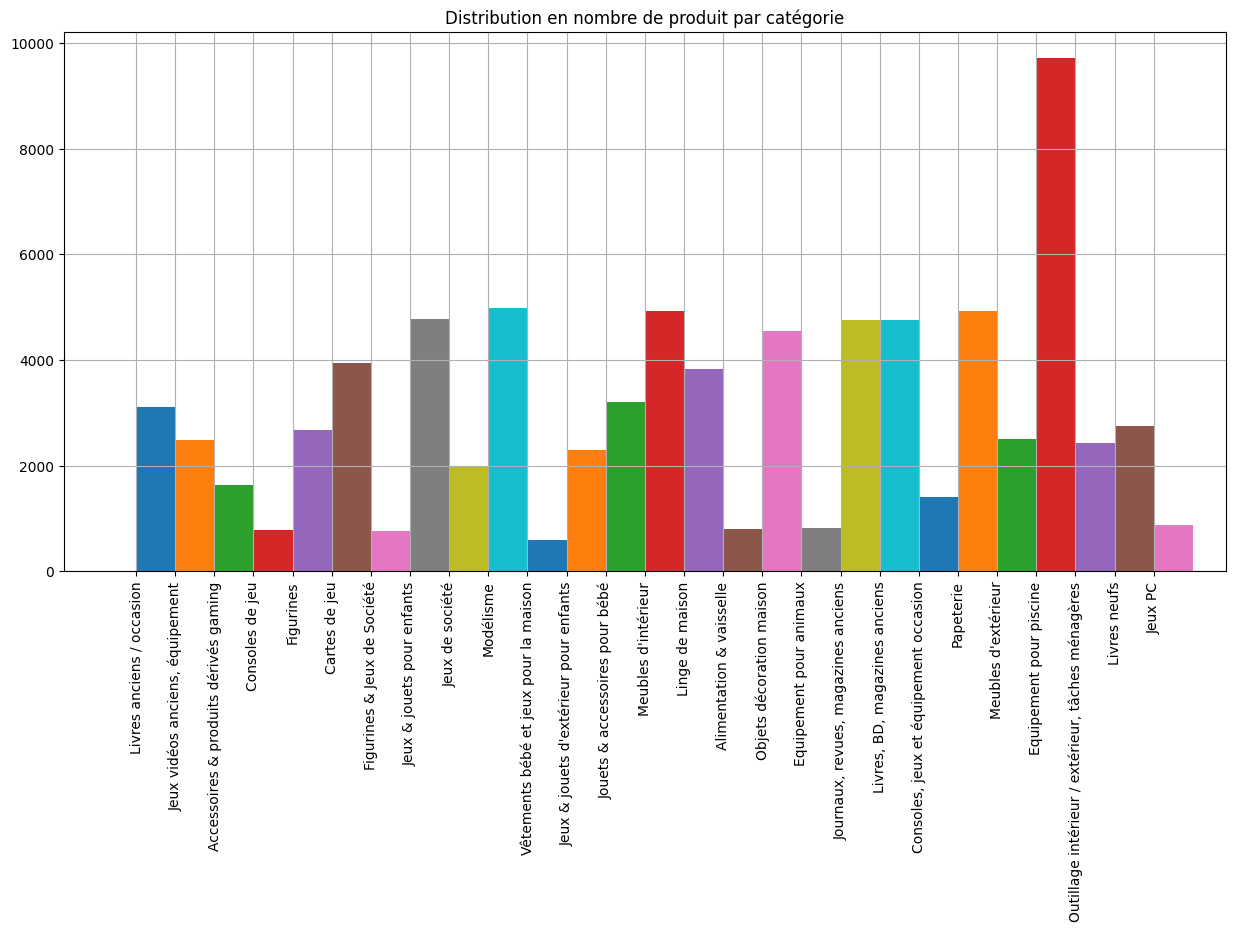

In [66]:
print(words_count_dataset.columns)
print(len(words_count_dataset.columns))
print(type(words_count_dataset))
display(words_count_dataset.head())
display(words_count_dataset['category_code'])


words_count_dataset.groupby(['category_code'])['prdtypelabelguess'].hist(grid=True, xrot='vertical', figsize=(15,7), width=1)
plt.title("Distribution en nombre de produit par catégorie")
plt.show()

>Merge cleanded data with nex dataframe containing data_prdtypecode_label_guess (libelé des catégories)

In [16]:
data_cleaned_with_prdtypelabel_guess=pd.merge(left=data_cleaned, left_on='prdtypecode', right=data_prdtypecode_label_guess, right_index=True )
display(data_cleaned_with_prdtypelabel_guess)

designation  \
0      Olivia: Personalisiertes Notizbuch / 150 Seite...   
6             Christof E: Bildungsprozessen Auf Der Spur   
46     Vassivière -En-Limousin.  Le Jardin Art Et Lie...   
131      Dr. Mercurius' Heilsame Reise Zum Planeten Erde   
188                                 La Promenade Au Parc   
...                                                  ...   
84114     Boîte de 144 craies Master Rouge-Tweeten Fibre   
84168  Descente de Balle Centrale Baby Foot Bonzini-B...   
84258  Billard Table Américain Noir7ft tapis Rouge-Su...   
84522            Housse Riley Noire Pour Queue 1/2-Riley   
84655   Boitier de Queue de Billard BCE Jonction 1/2-Bce   

                                             description   productid  \
0                                                    NaN  3804725264   
6                                                    NaN    91920807   
46                                                   NaN   444108636   
131                                                  NaN  1807806498   
188                                                  NaN   125293048   
...                                                  ...         ...   
84114  Craies Master de couleur rouge.<br />Par boite...  1940778568   
84168      Conduit central intérieure baby foot Bonzini.   141192376   
84258  Billard Table Américain Noir 7ft tapis rouge.<...  2633735378   
84522  Longueur : 79 cm. Housse souple Noire. Pour qu...   457363125   
84655  Longueur de 87 cm. Rangement queue de billard ...   141190890   

          imageid  prdtypecode  \
0      1263597046           10   
6       907794536           10   
46     1010065513           10   
131    1204663650           10   
188     880172152           10   
...           ...          ...   
84114  1115204639         1301   
84168   893308885         1301   
84258  1161295971         1301   
84522  1012111114         1301   
84655   893310225         1301   

                                               desi_desc  \
0      olivia personalisiertes notizbuch seiten punkt...   
6                christof bildungsprozessen auf der spur   
46           vassivière limousin jardin art lieu mémoire   
131           mercurius heilsame reise zum planeten erde   
188                                       promenade parc   
...                                                  ...   
84114  boîte craies master rougetweeten fibre craies ...   
84168  descente balle centrale baby foot bonzinibonzi...   
84258  billard table américain noirft tapis rougesupr...   
84522  housse riley queue riley housse souple queue j...   
84655  boitier queue billard bce jonction bce rangeme...   

                           prdtypelabelguess  
0                  Livres anciens / occasion  
6                  Livres anciens / occasion  
46                 Livres anciens / occasion  
131                Livres anciens / occasion  
188                Livres anciens / occasion  
...                                      ...  
84114  Vêtements bébé et jeux pour la maison  
84168  Vêtements bébé et jeux pour la maison  
84258  Vêtements bébé et jeux pour la maison  
84522  Vêtements bébé et jeux pour la maison  
84655  Vêtements bébé et jeux pour la maison  

[84916 rows x 7 columns]

# D. Text data exploration

## D1. Distribution de la nouvelle variable desi_desc

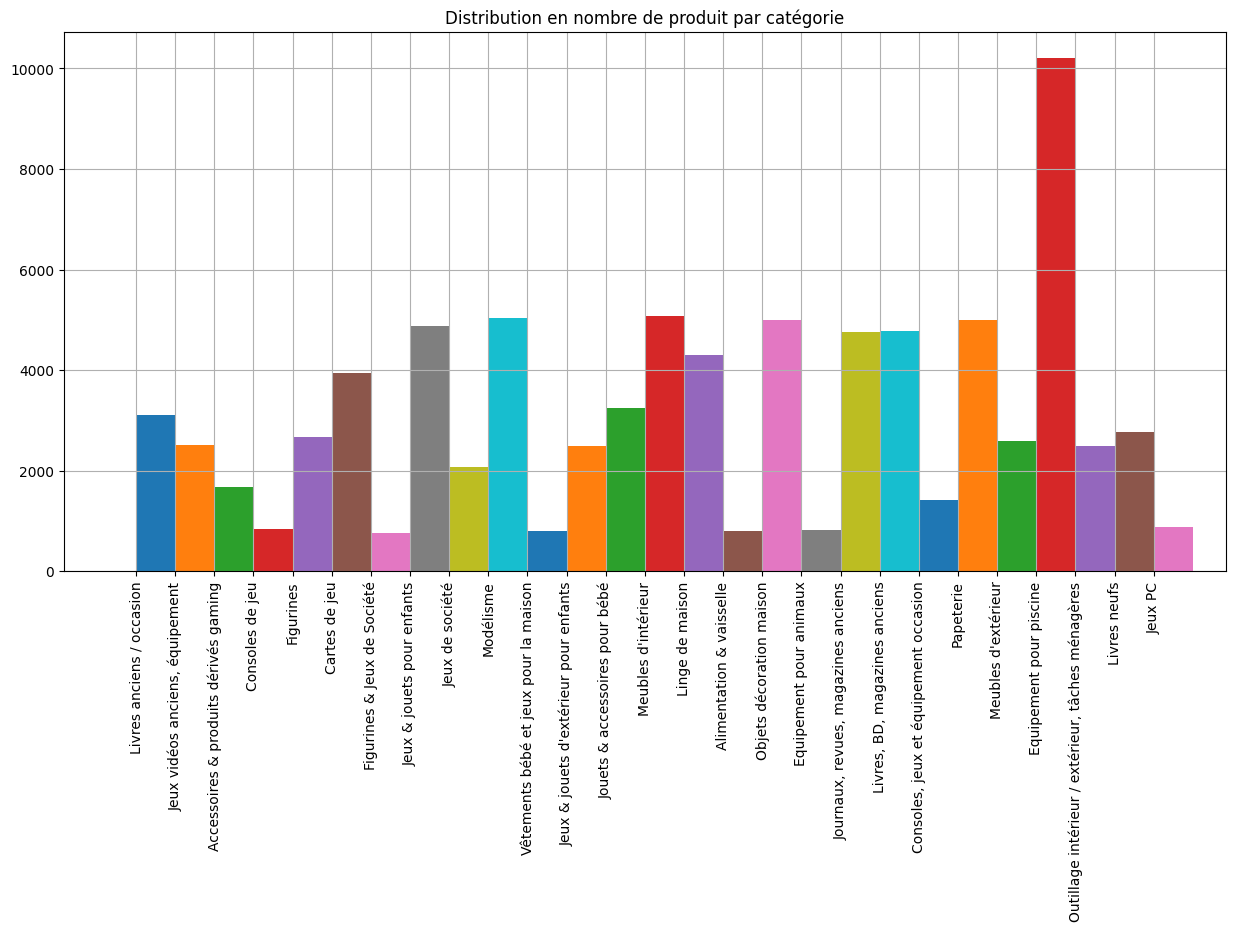

In [17]:

data_cleaned_with_prdtypelabel_guess.groupby(['prdtypecode'])['prdtypelabelguess'].hist(grid=True, xrot='vertical', figsize=(15,7), width=1)
plt.title("Distribution en nombre de produit par catégorie")
plt.show()

## D2. Vue globale : **Words cloud** de 'designation', 'description' et 'desi_desc' (combinaison de designation et description)

>Les cartographies des mots permettent d'une manière simple et efficace d'écarter tous les mots parasites qui n'apportent pas de valeur et d'information sur les variables descriptives (designation & description)

C:\Users\abdel\AppData\Local\Temp\ipykernel_4116\2811075144.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  wc.generate(all_designation_df[0])


(-0.5, 1199.5, 799.5, -0.5)

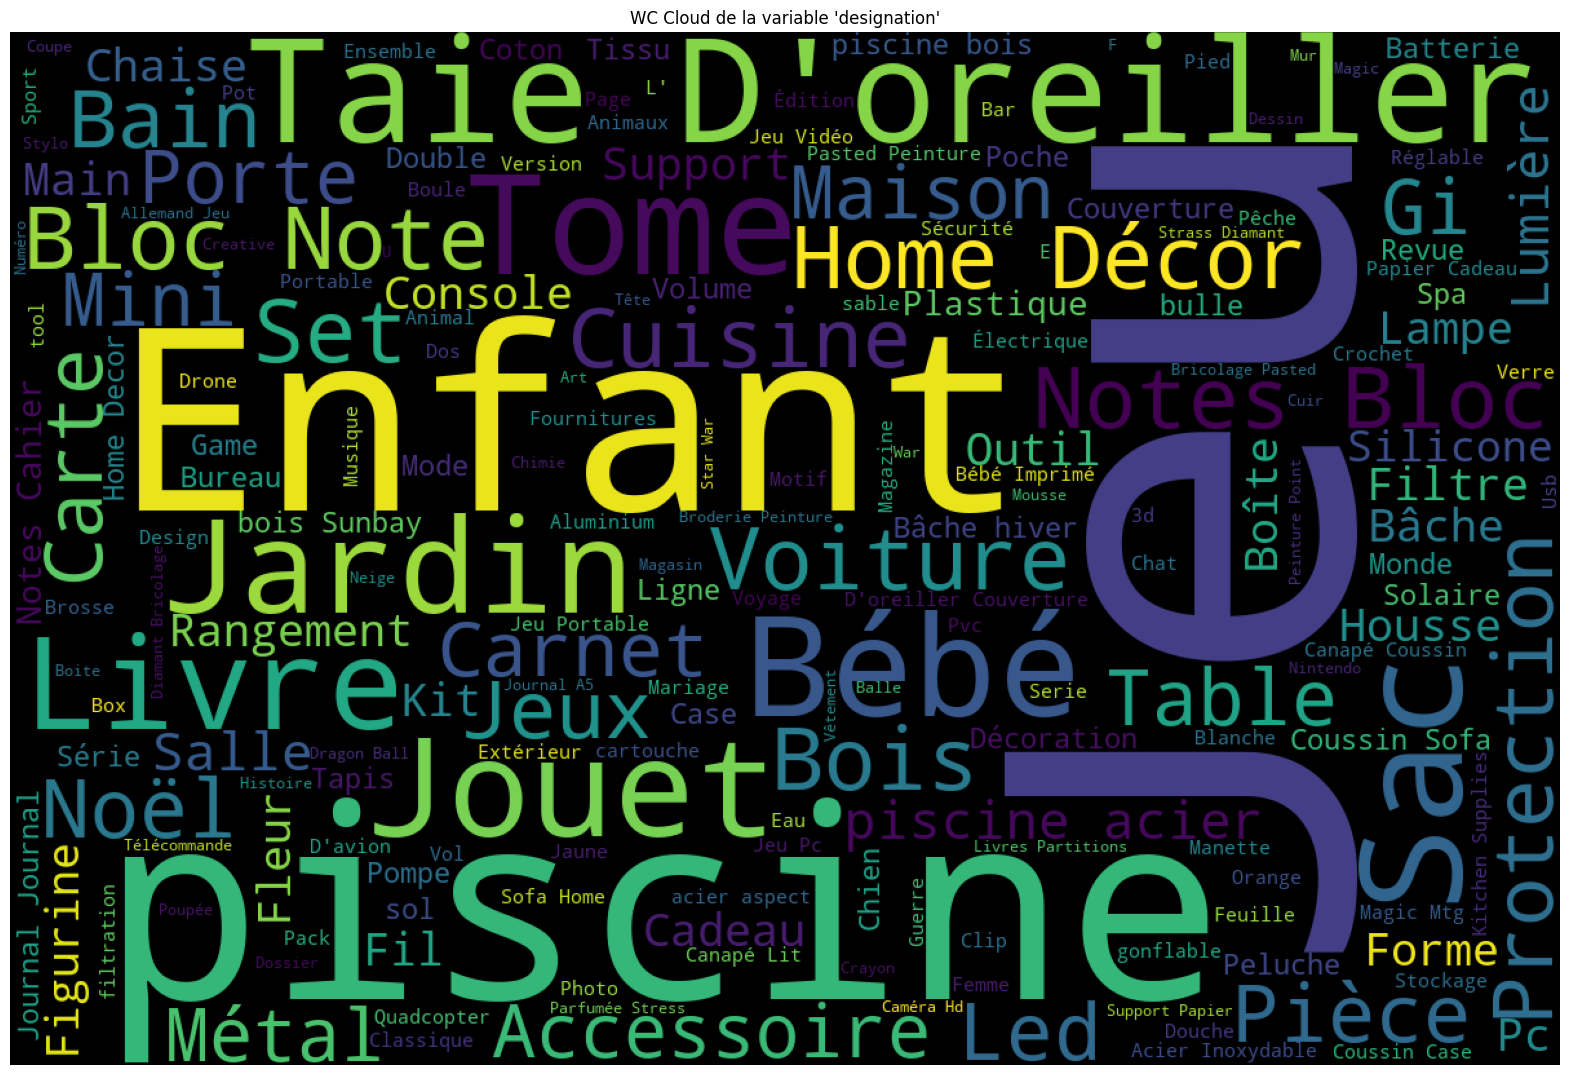

In [19]:
from wordcloud import WordCloud, STOPWORDS
#import nltk
# nltk.download()
from nltk.corpus import stopwords

# wc = WordCloud(width=1200, height=800)
my_stopwords = set(STOPWORDS).union(set(get_excluded_words(f'{data_root_folder}/config/excluded_words.txt')[0])).union(stopwords.words('french'))
wc = WordCloud(width=1200, height=800, stopwords= my_stopwords)
# make merge of all designation column content
all_designation_df = data_cleaned.iloc[:, 0:1].fillna('').apply(lambda x: "".join(x.astype(str)), axis=0)
#display("all_designation_df=", all_designation_df[0])

wc.generate(all_designation_df[0])
plt.figure(figsize=(20, 20))
plt.title("WC Cloud de la variable 'designation'")
plt.imshow(wc)
plt.axis('off')

**On note :**
>- Les **mots clés** se rapportent au type de l'article et non à ses fonctionnalités et carctéristiques en conformité avec la colonne qui porte le jeu de mots, à quelques exceptions près comme les **couleurs**, la **matière** etc.
>- Les 3 mots dominants **"Jeu", "Enfant", "piscine", "Sac" et "Tome"** etc. révèlent les types d'articles majoritaires dans le dataset que l'on peut quantifier. En particulier, les mots que l'on peut qualifier commmuns à plusieurs catégories indiquant un ensemble de caractéristiques, sont finalement sans trop d'importance.

C:\Users\abdel\AppData\Local\Temp\ipykernel_4116\1583795192.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  wc.generate(all_description_df[0])


(-0.5, 1199.5, 799.5, -0.5)

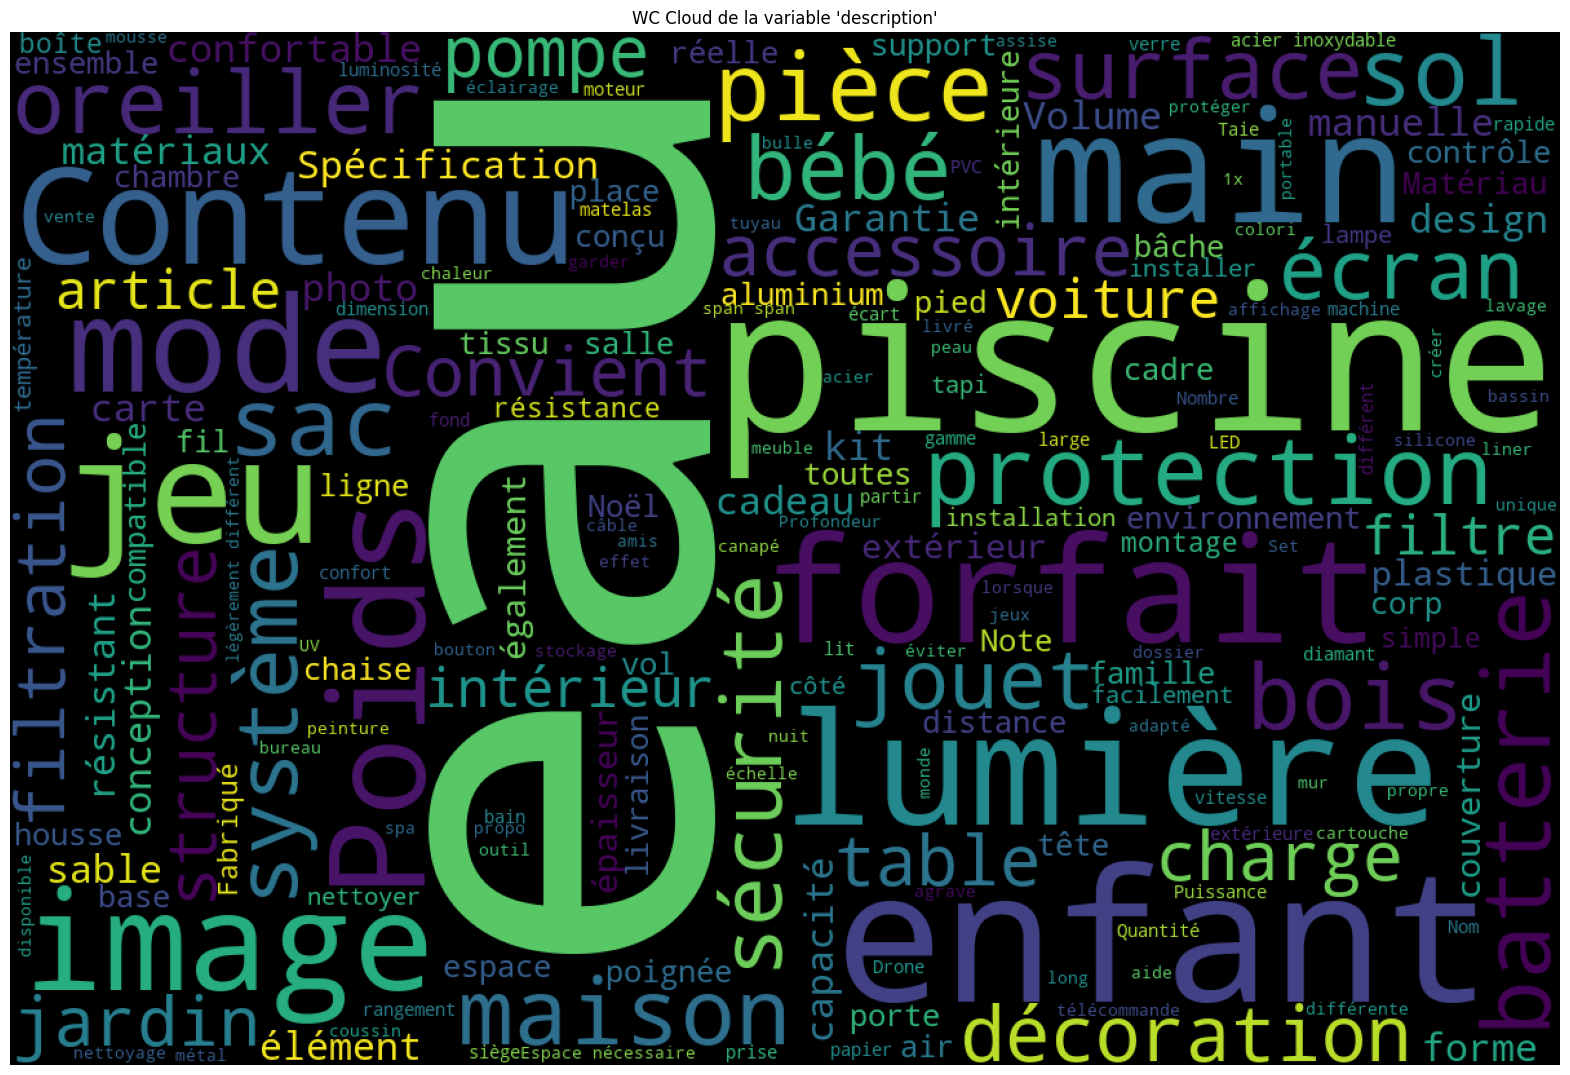

In [20]:
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords

wc = WordCloud(width=1200, height=800, stopwords= my_stopwords)

# make merge of all designation column content
all_description_df = data_cleaned.iloc[:, 1:2].fillna('').apply(lambda x: "".join(x.astype(str)), axis=0)
#display("all_designation_df=", all_designation_df[0])

wc.generate(all_description_df[0])
plt.figure(figsize=(20, 20))
plt.title("WC Cloud de la variable 'description'")
plt.imshow(wc)
plt.axis('off')

**On note :**
>- Les mots dominants porte plutôt sur le **descriptif**, les **caractéristiqus** et **fonctionnalités** des produits, comme les **dimensions**, les **couleurs**, **qualité**, **faciliés**, **à qui s'adresse ?**, l'**usage** etc.
>- Le mot **produit** est plutôt générique que l'on peut exclure
>- Le mot **eau** est particulier, car il peut se rapporter à plusieurs articles à la fois, comme les piscines, les outils qui utilisent ou traitent l'eau comme matière etc. 

Tous ces mots on été exclus via un fichier text avec d'autres et ne sont plus visibles !

C:\Users\abdel\AppData\Local\Temp\ipykernel_4116\1242765205.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  wc.generate(all_designation_df[0])


(-0.5, 1199.5, 799.5, -0.5)

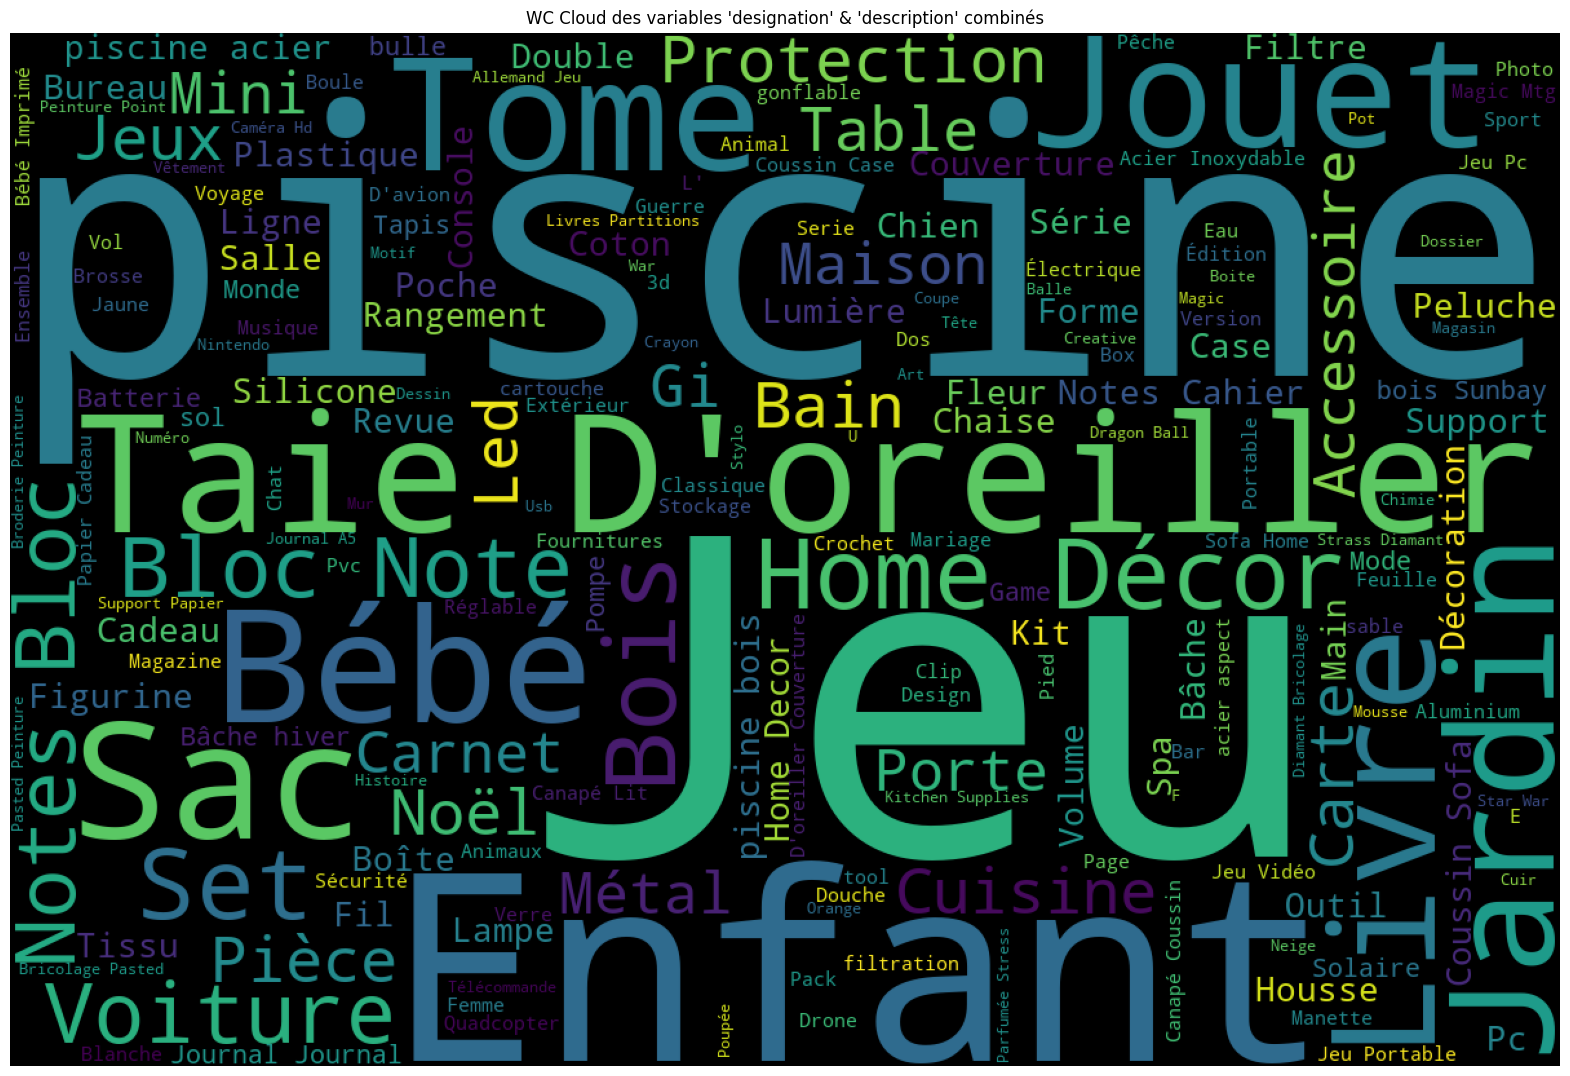

In [21]:
from wordcloud import WordCloud, STOPWORDS
#import nltk
# nltk.download()
from nltk.corpus import stopwords

# wc = WordCloud(width=1200, height=800)
my_stopwords = set(STOPWORDS).union(set(get_excluded_words(f'{data_root_folder}/config/excluded_words.txt')[0])).union(stopwords.words('french'))
wc = WordCloud(width=1200, height=800, stopwords= my_stopwords)
# make merge of all designation column content
all_desi_desc_df = data_cleaned.iloc[:, 3:-1].fillna('').apply(lambda x: "".join(x.astype(str)), axis=0)
#display("all_designation_df=", all_designation_df[0])

wc.generate(all_designation_df[0])
plt.figure(figsize=(20, 20))
plt.imshow(wc)
plt.title("WC Cloud des variables 'designation' & 'description' combinés")
plt.axis('off')

> On voit bien que cette carte reprend les mots importants des deux colonnes 'designation' et 'description' avec un equilibrage en termes d'importance, ce qui nous réconforte dans le choix de combiner les deux colonnes dans une 3ème colonne et ne travailler que sur cette dernière sur la partie texte 

> L'exclusion d'un nombre important de mots parasites n'apportant aucune valeur sémantique, a aussi apporté ses fruits

## D3. Analyse de la distribution de la nouvelle variable 'desi_desc' combinant la 'designation' et la 'desciption'

In [68]:
display(data_cleaned.head())

designation  \
0  Olivia: Personalisiertes Notizbuch /  Seiten /...   
1  Journal Des Arts (Le) N°  Du // - L'art Et Son...   
2  Grand Stylet Ergonomique Bleu Gamepad Nintendo...   
3  Peluche Donald - Europe - Disneyland  (Marionn...   
4                               La Guerre Des Tuques   

                                         description   productid     imageid  \
0                                                     3804725264  1263597046   
1                                                      436067568  1008141237   
2  PILOT STYLE Touch Pen de marque Speedlink est ...   201115110   938777978   
3                                                       50418756   457047496   
4  Luc a des id&eacute;es de grandeur. Il veut or...   278535884  1077757786   

   prdtypecode  
0           10  
1         2280  
2           50  
3         1280  
4         2705

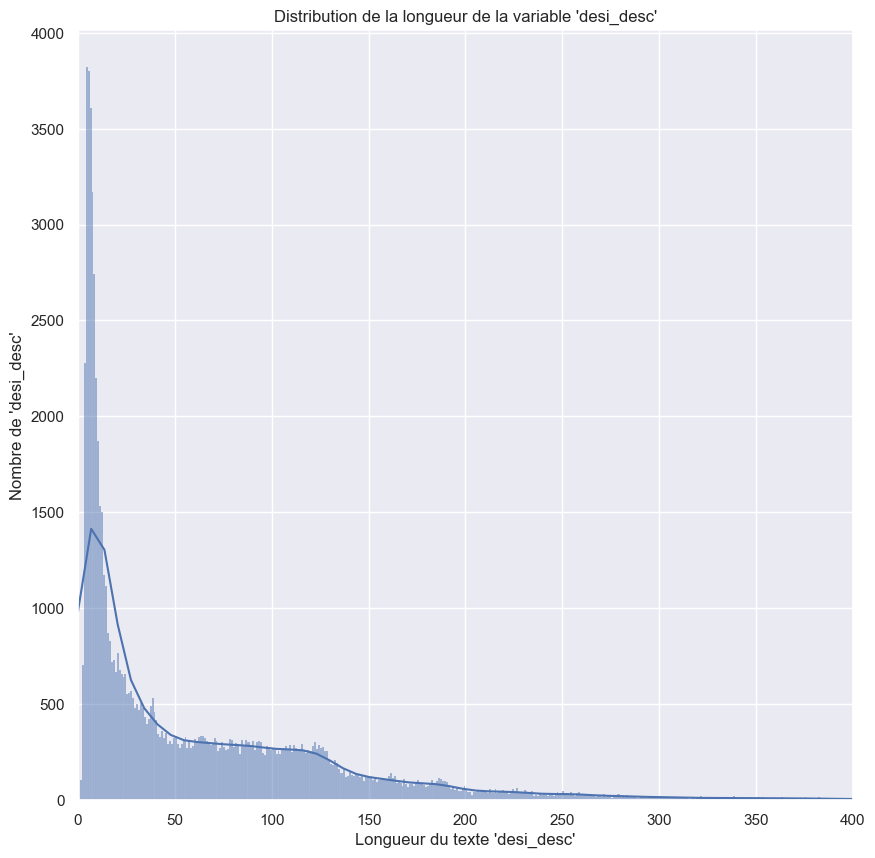

In [98]:
%matplotlib inline 

sns.set_theme(rc={'figure.figsize': (10, 10)})
fig, ax = plt.subplots(nrows= 1, ncols= 1)
g1 = sns.histplot(x=data_cleaned['desi_desc'].str.split().map(lambda x: len(x)), ax=ax, kde=True, bins=range(0,400))
#g2 = sns.histplot(y=data_cleaned['description'].str.split().map(lambda x: len(x)), ax=ax[1], kde= True)

ax.set_xlim(0,400)
plt.xlabel("Longueur du texte 'desi_desc'")
plt.ylabel("Nombre de 'desi_desc'")
plt.title("Distribution de la longueur de la variable 'desi_desc'")
plt.grid(True)
plt.show()           


<Axes: >

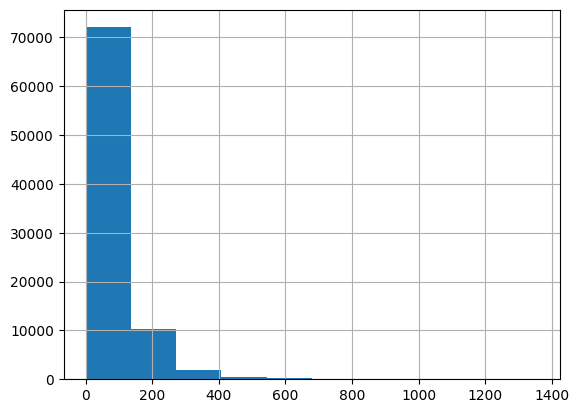

In [ ]:
data_cleaned['desi_desc'].str.split().map(lambda x: len(x)).hist()

'designation' range from 10 to 250 characters and generally, it is between 75 to 100 characters

<Axes: >

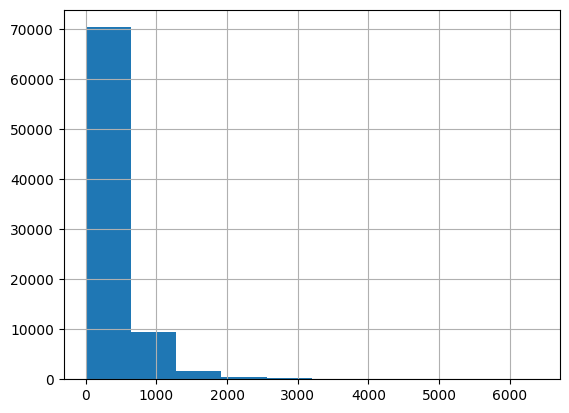

In [66]:
data_cleaned['desi_desc'].str.len().hist()

Number of words in designation ranges from 3 to 50 and mostly falls between 3 to 18 words.

d:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0        3.166667
6        3.666667
46       3.833333
131      3.428571
188      2.000000
           ...   
84114    4.300000
84168    5.428571
84258    3.258333
84522    2.833333
84655    3.500000
Name: desi_desc, Length: 82265, dtype: float64

Quartiles de la moyenne des longueurs de la colonne 'desi_desc' obtenus  Q1, Q2, Q3, Q4 = 2.7222222222222223 3.066666666666667 3.4 14.5
IQR = 0.6777777777777776
Indicateur de dispertion supérieur : 4.416666666666666
Indicateur de dispertion inférieur : 1.705555555555556


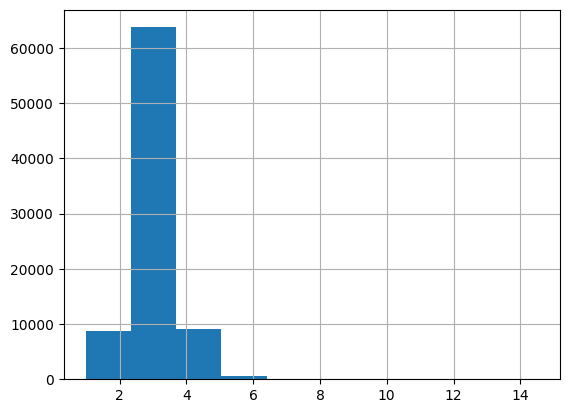

In [56]:
data_design_desc_len_mean = data_cleaned_with_prdtypelabel_guess['desi_desc'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
display(data_design_desc_len_mean)
data_design_desc_len_mean.hist()

Q1, Q2, Q3, Q4 = data_design_desc_len_mean.quantile(q=[.25, .50, .75, 1])
print("Quartiles de la moyenne des longueurs de la colonne 'desi_desc' obtenus  Q1, Q2, Q3, Q4 =", Q1, Q2, Q3, Q4 )

IQR = Q3 - Q1
print("IQR =", IQR) 

Q_max = Q3 + 1.5*IQR
print("Indicateur de dispertion supérieur :", Q_max)

Q_min = Q1 - 1.5*IQR
print("Indicateur de dispertion inférieur :", Q_min)

#print(data_cleaned_with_prdtypelabel_guess.columns)


The average word length ranges between 2 to 8 with 5 being the most common length

QUARTILES for 'designation_length':
Q1, Q2, Q3, Q4  =  43.0 63.0 90.0 250.0
IQR = 47.0
Indicateur de dispertion supérieur : 160.5
Indicateur de dispertion inférieur : -27.5

QUARTILES for 'description_length':
Q1, Q2, Q3, Q4  =  3.0 210.0 794.0 12451.0
IQR = 791.0
Indicateur de dispertion supérieur : 1980.5
Indicateur de dispertion inférieur : -1183.5


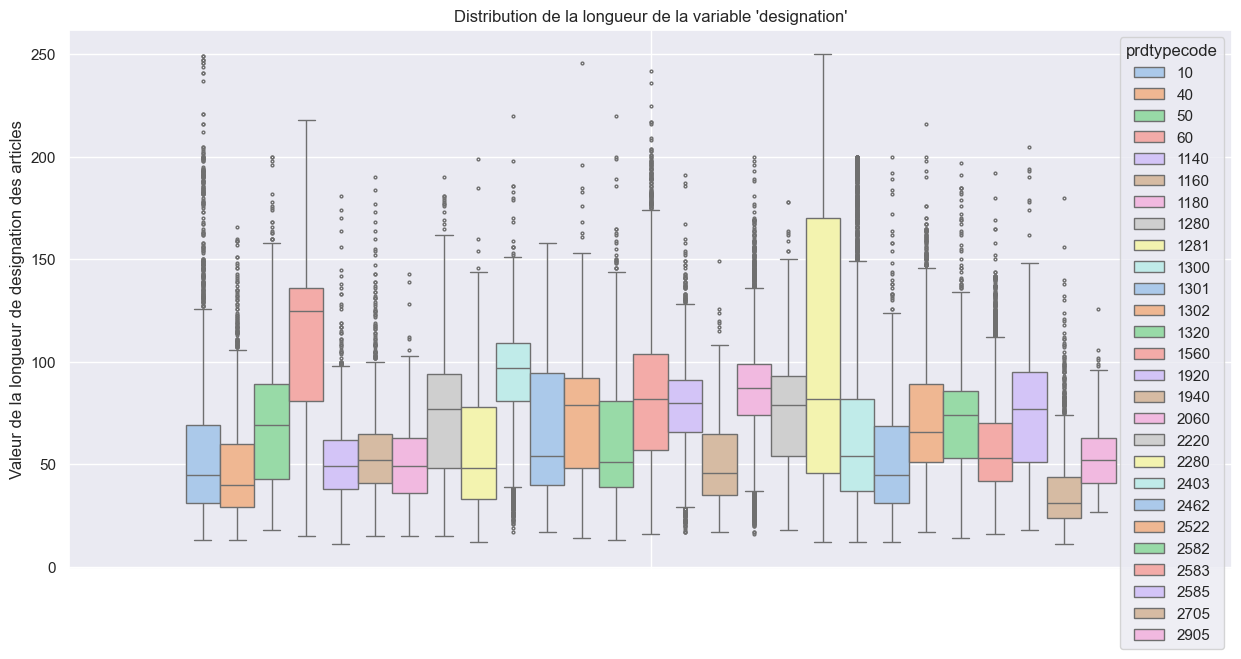

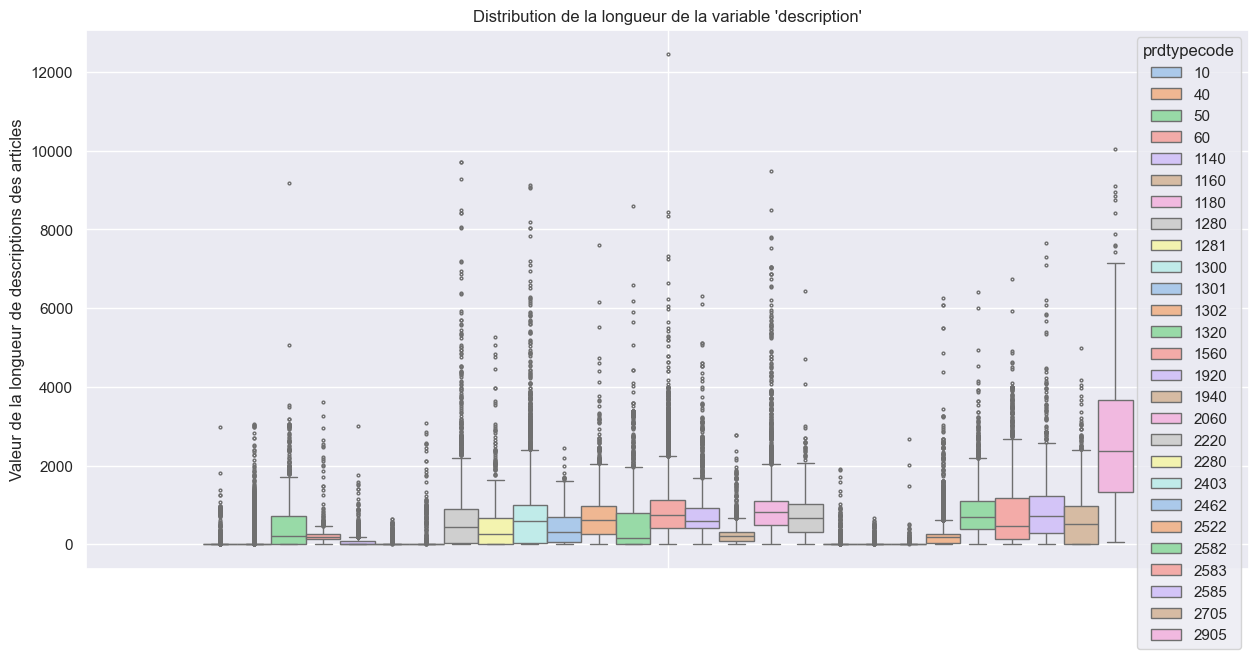

In [57]:
data_byprdtype_length=data
data_byprdtype_length['designation_length'] = data_byprdtype_length['designation'].apply(lambda x: len(str(x)))
data_byprdtype_length['description_length'] = data_byprdtype_length['description'].apply(lambda x: len(str(x)))

print("QUARTILES for 'designation_length':\n===========================================")
Q1, Q2, Q3, Q4 = data_byprdtype_length['designation_length'].quantile(q=[.25, .5, .75, 1.0])
print("Q1, Q2, Q3, Q4  = ", Q1, Q2, Q3, Q4 )

IQR = Q3 - Q1
print("IQR =", IQR) 

Q_max = Q3 + 1.5*IQR
print("Indicateur de dispertion supérieur :", Q_max)

Q_min = Q1 - 1.5*IQR
print("Indicateur de dispertion inférieur :", Q_min)

print("\nQUARTILES for 'description_length':\n===========================================")
Q1, Q2, Q3, Q4 = data_byprdtype_length['description_length'].quantile(q=[.25, .5, .75, 1.0])
print("Q1, Q2, Q3, Q4  = ", Q1, Q2, Q3, Q4 )

IQR = Q3 - Q1
print("IQR =", IQR) 

Q_max = Q3 + 1.5*IQR
print("Indicateur de dispertion supérieur :", Q_max)

Q_min = Q1 - 1.5*IQR
print("Indicateur de dispertion inférieur :", Q_min)



sns.set_theme(rc={'figure.figsize': (15, 7)})
fig, ax = plt.subplots(nrows= 1, ncols= 1)
g1 = sns.boxplot(data=data_byprdtype_length,  y= 'designation_length', ax=ax, hue='prdtypecode', gap=2, fliersize=2, palette='pastel')
plt.ylabel('Valeur de la longueur de designation des articles')
plt.title("Distribution de la longueur de la variable 'designation'")
plt.grid(True)
plt.show()  


fig, ax = plt.subplots(nrows= 1, ncols= 1)
g2 = sns.boxplot(data=data_byprdtype_length,  y= 'description_length', ax=ax, hue='prdtypecode', gap=2, fliersize=2, palette='pastel')
plt.ylabel('Valeur de la longueur de descriptions des articles')
plt.title("Distribution de la longueur de la variable 'description'")
plt.grid(True)
plt.show()           


>- **description**: beaucoup d'outliers supérieurs à Q3, la majorté ne dépasse pas les 1000 de longeur (à l'exceptio de la cat n° 2905, jeux videos/PC) qui a moins d'outiliers que le reste des catégories

>- **designation**: la catégorie coddée **1281** semble être la seule qui ne possède pas d'outliers ni inliers; il suffit d'examiner à quel type d'articles est associée (catégorie descriptive : 'Jeux de société') ?

>- Le calcul des quartiles, montre que la variable 'description' possèdent un Q3 et Q4 assez élevés par rapport au champ 'designation' indiquant ainsi une richesse très importante en termes de nombre de mots utilisés dans la description

*Il faut aller plus loin et examiner les mots que ces deux colonnes contiennent, faire une analyse sémantique, statistique et voir si une corrélation existe entre ces deux champs ?*

# E. **1ères expérimentations de modélisation**

## E1. Fonctions communes de support

### E1.1 Helper functions

In [18]:
def load_data(from_csv=True, csv_file_path='.', dataframe=None):
    df = None
    csv_source = from_csv and True
    if csv_source == True:
        # read produced CSV OR
        df = pd.read_csv(csv_file_path, sep=',', index_col=0)
    else:
        if isinstance(dataframe, pd.DataFrame):
            df = dataframe
    return df


def define_X_target(dataframe=pd.DataFrame(None), columns_to_drop_from_X=[], target_column=''):
    if isinstance( dataframe, pd.DataFrame):
        X = df.drop(columns_to_drop_from_X, axis = 1)
        target = df[target_column]
    return X, target 
        

def get_train_test_split(X, y, test_size=.2, random_state=0, scale=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    if scale == True:
        scaler = preprocessing.StandardScaler()
        # apply the scaler to X_train by transform method to get X_train_scaled
        X_train = pd.DataFrame( scaler.fit_transform(X_train) )
        X_test = pd.DataFrame( scaler.transform(X_test) )

    return  X_train, X_test, y_train, y_test    
    

def get_X_with_weak_features_variation(X, dev_threshold=1):
    
    sel = VarianceThreshold(threshold=dev_threshold)
    sel.fit(X)

    # get mask returned by sel to see which features have been deselected
    mask = sel.get_support()
    false_mask = mask[mask==False]
    display(false_mask)
    print("number of words with weak variance:", len(false_mask))

    # get the list of features with weak variance
    list_words_good_variance = X.columns[mask]
    print("words to keep :")
    display(list_words_good_variance)

    # corresponding variance array
    words_good_variance = np.var( X[X.columns[mask]], axis=0 )
    print("words to keep variance :")
    display(words_good_variance)

    
    return X[X.columns[mask]]
    


def get_conf_matrix(y_test, y_pred, xlabel, ylabel, target, title): 
    print("============================CONFUSION MATRIX=======================================") 
    print("Use SEABORN to draw confusion_matrix-----------------------------------------------") 
    #Use the confusion matrix of sklearn.metrics 
    print("Confusion matrix as graph with Seaborn :") 
    plt.figure(figsize=(15,15))  
    sns.heatmap(data=pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=y_pred)), 
                annot=True, cmap='Blues', xticklabels= sorted(target.unique()), yticklabels= sorted(target.unique()), cbar=False,  
                square=True, fmt=".0f") 
    plt.xlabel(xlabel) 
    plt.ylabel(ylabel) 
    plt.title(title) 
    plt.show() 


def roc_auc_curve(y_test, y_probas, title ):
    """
    Plot ROC-AUC curve () : Receiver Operating Characteristic) - Area Under the Curve
    """
    if title == '':
        title = 'courbe ROC-AUC'
    skplt.metrics.plot_roc(y_test, y_probas, title=title, figsize=(20,20))
    plt.show()


def plot_cumulative_gain(y_test, y_probas, title ):
    """
    Plot cumulative gains
    """
    plt.figure(figsize=(12,8))
    if title == '':
        title = 'Courbe des gains cumulatifs cumulés'
    plot_cumulative_gain(y_test, y_probas, title= title) 
    plt.ylim(0, 1.01) 
    plt.show()
    plt.show()   


def get_pobas(estimator, X_test):
    probas = estimator.predict_proba(X_test)
    print(f'{estimator} :\n {probas}')
    return probas

### E1.2 Load dataframe from CVS or from DataFrame

In [42]:
print(words_count_dataset.shape)

(82265, 8102)


In [19]:

# passer from_csv = False, évite de charger le csv qui peut être volumneux, passer dans ce cas words_count_dataset
load_from_csv = False
df = load_data(from_csv=load_from_csv, csv_file_path= f'{data_root_folder}/words_count_dataset.csv', dataframe=words_count_dataset)


In [44]:
print(df.columns)

Index(['actes', 'action', 'adventures', 'afrique', 'age', 'allemand',
       'america', 'american', 'amis', 'ammareal',
       ...
       'écran_x', 'édition_x', 'également_x', 'éléments_x', 'énigmes',
       'équipe', 'équivalent', 'événements', 'île', 'prdtypelabelguess'],
      dtype='object', length=8102)


### E1.3 Get dataset dataframe basic infos

In [85]:
# get_df_basic_elements(df= words_count_dataset, infos_types=['shape', 'head', 'tail', 'info', 'describe'], actions=['print'])

get_df_basic_elements(df= df, infos_types=['shape', 'head', 'tail', 'info', 'describe'], actions=['print'])

shape------------------------------------------------------
(84916, 2701)
head------------------------------------------------------


ammareal  ancien  année  ans  art  associations  auteur  bibliothèque  \
0       0.0     0.0    0.0  0.0  0.0           0.0     0.0           0.0   
1       0.0     0.0    0.0  0.0  0.0           0.0     0.0           0.0   
2       0.0     0.0    0.0  0.0  1.0           0.0     0.0           0.0   
3       0.0     0.0    0.0  0.0  0.0           0.0     0.0           0.0   
4       0.0     0.0    0.0  0.0  0.0           0.0     0.0           0.0   

   bibliothèques  bon  ...  téléchargementnote  télécharger  utiliser_x.11  \
0            0.0  0.0  ...                 0.0          0.0            0.0   
1            0.0  0.0  ...                 0.0          0.0            0.0   
2            0.0  0.0  ...                 0.0          0.0            0.0   
3            0.0  0.0  ...                 0.0          0.0            0.0   
4            0.0  0.0  ...                 0.0          0.0            0.0   

   valide  version_x.3  vidéo_x.4  vista  vive  windows   xp  
0     0.0          0.0        0.0    0.0   0.0      0.0  0.0  
1     0.0          0.0        0.0    0.0   0.0      0.0  0.0  
2     0.0          0.0        0.0    0.0   0.0      0.0  0.0  
3     0.0          0.0        0.0    0.0   0.0      0.0  0.0  
4     0.0          0.0        0.0    0.0   0.0      0.0  0.0  

[5 rows x 2701 columns]

tail------------------------------------------------------


ammareal  ancien  année  ans  art  associations  auteur  bibliothèque  \
84911       0.0     0.0    0.0  0.0  0.0           0.0     0.0           0.0   
84912       0.0     0.0    0.0  0.0  0.0           0.0     0.0           0.0   
84913       0.0     0.0    0.0  0.0  0.0           0.0     0.0           0.0   
84914       0.0     0.0    0.0  0.0  0.0           0.0     0.0           0.0   
84915       0.0     0.0    0.0  0.0  0.0           0.0     0.0           0.0   

       bibliothèques  bon  ...  téléchargementnote  télécharger  \
84911            0.0  0.0  ...                 0.0          0.0   
84912            0.0  0.0  ...                 0.0          0.0   
84913            0.0  0.0  ...                 0.0          0.0   
84914            0.0  0.0  ...                 0.0          0.0   
84915            0.0  0.0  ...                 0.0          1.0   

       utiliser_x.11  valide  version_x.3  vidéo_x.4  vista  vive  windows  \
84911            0.0     0.0          0.0        0.0    2.0   0.0      2.0   
84912            0.0     0.0          1.0        1.0    0.0   0.0      2.0   
84913            0.0     0.0          0.0        0.0    1.0   0.0      0.0   
84914            0.0     0.0          0.0        0.0    0.0   0.0      0.0   
84915            1.0     0.0          0.0        0.0    0.0   0.0      1.0   

        xp  
84911  2.0  
84912  0.0  
84913  1.0  
84914  0.0  
84915  0.0  

[5 rows x 2701 columns]

<class 'pandas.core.frame.DataFrame'>
Index: 84916 entries, 0 to 84915
Columns: 2701 entries, ammareal to xp
dtypes: float64(2700), int64(1)
memory usage: 1.7 GB
info------------------------------------------------------


None

describe------------------------------------------------------


ammareal        ancien         année           ans           art  \
count  84916.000000  84916.000000  84916.000000  84916.000000  84916.000000   
mean       0.000942      0.000330      0.000718      0.000271      0.000624   
std        0.043125      0.018793      0.027658      0.019105      0.030106   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        2.000000      2.000000      2.000000      3.000000      4.000000   

       associations        auteur  bibliothèque  bibliothèques           bon  \
count   84916.00000  84916.000000  84916.000000   84916.000000  84916.000000   
mean        0.00053      0.000565      0.000342       0.000495      0.000589   
std         0.02352      0.023769      0.018477       0.022234      0.024259   
min         0.00000      0.000000      0.000000       0.000000      0.000000   
25%         0.00000      0.000000      0.000000       0.000000      0.000000   
50%         0.00000      0.000000      0.000000       0.000000      0.000000   
75%         0.00000      0.000000      0.000000       0.000000      0.000000   
max         2.00000      1.000000      1.000000       1.000000      1.000000   

       ...  téléchargementnote   télécharger  utiliser_x.11        valide  \
count  ...        84916.000000  84916.000000   84916.000000  84916.000000   
mean   ...            0.002673      0.003156       0.007454      0.003509   
std    ...            0.051634      0.056509       0.094871      0.059136   
min    ...            0.000000      0.000000       0.000000      0.000000   
25%    ...            0.000000      0.000000       0.000000      0.000000   
50%    ...            0.000000      0.000000       0.000000      0.000000   
75%    ...            0.000000      0.000000       0.000000      0.000000   
max    ...            1.000000      2.000000       4.000000      1.000000   

        version_x.3     vidéo_x.4         vista          vive      windows  \
count  84916.000000  84916.000000  84916.000000  84916.000000  84916.00000   
mean       0.005759      0.005664      0.003816      0.003144      0.02466   
std        0.115163      0.121342      0.077708      0.103188      0.35601   
min        0.000000      0.000000      0.000000      0.000000      0.00000   
25%        0.000000      0.000000      0.000000      0.000000      0.00000   
50%        0.000000      0.000000      0.000000      0.000000      0.00000   
75%        0.000000      0.000000      0.000000      0.000000      0.00000   
max        8.000000      6.000000      4.000000      6.000000     18.00000   

                 xp  
count  84916.000000  
mean       0.004051  
std        0.082689  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        5.000000  

[8 rows x 2701 columns]

{'data': {'shape': '', 'head': '', 'tail': '', 'info': '', 'describe': ''}}

### E1.4 Modifier les types des données des colonnes pour prendre moins de mémoire tampon

In [20]:
# modifie all columns data type to int 
for col in df.columns:
    if not col in ['prdtypelabelguess']:
        df[col] = df[col].astype(int) 
print(df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 82265 entries, 0 to 82264
Columns: 8102 entries, actes to prdtypelabelguess
dtypes: int32(8101), object(1)
memory usage: 2.5+ GB
None


### E1.5 Définir X, target et générer X_train, X_test, y_train, y_test

#### E1.5.1 Définir X & target

In [29]:
X, target = define_X_target(df, ['category_code', 'prdtypelabelguess'], 'category_code')
print("X.shape=", X.shape)
print("target.shape=", target.shape)


#X = df.drop(['category_code'], axis = 1)
#target = df['category_code']    

X.shape= (82265, 8100)
target.shape= (82265,)


#### E1.2.1 Test de reduction des features basée sur le seuil des variances des words (threshold)

>set threshold value and test - ***Les résultats obtenus basé sur le seuil de variance, ne sont pas concluants - à abandonner***

In [22]:
# display(X.describe())
THRESHOLD = 0.04
new_X = get_X_with_weak_features_variation(X, dev_threshold=THRESHOLD)
X = new_X
print("X.shape=", X.shape)
print("target.shape=", target.shape)
display(X)
print(type(X))
print(type(target))


array([False, False, False, ..., False, False, False])

number of words with weak variance: 7898
words to keep :


Index(['charge_x', 'console_x', 'jeu_x', 'nintendo_x', 'batterie_x', 'bois_x',
       'bébé', 'cadeau_x', 'drone', 'enfant_x',
       ...
       'disque_x', 'espace_x', 'ghz_x', 'intel', 'jeu_x', 'mémoire_x',
       'processeur_x', 'ram_x', 'système_x', 'windows_x'],
      dtype='object', length=202)

words to keep variance :


charge_x     0.044236
charge_x     0.000729
charge_x     0.000267
charge_x     0.000146
charge_x     0.029228
               ...   
système_x    0.013437
système_x    0.000984
système_x    0.051094
windows_x    0.001677
windows_x    0.122795
Length: 1200, dtype: float64

X.shape= (82265, 1200)
target.shape= (82265,)


charge_x  charge_x  charge_x  charge_x  charge_x  charge_x  charge_x  \
0             0         0         0         0         0         0         0   
1             0         0         0         0         0         0         0   
2             0         0         0         0         0         0         0   
3             0         0         0         0         0         0         0   
4             0         0         0         0         0         0         0   
...         ...       ...       ...       ...       ...       ...       ...   
82260         0         0         0         0         0         0         0   
82261         0         0         0         0         0         0         0   
82262         0         0         0         0         0         0         0   
82263         0         0         0         0         0         0         0   
82264         0         0         0         0         0         0         0   

       charge_x  charge_x  charge_x  ...  système_x  système_x  système_x  \
0             0         0         0  ...          0          0          0   
1             0         0         0  ...          0          0          0   
2             0         0         0  ...          0          0          0   
3             0         0         0  ...          0          0          0   
4             0         0         0  ...          0          0          0   
...         ...       ...       ...  ...        ...        ...        ...   
82260         0         0         0  ...          0          0          0   
82261         0         0         0  ...          0          0          0   
82262         0         0         0  ...          0          0          0   
82263         0         0         0  ...          0          0          0   
82264         0         0         0  ...          0          0          0   

       système_x  système_x  système_x  système_x  système_x  windows_x  \
0              0          0          0          0          0          0   
1              0          0          0          0          0          0   
2              0          0          0          0          0          0   
3              0          0          0          0          0          0   
4              0          0          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
82260          0          0          0          0          1          0   
82261          0          0          0          0          1          0   
82262          0          0          0          0          0          0   
82263          0          0          0          0          0          0   
82264          0          0          0          0          0          0   

       windows_x  
0              0  
1              0  
2              0  
3              0  
4              0  
...          ...  
82260          2  
82261          2  
82262          0  
82263          0  
82264          2  

[82265 rows x 1200 columns]

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


MemoryError: Unable to allocate 1.26 MiB for an array with shape (82265, 2) and data type float64

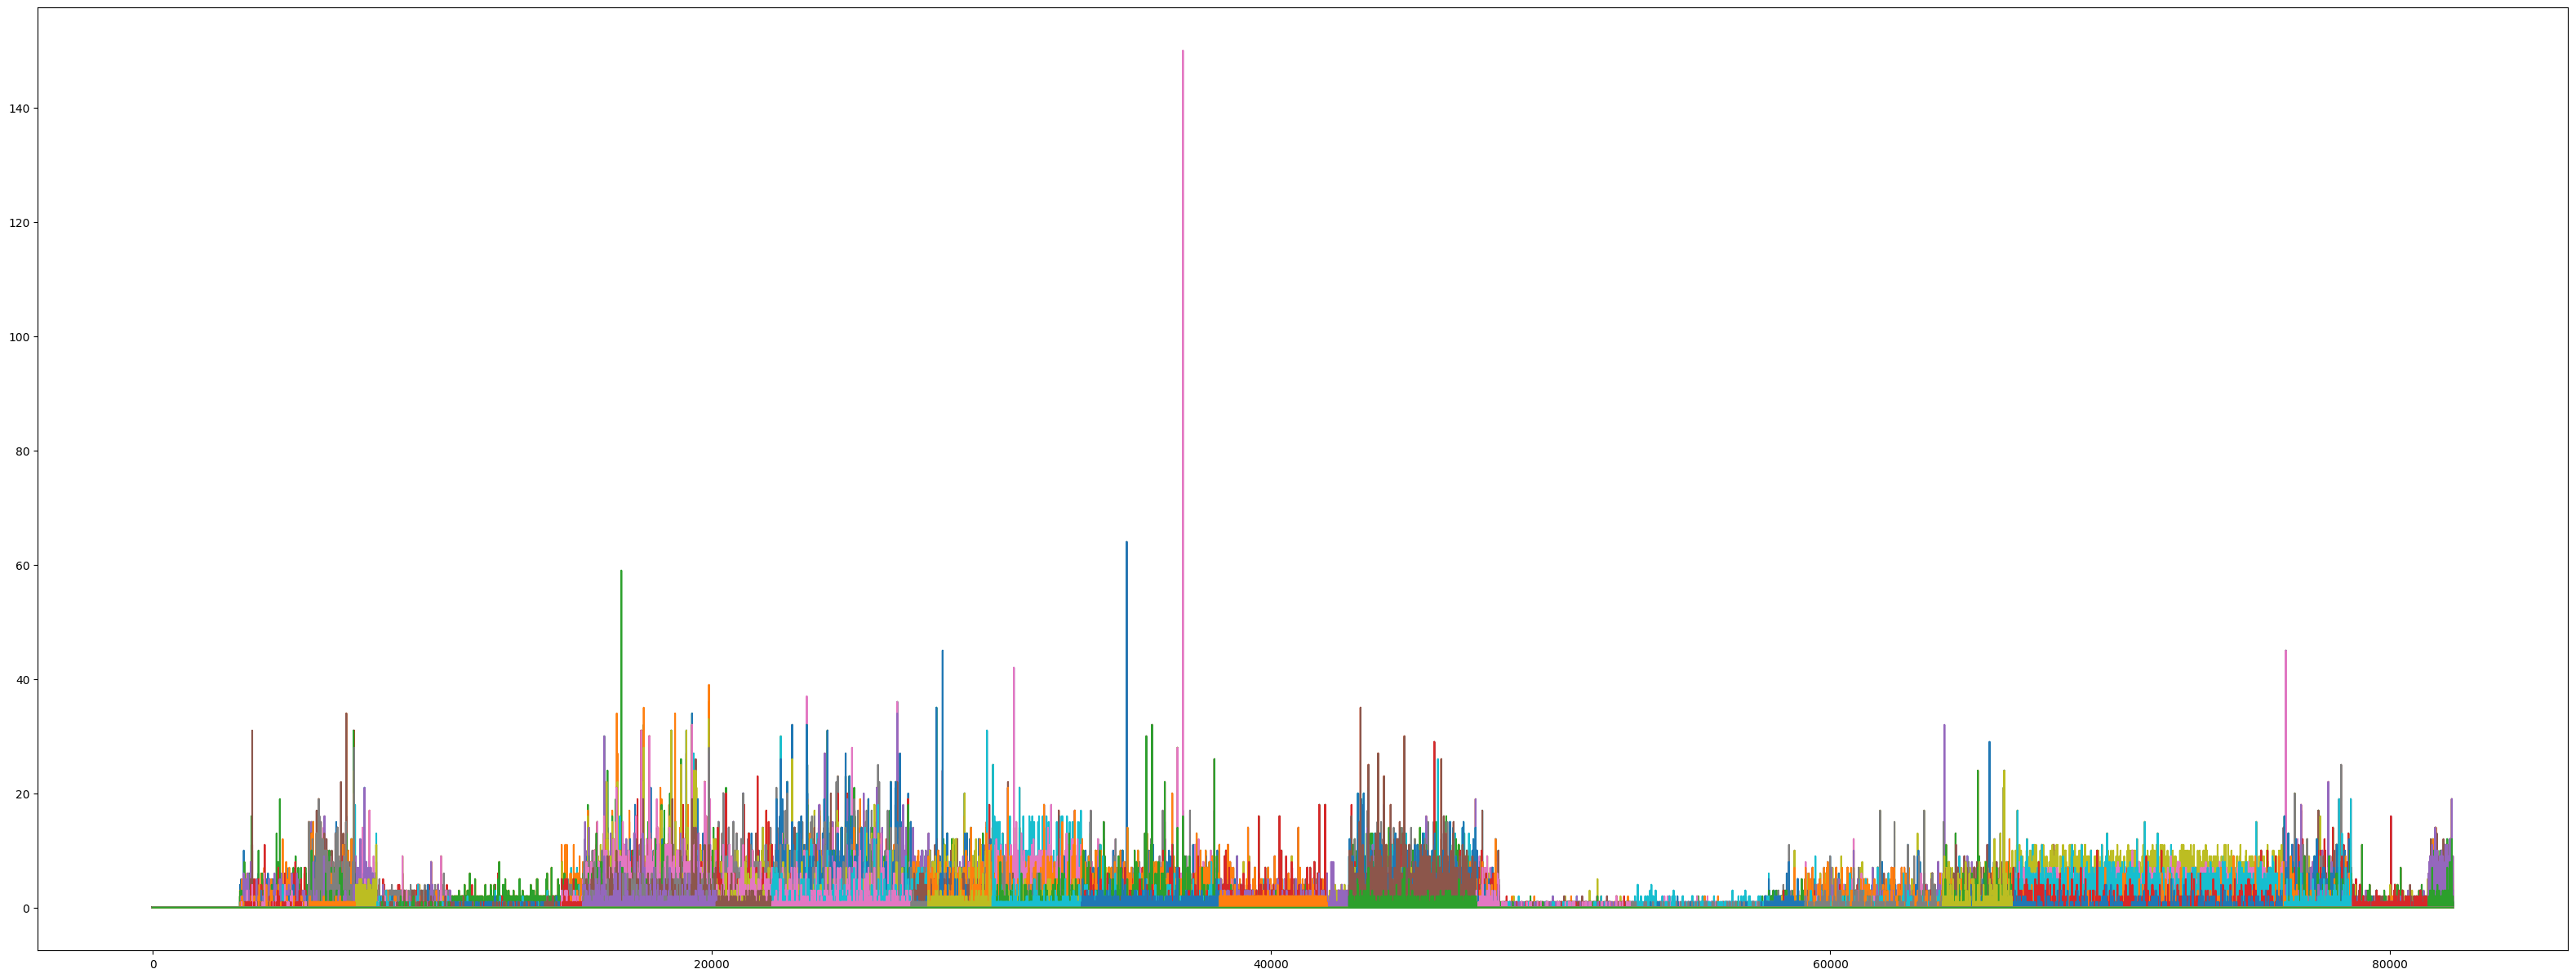

In [62]:

# plot variances graph
X.plot(grid=True, figsize=(40, 15))
plt.legend(loc='best')
plt.show()


#### E1.3 X_train, X_test, y_train, y_test

In [30]:
X_train, X_test, y_train, y_test = get_train_test_split(X=X, y=target, test_size=.2, random_state=0, scale=True)
print("X_train.shape=", X_train.shape)
print("X_test.shape=", X_test.shape)
print(type(X_train))
print(type(X_test))

X_train.shape= (65812, 8100)
X_test.shape= (16453, 8100)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


## E2. **GridSearchCV** : Simulation/Exécution des modèles

### E2.1 **GridSeachCV** simulation function 

In [34]:
#/////////////////////////////////////////////////
# create tuned model for one estimator at time
#/////////////////////////////////////////////////
def create_model_tuned(X_train, X_test, y_train, y_test, target, cv= 3, 
                       estimator_name='KNN', estimator=neighbors.KNeighborsClassifier(), params={'n_neighbors' : [10]}):
    # liste des valeurs des colonnes à reporter dans le DataFrame à retourner
    train_mse_results = []
    test_mse_results = []
    train_r2_scores = []
    test_r2_scores = []
    train_f1_score = []
    test_f1_score = []
    best_params = []
    
    
    print("\n-----------------------------------------------------------------------")
    print('X_train.shape - X_test.shape - len(y_train) - len(y_test)')
    print(f'{X_train.shape} - {X_test.shape} - {len(y_train)} - {len(y_test)}')
    
    print("\n-----------------------------------------------------------------------")
    print( pd.DataFrame.from_dict({
        'name':  f'{estimator_name}',
        'estimator': f'{estimator}',
        'params': f'{params}'
        }, orient='index') 
    )
    print("-----------------------------------------------------------------------\n")
    
    # on fixe cv à 3
    gs_best = GridSearchCV(estimator, params, cv=cv, n_jobs=-1, verbose= True).fit(X_train, y_train)

    final_model = estimator.set_params(**gs_best.best_params_).fit(X_train, y_train)

    train_r2_score = final_model.score(X_train, y_train)
    test_r2_score = final_model.score(X_test, y_test)
    train_r2_scores.append(train_r2_score)
    test_r2_scores.append(test_r2_score)

    print("train_r2_score = ", train_r2_score)
    print("test_r2_score =", test_r2_score)

    best_params.append(gs_best.best_params_)

    # afficher la matrice de confusion associée au modèle traité
    y_pred = final_model.predict(X_test)
    get_conf_matrix(y_test= y_test, y_pred= y_pred, xlabel='Valeurs réelles', ylabel="Valeurs prédites",
                    target= target , title="Matrice de confusion-" + estimator_name)

    y_train_pred = final_model.predict(X_train)
    y_test_pred = final_model.predict(X_test)
    
    # f1_score
    precision, recall, fscore, support = score(y_train, y_train_pred)
    train_f1_score.append(fscore)
    print(f'train_f1_score = {train_f1_score}')
    precision, recall, fscore, support = score(y_test, y_test_pred)
    test_f1_score.append(fscore)
    print(f'test_f1_score = {test_f1_score}')
    #train_f1_score.append(f1_score(y_true=y_train, y_pred=y_train_pred), pos_label='positive', average=None)
    #test_f1_score.append(f1_score(y_true=y_test, y_pred=y_test_pred), pos_label='positive', average=None)
    
    # MSE
    train_mse_result = mean_squared_error(y_train.astype(float), y_train_pred)
    test_mse_result = mean_squared_error(y_test.astype(float), y_test_pred)
    train_mse_results.append(train_mse_result)
    test_mse_results.append(test_mse_result)
    
    print("train_mse_result = ", train_mse_result)
    print("test_mse_result =", test_mse_result)
    
    print("best_params:", best_params)
    
    # fpr = False Positive rates, tps = true positive rates 
    #fpr, tpr, seuils = roc_curve(y_true=y_test, y_score= test_f1_score, pos_label=1) 
    # plot the roc_auc_curve
    roc_auc_curve(y_test=y_test, y_probas= final_model.predict_proba(X_test), title='Courbes ROC-AUC - ' + estimator_name) 
    #plot_cumulative_gain(y_test=y_test, y_probas= final_model.predict_proba(X_test), title='Courbes ROC-AUC - ' + estimator_name)
        
        
    model_tuned_results = pd.DataFrame({'Model_Name': estimator_name,
                                    'R2_score_Train': train_r2_scores,
                                    'R2_score_Test': test_r2_scores,
                                    'f1_score_Train': train_f1_score,
                                    'f1_score_Test': test_f1_score,
                                    'MSE_train': train_mse_results,
                                    'MSE_test': test_mse_results,
                                    "best_params": best_params
                                    }).set_index("Model_Name")
    model_tuned_results=model_tuned_results.sort_values(by="R2_score_Test", ascending=True)
  
    return model_tuned_results

In [32]:

# create tuned model for many estimators
def create_many_models_tuned(X_train, X_test, y_train, y_test, target, cv= 3, list_models = list(dict({'name': '', 'estimator': None, 'params': {} }))):
    
    """
    Examples :
    knn_params = {'n_neighbors' : np.arange(2, 500, 1)}
    
    svc_params = {'C': [0.05, 0.1, 0.2, 0.3, 0.5, 1.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0], 
                    'kernel': ['linear', 'sigmoid', 'rbf']}
    
    rf_params = {'max_features': ["sqrt", "log2", None],
                'min_samples_split': np.arange(2, 28, 1)}   # 27 code category
    
    elasticnet_params = {'l1_ratio': list(np.arange(0.0, 1.05, 0.05)),
                   'alpha': [0.01, 0.02, 0.05, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
                   }
    list_models = [ ("ELASTIC_NET", sklearn.linear_model.ElasticNetCV(), elasticnet_params ),
                  ("KNN", neighbors.KNeighborsClassifier(), knn_params),
                ("RF", ensemble.RandomForestClassifier(), rf_params),
                  ("SVC", svm.SVC(), svc_params)
                ]
    list_models = [("KNN", neighbors.KNeighborsClassifier(), knn_params),
                ("SVC", svm.SVC(), svc_params),
                ("RF", ensemble.RandomForestClassifier(), rf_params)]
    
    """
    model_tuned_results = pd.DataFrame({'Model_Names': '',
                                    'R2_score_Train': '',
                                    'R2_score_Test': '',
                                    'f1_score_Train': '',
                                    'f1_score_Test': '',
                                    'MSE_train': '',
                                    'MSE_test': '',
                                    "best_params": ''
                                    }, orient='index')
    if len(list_models) > 0:
      for model in list_models:
        m = create_model_tuned(X_train, X_test, y_train, y_test, target, cv=cv, 
                           estimator_name= model['name'], estimator= model['estimator'], params= model['params'])
        
        model_tuned_results = model_tuned_results.concat(
                            pd.DataFrame({'Model_Names': m['Model_Name'],
                                    'R2_score_Train': m['R2_score_Train'],
                                    'R2_score_Test': m['R2_score_Test'],
                                    'f1_score_Train': m['f1_score_Train'],
                                    'f1_score_Test': m['f1_score_Test'],
                                    'MSE_train': m['MSE_train'],
                                    'MSE_test': m['MSE_test'],
                                    "best_params": m['best_params']
                                    }), axis= 0
                            ).set_index("Model_Names")
    
    return model_tuned_results
    

### E2.2 Exécution des simulations

>Split et exécution

df.shape : (82265, 8102)


0         1         2         3         4         5         6     \
0     -0.014056 -0.008717 -0.006752 -0.009746 -0.012929 -0.010314 -0.008717   
1     -0.014056 -0.008717 -0.006752 -0.009746 -0.012929 -0.010314 -0.008717   
2     -0.014056 -0.008717 -0.006752 -0.009746 -0.012929 -0.010314 -0.008717   
3     -0.014056 -0.008717 -0.006752 -0.009746 -0.012929 -0.010314 -0.008717   
4     -0.014056 -0.008717 -0.006752 -0.009746 -0.012929 -0.010314 -0.008717   
...         ...       ...       ...       ...       ...       ...       ...   
65807 -0.014056 -0.008717 -0.006752 -0.009746 -0.012929 -0.010314 -0.008717   
65808 -0.014056 -0.008717 -0.006752 -0.009746 -0.012929 -0.010314 -0.008717   
65809 -0.014056 -0.008717 -0.006752 -0.009746 -0.012929 -0.010314 -0.008717   
65810 -0.014056 -0.008717 -0.006752 -0.009746 -0.012929 -0.010314 -0.008717   
65811 -0.014056 -0.008717 -0.006752 -0.009746 -0.012929 -0.010314 -0.008717   

           7         8         9     ...      8090      8091      8092  \
0     -0.012929 -0.009096 -0.020906  ... -0.009355 -0.023372 -0.026963   
1     -0.012929 -0.009096 -0.020906  ... -0.009355 -0.023372 -0.026963   
2     -0.012929 -0.009096 -0.020906  ... -0.009355 -0.023372 -0.026963   
3     -0.012929 -0.009096 -0.020906  ... -0.009355 -0.023372 -0.026963   
4     -0.012929 -0.009096 -0.020906  ... -0.009355 -0.023372 -0.026963   
...         ...       ...       ...  ...       ...       ...       ...   
65807 -0.012929 -0.009096 -0.020906  ... -0.009355 -0.023372 -0.026963   
65808 -0.012929 -0.009096 -0.020906  ... -0.009355 -0.023372 -0.026963   
65809 -0.012929 -0.009096 -0.020906  ... -0.009355 -0.023372 -0.026963   
65810 -0.012929 -0.009096 -0.020906  ... -0.009355 -0.023372 -0.026963   
65811 -0.012929 -0.009096 -0.020906  ... -0.009355 -0.023372 -0.026963   

           8093      8094      8095      8096      8097      8098      8099  
0     -0.033501 -0.025665 -0.022094 -0.025204 -0.020094 -0.024934 -0.016194  
1     -0.033501 -0.025665 -0.022094 -0.025204 -0.020094 -0.024934 -0.016194  
2     -0.033501 -0.025665 -0.022094 -0.025204 -0.020094 -0.024934 -0.016194  
3     -0.033501 -0.025665 -0.022094 -0.025204 -0.020094 -0.024934 -0.016194  
4     -0.033501 -0.025665 -0.022094 -0.025204 -0.020094 -0.024934 -0.016194  
...         ...       ...       ...       ...       ...       ...       ...  
65807 -0.033501 -0.025665 -0.022094 -0.025204 -0.020094 -0.024934 -0.016194  
65808 -0.033501 -0.025665 -0.022094 -0.025204 -0.020094 -0.024934 -0.016194  
65809 -0.033501 -0.025665 -0.022094 -0.025204 -0.020094 -0.024934 -0.016194  
65810 -0.033501 -0.025665 -0.022094 -0.025204 -0.020094 -0.024934 -0.016194  
65811 -0.033501 -0.025665 -0.022094 -0.025204 -0.020094 -0.024934 -0.016194  

[65812 rows x 8100 columns]


-----------------------------------------------------------------------
X_train.shape - X_test.shape - len(y_train) - len(y_test)
(65812, 8100) - (16453, 8100) - 65812 - 16453

-----------------------------------------------------------------------
                                0
name                          KNN
estimator  KNeighborsClassifier()
params      {'n_neighbors': [10]}
-----------------------------------------------------------------------

Fitting 3 folds for each of 1 candidates, totalling 3 fits


d:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Python312\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Python312\Lib\site-packages\sklearn\neighbors\_classification.py", line 233, in fit
    return self._fit(X, y)
           ^^^^^^^^^^^^^^^
  File "d

train_r2_score =  0.8996687534188293
test_r2_score = 0.8899288883486294
============================CONFUSION MATRIX=======================================
Use SEABORN to draw confusion_matrix-----------------------------------------------
Confusion matrix as graph with Seaborn :


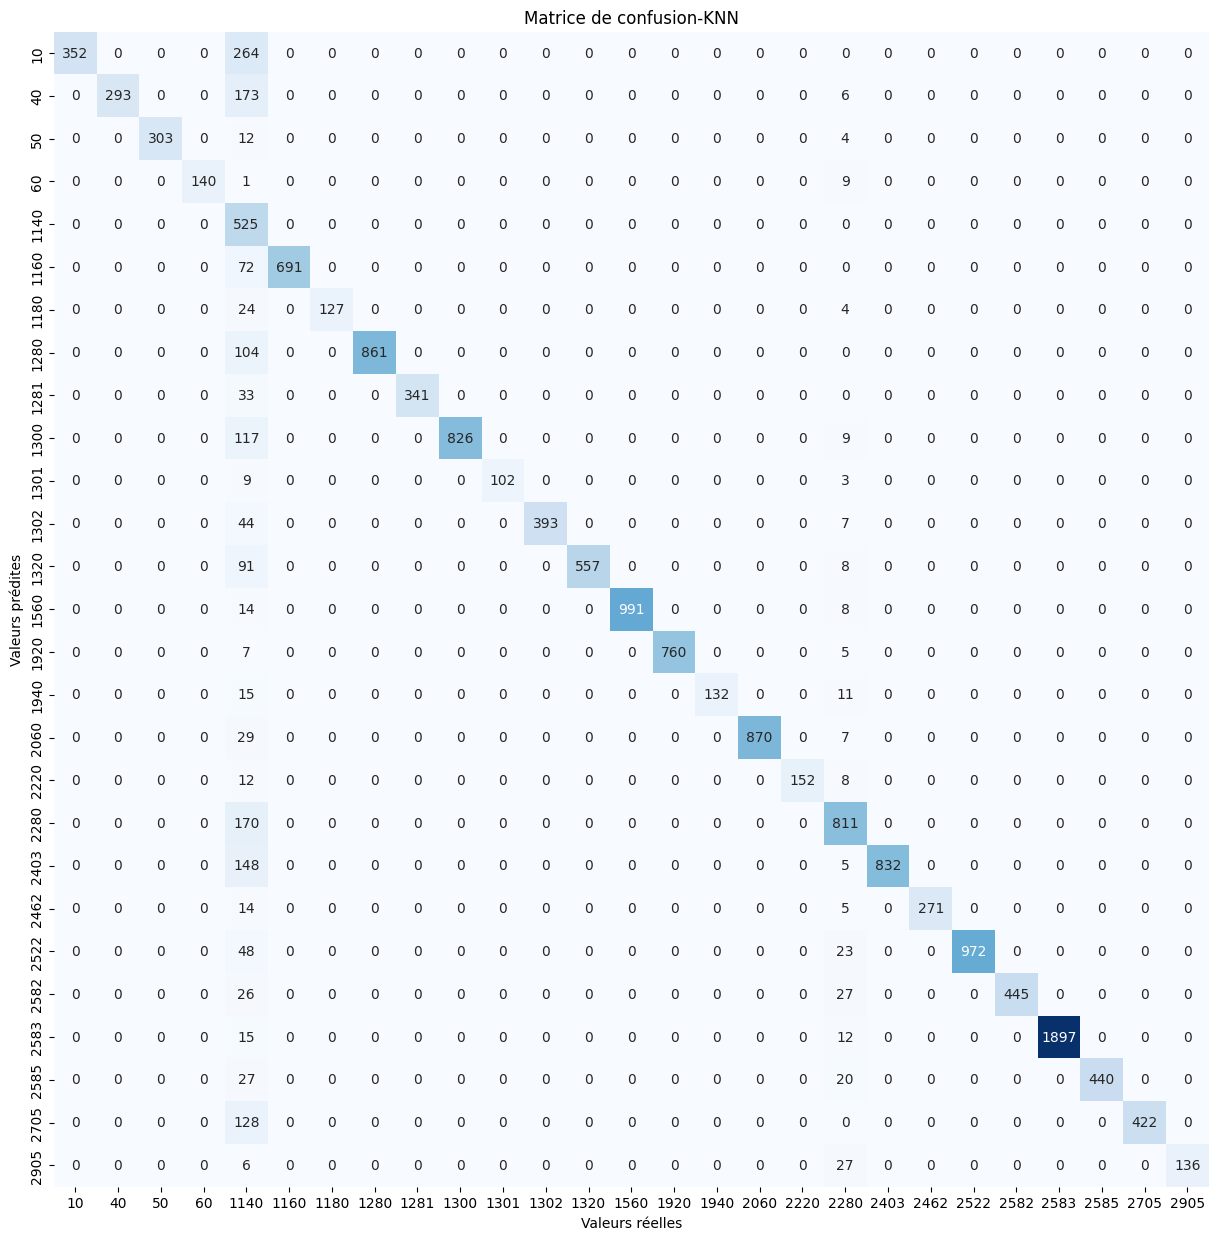

train_f1_score = [array([0.74187862, 0.78681585, 0.97902098, 0.98865478, 0.41804716,
       0.95184881, 0.90566038, 0.94899366, 0.95154472, 0.93382644,
       0.97002141, 0.95205866, 0.92985043, 0.99096541, 0.99508035,
       0.94771242, 0.98335432, 0.96717374, 0.8178279 , 0.91499138,
       0.97473588, 0.96869196, 0.96398031, 0.99412714, 0.96092077,
       0.87859506, 0.94760479])]
test_f1_score = [array([0.72727273, 0.76601307, 0.97427653, 0.96551724, 0.39577836,
       0.95048143, 0.90070922, 0.94304491, 0.95384615, 0.92913386,
       0.94444444, 0.9390681 , 0.91838417, 0.98902196, 0.9921671 ,
       0.91034483, 0.97972973, 0.9382716 , 0.811     , 0.91579527,
       0.96613191, 0.96476427, 0.94379639, 0.99293379, 0.94929881,
       0.86831276, 0.89180328])]
train_mse_result =  100688.73380234608
test_mse_result = 110777.3902023947
best_params: [{'n_neighbors': 10}]


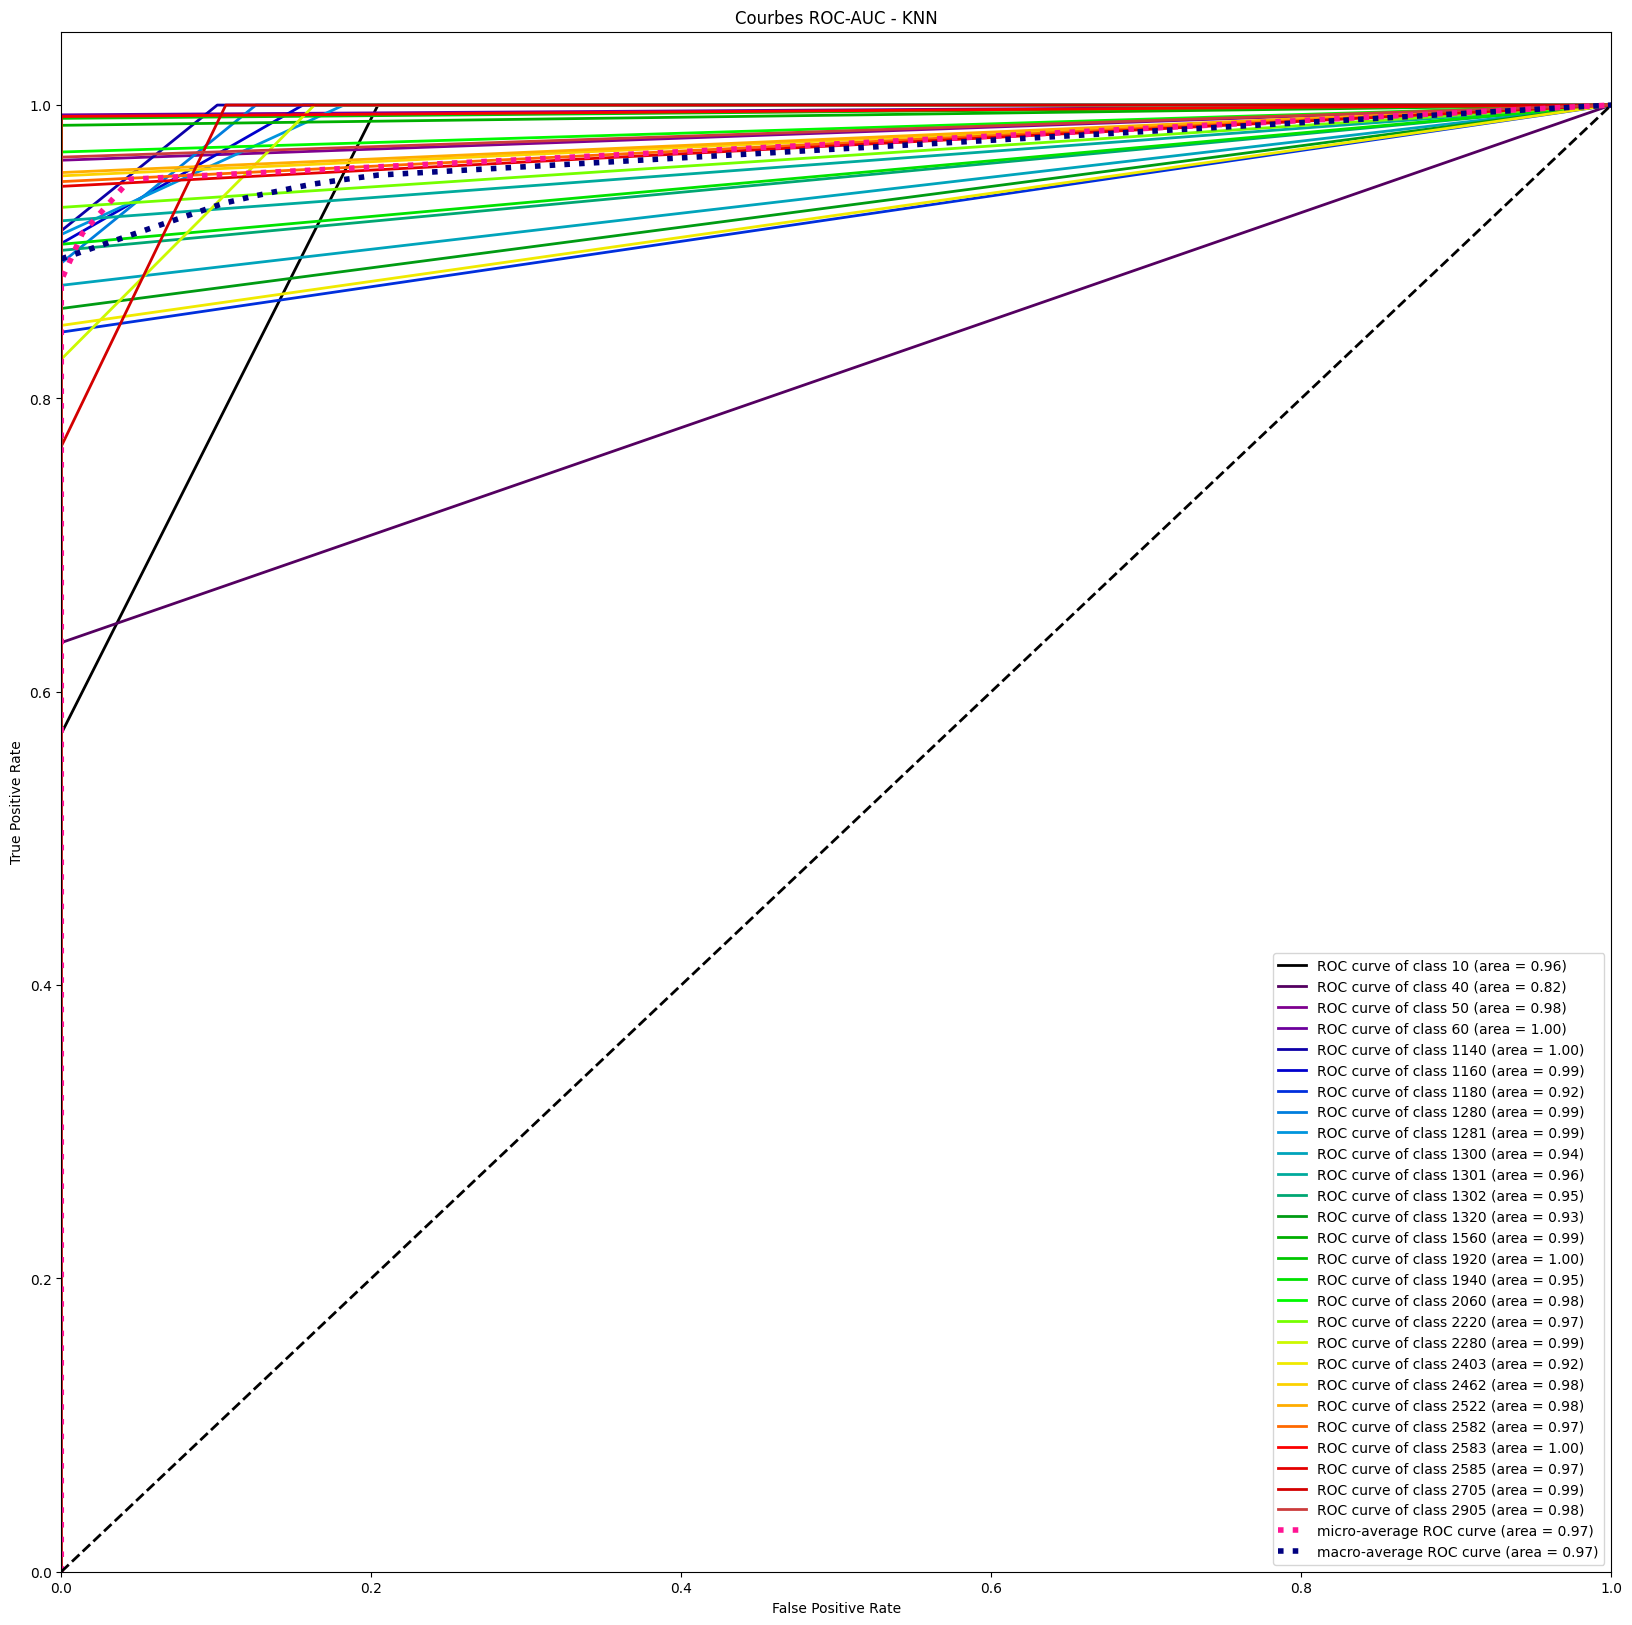

AttributeError: 'list' object has no attribute 'mean'

In [33]:
def execute_tuned_models(df, scale= False):
    print("df.shape :", df.shape)
    display(X_train)
    
    if scale == True:
        scaler = preprocessing.StandardScaler()
        print('X_train BEFORE scaling :')
        display(X_train.head())
        # apply the scaler to X_train by transform method to get X_train_scaled
        X_train_scaled = scaler.fit_transform(X_train)
        print('X_train_scaled (after scaling):')
        display(pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index).head())

        X_test_scaled = scaler.transform(X_test)
        print('X_test_scaled (after scaling):')
        display(pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index).head())

        return create_model_tuned(X_train=X_train_scaled, X_test=X_test_scaled, y_train=y_train, y_test=y_test, target= target, cv=3,
                                  estimator_name='KNN', estimator=neighbors.KNeighborsClassifier(), params={'n_neighbors' : [10]})
    else:
        return create_model_tuned(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, target= target, cv=3,
                                  estimator_name='KNN', estimator=neighbors.KNeighborsClassifier(), params={'n_neighbors' : [10]})

# The scaling is aleady choosen before calling excute_tuned_models         
get_df_basic_elements( execute_tuned_models(df, False), infos_types=['shape', 'head', 'tail', 'info'], actions=['print'])

## E3. **LCEClassifier** : Simulation/Exécution des modèles

In [5]:
from Lce import LCEClassifier
from sklearn.metrics import accuracy_score

clf = LCEClassifier(n_estimators=2, n_jobs=-1, random_state=0)
clf.fit(X_train, y_train)

def excute_LCEClassifier(df, X_train, X_test, y_train, y_test):
    df = df.dropna()
    print("df.shape :", df.shape)
    X = df.drop(['category_code', 'prdtypelabelguess'], axis = 1)
    target = df['category_code']
    X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=.2)

    if scale == True:
        print("/////////////X_train a X_test scaled/////////////////////////////")
        scaler = preprocessing.StandardScaler()
        print('X_train BEFORE scaling :')
        display(X_train.head())
        # apply the scaler to X_train by transform method to get X_train_scaled
        X_train_scaled = scaler.fit_transform(X_train)
        print('X_train_scaled (after scaling):')
        display(pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index).head())

        X_test_scaled = scaler.transform(X_test)
        print('X_test_scaled (after scaling):')
        display(pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index).head())

        # proceed now to apply LCEClassifier
        clf = LCEClassifier(n_estimators=2, n_jobs=-1, random_state=0)
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)
        LCE_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
        print("accuracy of LCE Classifier={:.f}%", round(LCE_accuracy*100, 2))
        get_conf_matrix(y_pred=y_pred, y_test=y_test, title="CONF Matrix - LCE Classifier")
    else:
        print("/////////////X_train a X_test NOT scaled/////////////////////////////")
        #proceed now to apply LCEClassifier
        clf = LCEClassifier(n_estimators=2, n_jobs=-1, random_state=0)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        LCE_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
        print("accuracy of LCE Classifier={:.f}%", round(LCE_accuracy*100, 2))
        get_conf_matrix(y_pred=y_pred, y_test=y_test, title="CONF Matrix - LCE Classifier")
        

excute_LCEClassifier(df=df, scale=True)


ModuleNotFoundError: No module named 'lce'

## E4.  **GradientBoostingClassifier** : Simulation/Exécution des modèles


### E4.1 Libraries to import and support functions

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import plot_importance
import xgboost
from sklearn.metrics import classification_report

df.shape : (82265, 4052)


actes  afrique  age  american  ammareal  amour  analysis  ancien  \
0          0        0    0         0         0      0         0       0   
1          0        0    0         0         0      0         0       0   
2          0        0    0         0         0      0         0       0   
3          0        0    0         0         0      0         0       0   
4          0        0    0         0         0      0         0       0   
...      ...      ...  ...       ...       ...    ...       ...     ...   
82260      0        0    0         0         0      0         0       0   
82261      0        0    0         0         0      0         0       0   
82262      0        0    0         0         0      0         0       0   
82263      0        0    0         0         0      0         0       0   
82264      0        0    0         0         0      0         0       0   

       annee  applications  ...  vidéo_x.5  ville_x.1  vista  vive  vram  \
0          0             0  ...          0          0      0     0     0   
1          0             0  ...          0          0      0     0     0   
2          0             0  ...          0          0      0     0     0   
3          0             0  ...          0          0      0     0     0   
4          0             0  ...          0          0      0     0     0   
...      ...           ...  ...        ...        ...    ...   ...   ...   
82260      0             0  ...          0          0      2     0     0   
82261      0             0  ...          1          1      0     0     0   
82262      0             0  ...          0          0      1     0     0   
82263      0             0  ...          0          1      0     0     0   
82264      0             0  ...          0          0      0     0     0   

       windows  xp  édition_x.3  également_x.9  équipe  
0            0   0            0              0       0  
1            0   0            0              0       0  
2            0   0            0              0       0  
3            0   0            0              0       0  
4            0   0            0              0       0  
...        ...  ..          ...            ...     ...  
82260        2   2            0              2       4  
82261        2   0            0              0       0  
82262        0   1            0              1       0  
82263        0   0            0              0       0  
82264        1   0            1              0       0  

[82265 rows x 4050 columns]

X_train.shape (59230, 4050)
X_test.shape (14808, 4050)
X_valid.shape (8227, 4050)
[0]	train-rmse:787.38739	eval-rmse:778.45452
[1]	train-rmse:787.68218	eval-rmse:778.85066
[2]	train-rmse:787.67933	eval-rmse:778.84305
[3]	train-rmse:787.67889	eval-rmse:778.84263
[4]	train-rmse:787.67891	eval-rmse:778.84266
[5]	train-rmse:787.67891	eval-rmse:778.84266
[6]	train-rmse:787.67891	eval-rmse:778.84265
[7]	train-rmse:787.67891	eval-rmse:778.84266
[8]	train-rmse:787.67891	eval-rmse:778.84266
[9]	train-rmse:787.67891	eval-rmse:778.84265
[10]	train-rmse:787.67891	eval-rmse:778.84266
[11]	train-rmse:787.67891	eval-rmse:778.84266
[12]	train-rmse:787.67891	eval-rmse:778.84266
[13]	train-rmse:787.67891	eval-rmse:778.84265
[14]	train-rmse:787.67891	eval-rmse:778.84266


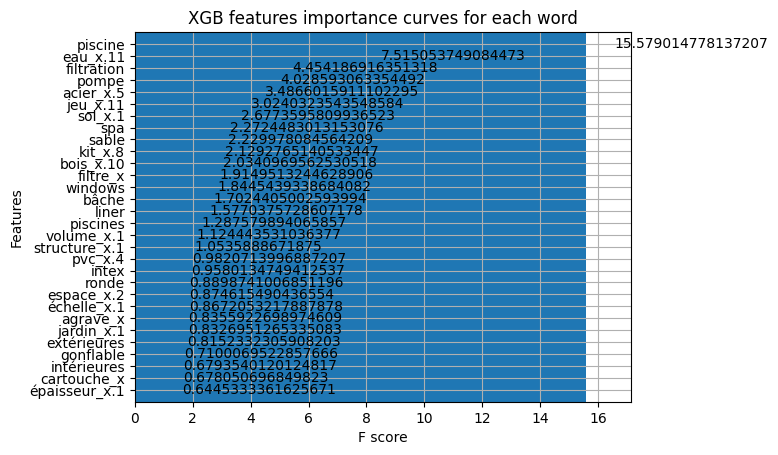

<Figure size 10000x2000 with 0 Axes>

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0       787.373714        0.665967      787.417934         1.2781

array([1761.5339, 1749.0784, 1761.5339, ..., 1761.5339, 1761.5339,
       1761.5339], dtype=float32)

14808

Prdictions scores:


0        1
1        1
2        1
3        1
4        1
        ..
14803    1
14804    1
14805    1
14806    1
14807    1
Length: 14808, dtype: int32

14808

============================CONFUSION MATRIX=======================================
Use SEABORN to draw confusion_matrix-----------------------------------------------
Confusion matrix as graph with Seaborn :


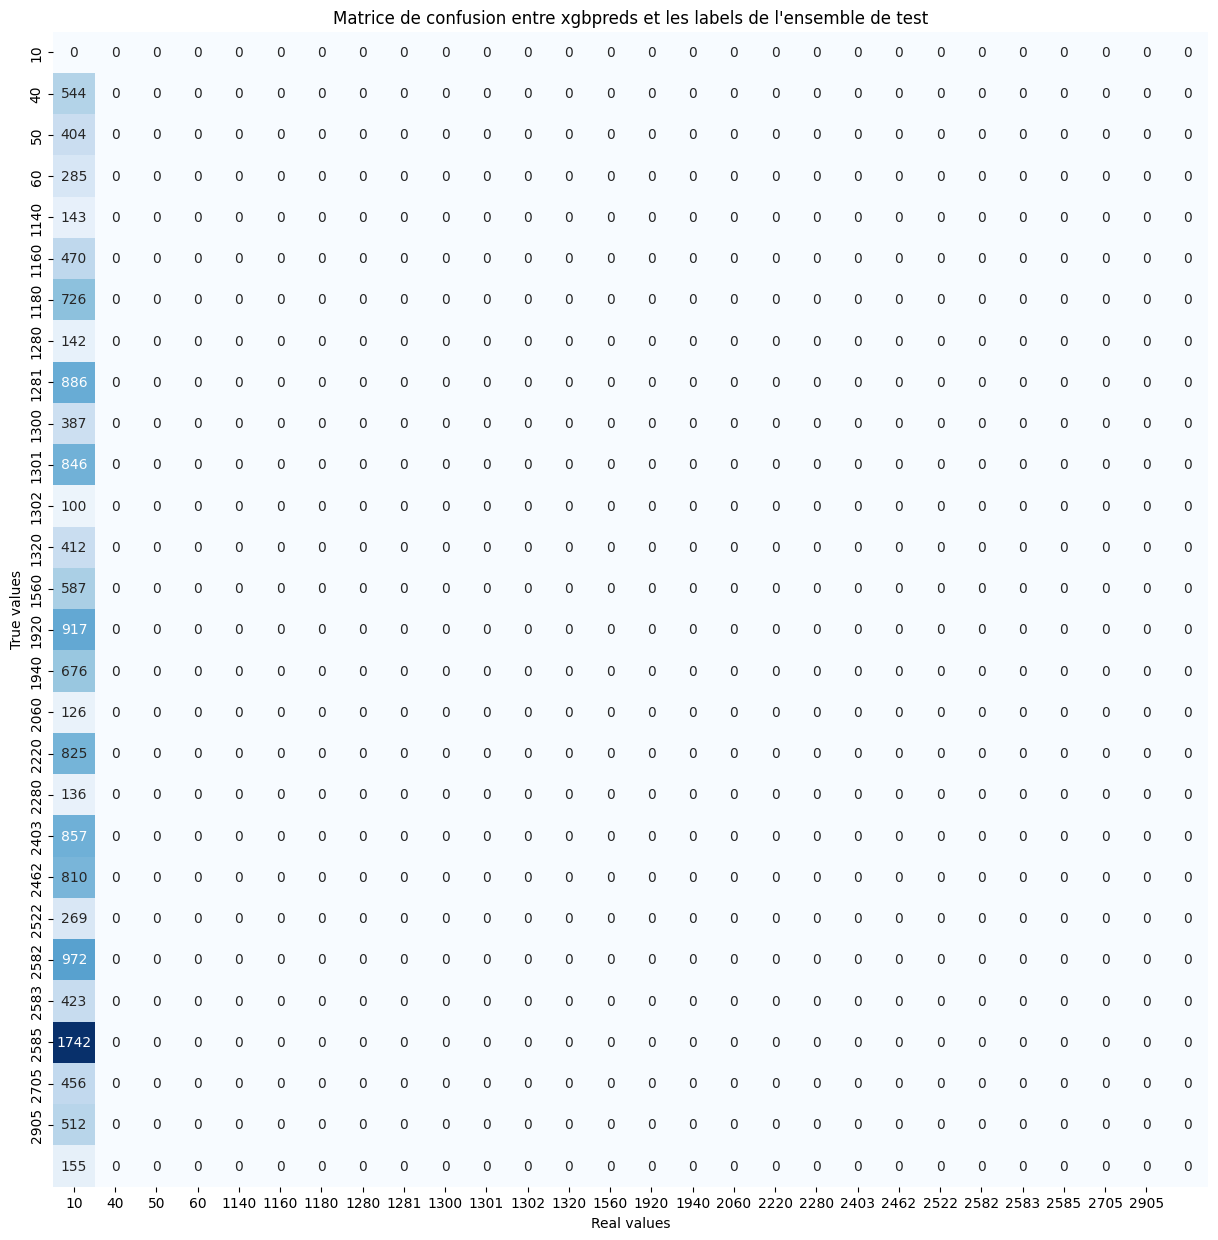

Erreur du modèle: [0]	eval-rmse:778.67548642095391642


In [27]:


print("ref: https://xgboost.readthedocs.io/en/stable/parameter.html")

def execute_gboost(df, scale= False):
    df = df.dropna()
    print("df.shape :", df.shape)
    X = df.drop(['category_code', 'prdtypelabelguess'], axis = 1)
    target = df['category_code']
    
    # liste des colonnes à dichotomiser :
    features_matrix = pd.get_dummies(X)
    display(features_matrix)
    
    # get 10% for validation set and put the 90% in (X, y) set
    X, X_valid, y, y_valid = train_test_split(features_matrix, target, test_size=.1)
    # select from  the (X, y) set, 20% for testing set and 80% for training set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
    print("X_train.shape", X_train.shape)
    print("X_test.shape", X_test.shape)
    print("X_valid.shape", X_valid.shape)
    
    
    # defione corresponding DMatrix
    train = xgboost.DMatrix(X_train, label=y_train)
    test =  xgboost.DMatrix(X_test, label=y_test)
    valid =  xgboost.DMatrix(X_valid, label=y_valid)
    
    #params = {'booster' : 'gbtree', 'learning_rate' : 1, 'objective' : 'binary:logistic'}
    params = {'booster' : 'gblinear', 'learning_rate' : 1, 'lambda': 10, 'alpha': 10}
    xgb  = xgboost.train(params=params, dtrain=train, num_boost_round=700, early_stopping_rounds=15, 
                        evals=[(train, 'train'), (test, 'eval')])
    
    # plot importance of each feature
    
    plot_importance(xgb, height=100, title="XGB features importance curves for each word", max_num_features=30, grid=True);
    plt.figure(figsize=(100, 20))
    plt.show()
    
    
    bst_cv = xgboost.cv(params= params, dtrain= train, nfold=3, num_boost_round=100, early_stopping_rounds=50)
    display(bst_cv)
    
    
    preds = xgb.predict(test)
    display(preds, len(preds))
    xgbpreds = pd.Series(np.where(preds > .5, 1, 0))
    print("Prdictions scores:")
    display(xgbpreds, len(xgbpreds))
    
    get_conf_matrix(y_pred= xgbpreds, y_test= pd.Series(y_test), xlabel='Real values', ylabel='True values',
                    target= target, title="Matrice de confusion entre xgbpreds et les labels de l'ensemble de test")
    
    print("Erreur du modèle:", xgb.eval(valid))

execute_gboost(df=df, scale=True)


### E4.2 Execution

In [30]:
X = df.drop(['category_code', 'prdtypelabelguess'], axis = 1)
target = df['category_code']
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=.2)


print("/////////////X_train a X_test scaled/////////////////////////////")
scaler = preprocessing.StandardScaler()
print('X_train BEFORE scaling :')
display(X_train.head())
# apply the scaler to X_train by transform method to get X_train_scaled
X_train_scaled = scaler.fit_transform(X_train)
print('X_train_scaled (after scaling):')
display(pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index).head())

X_test_scaled = scaler.transform(X_test)
print('X_test_scaled (after scaling):')
display(pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index).head())

# Define the hyperparameter grid
#param_grid = {'booster' : 'gblinear', 'learning_rate' : 1, 'lambda': 2, 'alpha': .5}

param_grid = {
    'learning_rate' : 1, 
    'lambda': 2, 
    'alpha': .5,
    'min_child_weight': [4, 5],
    'gamma': [i / 10.0 for i in range(3, 6)],
    'subsample': [i / 10.0 for i in range(6, 11)],
    'colsample_bytree': [i / 10.0 for i in range(6, 11)],
    'max_depth': [2, 3, 4]
}

# Create the XGBoost model object
xgb_model = xgboost.XGBClassifier( n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_scaled, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

y_pred = grid_search.predict(y_test)

get_conf_matrix(y_pred= y_pred, y_test= y_test, xlabel='Real values', ylabel='True values',
                target= target, title="Matrice de confusion XGBOOST")
    

/////////////X_train a X_test scaled/////////////////////////////
X_train BEFORE scaling :


actes  afrique  age  american  ammareal  amour  analysis  ancien  \
43925      0        0    0         0         0      0         0       0   
81202      0        0    0         0         0      0         0       0   
13474      0        0    0         0         0      0         0       0   
11273      0        0    0         0         0      0         0       0   
45595      0        0    0         0         0      0         0       0   

       annee  applications  ...  vidéo_x.5  ville_x.1  vista  vive  vram  \
43925      0             0  ...          0          0      0     0     0   
81202      0             0  ...          0          0      0     0     0   
13474      0             0  ...          0          0      0     0     0   
11273      0             0  ...          0          0      0     0     0   
45595      0             0  ...          0          0      0     0     0   

       windows  xp  édition_x.3  également_x.9  équipe  
43925        0   0            0              0       0  
81202        0   0            0              0       0  
13474        0   0            0              0       0  
11273        0   0            0              0       0  
45595        0   0            0              0       0  

[5 rows x 4050 columns]

X_train_scaled (after scaling):


actes   afrique       age  american  ammareal     amour  analysis  \
43925 -0.014056 -0.008335 -0.013085 -0.012328 -0.021622 -0.014702 -0.012328   
81202 -0.014056 -0.008335 -0.013085 -0.012328 -0.021622 -0.014702 -0.012328   
13474 -0.014056 -0.008335 -0.013085 -0.012328 -0.021622 -0.014702 -0.012328   
11273 -0.014056 -0.008335 -0.013085 -0.012328 -0.021622 -0.014702 -0.012328   
45595 -0.014056 -0.008335 -0.013085 -0.012328 -0.021622 -0.014702 -0.012328   

         ancien     annee  applications  ...  vidéo_x.5  ville_x.1     vista  \
43925 -0.017508 -0.012328     -0.011253  ...  -0.047666  -0.028523 -0.050751   
81202 -0.017508 -0.012328     -0.011253  ...  -0.047666  -0.028523 -0.050751   
13474 -0.017508 -0.012328     -0.011253  ...  -0.047666  -0.028523 -0.050751   
11273 -0.017508 -0.012328     -0.011253  ...  -0.047666  -0.028523 -0.050751   
45595 -0.017508 -0.012328     -0.011253  ...  -0.047666  -0.028523 -0.050751   

          vive      vram  windows        xp  édition_x.3  également_x.9  \
43925 -0.03091 -0.025908 -0.07059 -0.049496    -0.027541      -0.035553   
81202 -0.03091 -0.025908 -0.07059 -0.049496    -0.027541      -0.035553   
13474 -0.03091 -0.025908 -0.07059 -0.049496    -0.027541      -0.035553   
11273 -0.03091 -0.025908 -0.07059 -0.049496    -0.027541      -0.035553   
45595 -0.03091 -0.025908 -0.07059 -0.049496    -0.027541      -0.035553   

         équipe  
43925 -0.027017  
81202 -0.027017  
13474 -0.027017  
11273 -0.027017  
45595 -0.027017  

[5 rows x 4050 columns]

X_test_scaled (after scaling):


actes   afrique       age  american  ammareal     amour  analysis  \
78644 -0.014056 -0.008335 -0.013085 -0.012328 -0.021622 -0.014702 -0.012328   
68357 -0.014056 -0.008335 -0.013085 -0.012328 -0.021622 -0.014702 -0.012328   
33014 -0.014056 -0.008335 -0.013085 -0.012328 -0.021622 -0.014702 -0.012328   
80704 -0.014056 -0.008335 -0.013085 -0.012328 -0.021622 -0.014702 -0.012328   
22793 -0.014056 -0.008335 -0.013085 -0.012328 -0.021622 -0.014702 -0.012328   

         ancien     annee  applications  ...  vidéo_x.5  ville_x.1     vista  \
78644 -0.017508 -0.012328     -0.011253  ...  -0.047666  -0.028523 -0.050751   
68357 -0.017508 -0.012328     -0.011253  ...  -0.047666  -0.028523 -0.050751   
33014 -0.017508 -0.012328     -0.011253  ...  -0.047666  -0.028523 -0.050751   
80704 -0.017508 -0.012328     -0.011253  ...  -0.047666  -0.028523 -0.050751   
22793 -0.017508 -0.012328     -0.011253  ...  -0.047666  -0.028523 -0.050751   

          vive      vram  windows        xp  édition_x.3  également_x.9  \
78644 -0.03091 -0.025908 -0.07059 -0.049496    -0.027541      -0.035553   
68357 -0.03091 -0.025908 -0.07059 -0.049496    -0.027541      -0.035553   
33014 -0.03091 -0.025908 -0.07059 -0.049496    -0.027541      -0.035553   
80704 -0.03091 -0.025908 -0.07059 -0.049496    -0.027541      -0.035553   
22793 -0.03091 -0.025908 -0.07059 -0.049496    -0.027541      -0.035553   

         équipe  
78644 -0.027017  
68357 -0.027017  
33014 -0.027017  
80704 -0.027017  
22793 -0.027017  

[5 rows x 4050 columns]

TypeError: Parameter grid for parameter 'booster' needs to be a list or a numpy array, but got 'gblinear' (of type str) instead. Single values need to be wrapped in a list with one element.

#### A. Spliting and scaling

In [9]:
#////////////////////////////////////////////////////////////
# A. Splitting and scaling
#////////////////////////////////////////////////////////////
X = df.drop(['category_code', 'prdtypelabelguess'], axis = 1)
target = df['category_code']
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=.2)


print("/////////////X_train a X_test scaled/////////////////////////////")
scaler = preprocessing.StandardScaler()
print('X_train BEFORE scaling :')
display(X_train.head())
# apply the scaler to X_train by transform method to get X_train_scaled
X_train_scaled = scaler.fit_transform(X_train)
print('X_train_scaled (after scaling):')
display(pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index).head())

X_test_scaled = scaler.transform(X_test)
print('X_test_scaled (after scaling):')
display(pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index).head())


/////////////X_train a X_test scaled/////////////////////////////
X_train BEFORE scaling :


actes  afrique  age  american  ammareal  amour  analysis  ancien  \
55259      0        0    0         0         0      0         0       0   
62802      0        0    0         0         0      0         0       0   
61904      0        0    0         0         0      0         0       0   
72698      0        0    0         0         0      0         0       0   
48510      0        0    0         0         0      0         0       0   

       annee  applications  ...  vidéo_x.5  ville_x.1  vista  vive  vram  \
55259      0             0  ...          0          0      0     0     0   
62802      0             0  ...          0          0      0     0     0   
61904      0             0  ...          0          0      0     0     0   
72698      0             0  ...          0          0      0     0     0   
48510      0             0  ...          0          0      0     0     0   

       windows  xp  édition_x.3  également_x.9  équipe  
55259        0   0            0              0       0  
62802        0   0            0              0       0  
61904        0   0            0              0       0  
72698        0   0            0              0       0  
48510        0   0            0              0       0  

[5 rows x 4050 columns]

X_train_scaled (after scaling):


actes   afrique       age  american  ammareal     amour  analysis  \
55259 -0.012929 -0.011026 -0.013644 -0.012929 -0.021536 -0.013644 -0.011026   
62802 -0.012929 -0.011026 -0.013644 -0.012929 -0.021536 -0.013644 -0.011026   
61904 -0.012929 -0.011026 -0.013644 -0.012929 -0.021536 -0.013644 -0.011026   
72698 -0.012929 -0.011026 -0.013644 -0.012929 -0.021536 -0.013644 -0.011026   
48510 -0.012929 -0.011026 -0.013644 -0.012929 -0.021536 -0.013644 -0.011026   

         ancien     annee  applications  ...  vidéo_x.5  ville_x.1     vista  \
55259 -0.017435 -0.011893     -0.013085  ...  -0.048468  -0.028049 -0.050903   
62802 -0.017435 -0.011893     -0.013085  ...  -0.048468  -0.028049 -0.050903   
61904 -0.017435 -0.011893     -0.013085  ...  -0.048468  -0.028049 -0.050903   
72698 -0.017435 -0.011893     -0.013085  ...  -0.048468  -0.028049 -0.050903   
48510 -0.017435 -0.011893     -0.013085  ...  -0.048468  -0.028049 -0.050903   

           vive      vram   windows        xp  édition_x.3  également_x.9  \
55259 -0.031753 -0.026199 -0.071608 -0.051052    -0.028194      -0.034334   
62802 -0.031753 -0.026199 -0.071608 -0.051052    -0.028194      -0.034334   
61904 -0.031753 -0.026199 -0.071608 -0.051052    -0.028194      -0.034334   
72698 -0.031753 -0.026199 -0.071608 -0.051052    -0.028194      -0.034334   
48510 -0.031753 -0.026199 -0.071608 -0.051052    -0.028194      -0.034334   

         équipe  
55259 -0.026287  
62802 -0.026287  
61904 -0.026287  
72698 -0.026287  
48510 -0.026287  

[5 rows x 4050 columns]

X_test_scaled (after scaling):


actes   afrique       age  american  ammareal     amour  analysis  \
64553 -0.012929 -0.011026 -0.013644 -0.012929 -0.021536 -0.013644 -0.011026   
58750 -0.012929 -0.011026 -0.013644 -0.012929 -0.021536 -0.013644 -0.011026   
31347 -0.012929 -0.011026 -0.013644 -0.012929 -0.021536 -0.013644 -0.011026   
78684 -0.012929 -0.011026 -0.013644 -0.012929 -0.021536 -0.013644 -0.011026   
31143 -0.012929 -0.011026 -0.013644 -0.012929 -0.021536 -0.013644 -0.011026   

         ancien     annee  applications  ...  vidéo_x.5  ville_x.1     vista  \
64553 -0.017435 -0.011893     -0.013085  ...  -0.048468  -0.028049 -0.050903   
58750 -0.017435 -0.011893     -0.013085  ...  -0.048468  -0.028049 -0.050903   
31347 -0.017435 -0.011893     -0.013085  ...  -0.048468  -0.028049 -0.050903   
78684 -0.017435 -0.011893     -0.013085  ...  -0.048468  -0.028049 -0.050903   
31143 -0.017435 -0.011893     -0.013085  ...  -0.048468  -0.028049 -0.050903   

           vive      vram   windows        xp  édition_x.3  également_x.9  \
64553 -0.031753 -0.026199 -0.071608 -0.051052    -0.028194      -0.034334   
58750 -0.031753 -0.026199 -0.071608 -0.051052    -0.028194      -0.034334   
31347 -0.031753 -0.026199 -0.071608 -0.051052    -0.028194      -0.034334   
78684 -0.031753 -0.026199 -0.071608 -0.051052    -0.028194      -0.034334   
31143 -0.031753 -0.026199 -0.071608 -0.051052    -0.028194      -0.034334   

         équipe  
64553 -0.026287  
58750 -0.026287  
31347 -0.026287  
78684 -0.026287  
31143 -0.026287  

[5 rows x 4050 columns]

#### B. Hyperparameters tuning

In [13]:

#////////////////////////////////////////////////////////////
# B. Hyperparameters tuning
#////////////////////////////////////////////////////////////

param_grid = {
    'learning_rate': [0.1, 1],
    'max_depth': [3, 5, 7],
    'n_estimators': [10, 50]
}

# Create the XGBoost model object
xgb_model = xgboost.XGBClassifier()

# Use stratified k-fold cross-validation to tune the hyperparameters
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid, cv=cv)
# we have to start target labeling from 0, otherwise XGBOOST doesn't work !
# (https://stackoverflow.com/questions/71996617/invalid-classes-inferred-from-unique-values-of-y-expected-0-1-2-3-4-5-got)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(target)

grid_search.fit(X=X, y=y_train)

# Print the best hyperparameters
print(f'Best learning rate: {grid_search.best_params_["learning_rate"]}')
print(f'Best max depth: {grid_search.best_params_["max_depth"]}')
print(f'Best number of estimators: {grid_search.best_params_["n_estimators"]}')



Best learning rate: 1
Best max depth: 7
Best number of estimators: 50


#### C. Model evaluation based on best params

In [16]:

#////////////////////////////////////////////////////////////
# C. Model evaluation based on best params to pass as parameters below
#////////////////////////////////////////////////////////////
# Define the model
model = xgboost.XGBClassifier(learning_rate=10, max_depth=20, n_estimators=100)

# Fit the model to the training data
model.fit(X_train_scaled, y_train)

# Make predictions on the test data
le = LabelEncoder()
y_train = le.fit_transform(y_train)
model.fit(X_train_scaled, y_train)

# Print the classification report
print(classification_report(y_test, y_pred))

# CM
get_conf_matrix(y_pred= y_pred, y_test= y_test, xlabel='Real values', ylabel='True values',
                target= target, title="Matrice de confusion XGBOOST")

XGBoostError: [18:46:27] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\data\data.cc:508: Check failed: this->labels.Size() % this->num_row_ == 0 (16453 vs. 0) : Incorrect size for labels.

In [ ]:
#////////////////////////////////////////////////////////////
# D. variable importance graphic
#////////////////////////////////////////////////////////////
